### **1. Install & Import Essential Libraries**

In [ ]:
# Install Essential NLP Libraries
!pip install contractions pyspellchecker emoji -U imbalanced-learn wordcloud

In [ ]:
# Core Libraries
import pandas as pd                          # Data manipulation and analysis
import numpy as np                           # Numerical operations and array handling
import re                                    # Regular expressions for text cleaning
import html                                  # HTML entity handling
import logging # Import the logging module

# Natural Language Processing
import contractions                          # Expand contractions (e.g., "can't" → "cannot")
import emoji                                 # Handle emojis in text
import spacy                                 # NLP tasks (e.g., POS tagging, tokenization)
from spellchecker import SpellChecker        # Spell checking and correction

# NLTK Modules
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tag import pos_tag

# Necessary NLTK Components
#nltk.download('punkt')
nltk.download('punkt_tab',  quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('omw-1.4', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('averaged_perceptron_tagger_eng', quiet=True)
#nltk.download('averaged_perceptron_tagger')

# Machine Learning Libraries
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
)

# Handling Class Imbalance
from imblearn.over_sampling import SMOTE

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Dimensionality Reduction
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Text Embedding
import gensim.downloader as api

# System Utilities
from collections import Counter

# Load SpaCy Language Model
nlp = spacy.load("en_core_web_sm")

# Initialize Spell Checker
spell = SpellChecker()

# Reproducibility
RANDOM_SEED = 100


# Suppress Warnings
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)

# Configure logging
logging.basicConfig(filename='preprocessing.log', level=logging.INFO)

### **2. Load & Inspect Data**

In [ ]:
# Read the CSV file (Example: Google Drive URL)
df = pd.read_csv(r'train.csv')
#df = pd.read_csv('https://drive.google.com/uc?id=1fPaDyGK2qkByWP54PuV2C8dDQ5eIuT_3&export=download')
# Display the first few rows
df.head()

id                                              tweet label
0  86426  @USER She should ask a few native Americans wh...   UNT
1  90194  @USER @USER Go home you’re drunk!!! @USER #MAG...   TIN
2  16820  Amazon is investigating Chinese employees who ...   NOT
3  62688  @USER Someone should'veTaken" this piece of sh...   UNT
4  43605  @USER @USER Obama wanted liberals &amp; illega...   NOT

In [ ]:
# empty strings and NaN values are checked at each stage of your preprocessing pipeline:
# After loading the initial data:
print("Missing values in 'tweet' column initially:", df['tweet'].isnull().sum())
print("Empty strings in 'tweet' column initially:", df[df['tweet'] == ''].shape[0])

Missing values in 'tweet' column initially: 0
Empty strings in 'tweet' column initially: 0


In [ ]:
df.shape

(13240, 3)

### **3. Data Cleaning & Preprocessing**

**3.1. Text Processing**

In [ ]:
def clean_text(text):
    """Cleans text by removing special characters, emojis, URLs, and repeated characters."""

    # Decode HTML entities
    text = html.unescape(text)

    # Expand contractions (e.g., "can't" -> "cannot")
    text = contractions.fix(text)

    # Convert emojis to text descriptions (😊 -> ":smiling_face_with_smiling_eyes:")
    text = emoji.demojize(text, delimiters=(" ", " "))

    # Remove URLs and domains
    text = re.sub(r'(https?://|www\.)\S+|[a-zA-Z0-9.-]+\.(com|org|net|edu|gov|uk|io|co)\S*', '', text)

    # Remove mentions and hashtags
    text = re.sub(r'@\w+', '', text)       # Remove mentions (@username)
    text = re.sub(r'#\w+', '', text)       # Remove hashtags (#hashtag)

    # Remove special characters except alphanumeric, spaces, and emojis
    text = re.sub(r'[^a-zA-Z0-9\s:]', '', text)

    # Normalize repeated characters (e.g., "loooove" -> "love")
    text = re.sub(r'(.)\1{2,}', r'\1', text)

    # Convert text to lowercase
    text = text.lower()

    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()

    return text

# Apply the function
df['cleaned_text'] = df['tweet'].apply(clean_text)

Noise like special characters, URLs, emojis, and excessive spaces is removed while expanding contractions and normalizing repeated letters.
This ensures text consistency for better tokenization and model performance in sentiment analysis, classification, and other NLP tasks.

Also, missing values and empty strings are checked at each processing stage

In [ ]:
# After applying clean_text:
print("Missing values in 'cleaned_text' column:", df['cleaned_text'].isnull().sum())
print("Empty strings in 'cleaned_text' column:", df[df['cleaned_text'] == ''].shape[0])

Missing values in 'cleaned_text' column: 0
Empty strings in 'cleaned_text' column: 7


In [ ]:
df = df[df['cleaned_text'] != '']

In [ ]:
# After applying clean_text:
print("Missing values in 'cleaned_text' column:", df['cleaned_text'].isnull().sum())
print("Empty strings in 'cleaned_text' column:", df[df['cleaned_text'] == ''].shape[0])

Missing values in 'cleaned_text' column: 0
Empty strings in 'cleaned_text' column: 0


**3.2. Tokenization with Negation Handling**

In [ ]:
def handle_negations_spacy(text):
    """Handles negation to retain contextual meaning in NLP tasks."""
    doc = nlp(text)
    tokens = []
    negate_next = False

    for token in doc:
        if token.text.lower() in {"no", "not", "never", "n't"}:
            negate_next = True
            tokens.append(token.text)
        elif negate_next:
            tokens.append(f"not_{token.text}")
            negate_next = False
        else:
            tokens.append(token.text)

    return ' '.join(tokens)

# Apply tokenization
df['tokenized_text'] = df['cleaned_text'].apply(handle_negations_spacy)
df.head()


id                                              tweet label  \
0  86426  @USER She should ask a few native Americans wh...   UNT   
1  90194  @USER @USER Go home you’re drunk!!! @USER #MAG...   TIN   
2  16820  Amazon is investigating Chinese employees who ...   NOT   
3  62688  @USER Someone should'veTaken" this piece of sh...   UNT   
4  43605  @USER @USER Obama wanted liberals &amp; illega...   NOT   

                                        cleaned_text  \
0  she should ask a few native americans what the...   
1  go home you are drunk oncomingfist unitedstate...   
2  amazon is investigating chinese employees who ...   
3  someone shouldvetaken this piece of shit to a ...   
4  obama wanted liberals illegals to move into re...   

                                      tokenized_text  
0  she should ask a few native americans what the...  
1  go home you are drunk oncomingfist unitedstate...  
2  amazon is investigating chinese employees who ...  
3  someone shouldvetaken this piece of shit to a ...  
4  obama wanted liberals illegals to move into re...

Negation contexts are preserves by tagging words after negation term e.g., "not good" → "not_good"). This helps models capture sentiment shifts accurately, improving text classification and sentiment analysis.

In [ ]:
# After applying handle_negations_spacy:
print("Missing values in 'tokenized_text' column:", df['tokenized_text'].isnull().sum())
print("Empty strings in 'tokenized_text' column:", df[df['tokenized_text'] == ''].shape[0])

Missing values in 'tokenized_text' column: 0
Empty strings in 'tokenized_text' column: 0


The tokenization table shows text broken down into individual words, and importantly, it highlights how negative words like "not" are now directly linked to the words they modify, ensuring the negative sentiment is preserved. This structured format makes the text much easier for both humans and computer programs to analyze and understand the intended meaning.

**3.3.Text Normalisation (Lemmatization-SpaCy)**

In [ ]:
# Load spaCy English model
nlp = spacy.load("en_core_web_sm")

# Lemmatization function using spaCy
def lemmatize_text_spacy(text):
    """Lemmatizes text using spaCy's NLP pipeline."""
    doc = nlp(text)
    # Extract lemmatized tokens and join them with a space
    lemmatized_tokens = [token.lemma_ for token in doc if not token.is_punct]
    return ' '.join(lemmatized_tokens)

# Apply the spaCy lemmatization function
df['lemmatized_text'] = df['tokenized_text'].apply(lemmatize_text_spacy)

# Display data after lemmatization
df.head()

Words are reduced to their base form using spaCy's lemmatization, which help normalizing text, improving text analysis and NLP accuracy.

Lemmatization ensures consistency by mapping different word forms to a single meaning.


In [ ]:
# After applying lemmatize_text_spacy:
print("Missing values in 'lemmatized_text' column:", df['lemmatized_text'].isnull().sum())
print("Empty strings in 'lemmatized_text' column:", df[df['lemmatized_text'] == ''].shape[0])

**3.4. Stopword Removal**

In [ ]:
def remove_stopwords(text):
    """Removes common stopwords while preserving key nouns and verbs."""
    stop_words = set(stopwords.words('english'))
    tokens = word_tokenize(text)
    pos_tags = nltk.pos_tag(tokens)

    filtered_tokens = [
        token for token, pos in pos_tags
        if token not in stop_words or pos.startswith(('NN', 'VB'))
    ]

    return ' '.join(filtered_tokens)

# Apply stopword removal
df['final_text'] = df['lemmatized_text'].apply(remove_stopwords)
df.head()

Unnecessary words such as "the" and "is" are removed, while keeping important nouns and verbs. It helps focus on meaningful words, improving text analysis and model performance.

Removing stopwords reduces noise, which makes models more efficient by focusing on keywords that carry meaning, enhancing text classification and sentiment analysis.

The table shows a more focused version of the text where the fluff is gone. By taking out common but less meaningful words. This makes the overall message clearer and easier to grasp, which is beneficial for understanding and classifying the text later.

In [ ]:
# After applying remove_stopwords:
print("Missing values in 'final_text' column:", df['final_text'].isnull().sum())
print("Empty strings in 'final_text' column:", df[df['final_text'] == ''].shape[0])

In [ ]:
df = df[df['final_text'] != '']

In [ ]:
# After applying remove_stopwords:
print("Missing values in 'final_text' column:", df['final_text'].isnull().sum())
print("Empty strings in 'final_text' column:", df[df['final_text'] == ''].shape[0])

**Save as CSV**

In [ ]:
df.to_csv('processed_text_data.csv', index=False)
df.head()

In [ ]:
df.isnull().sum()

### Load from CSV

In [ ]:
df_process = pd.read_csv('processed_text_data.csv')
df_process.head()

In [ ]:
df_process.isnull().sum()

### **4.0 Exploratory Data Analysis (EDA)**

**4.1 Class Distribution Visualization**

In [ ]:
# Visualizing the distribution of labels
sns.countplot(x='label', data=df, palette='viridis')
plt.title('Distribution of Labels')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()


The plot reveals that our data has an uneven distribution of labels, with some appearing much more frequently than others, potentially leading to model bias.

**4.2. Analyzing Text Length Distribution**

In [ ]:
# Compute text lengths
df['text_length'] = df['final_text'].apply(len)

# Visualize text length distribution
sns.histplot(df['text_length'], bins=50, kde=True, color='blue')
plt.title('Distribution of Text Length')
plt.xlabel('Text Length (Characters)')
plt.ylabel('Frequency')
plt.show()


The output is a histogram (a type of bar chart) that shows the frequency of different text lengths in the dataset. It allows you to quickly see how many texts are short, how many are long, and the general distribution of text lengths overall.

**4.3. Average Text Length by Label**

In [ ]:
# Compute average text length per label
avg_length_by_label = df.groupby('label')['text_length'].mean()

# Display average text length per label
print("Average Text Length by Label:\n", avg_length_by_label)


Shows text length across the categories (NOT, TIN, UNT) by calculating their average word count. Like insulting texts (TIN) being longer than neutral ones (NOT, UNT), this helps to improve classification accuracy.

**4.4. Identifying Missing Values**

In [ ]:
# Identify missing values
missing_values = df.isnull().sum()
print("Missing Values:\n", missing_values)

# Visualizing missing values
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Values Heatmap')
plt.show()


No missing values were found in the dataset, as confirmed by both the count and heatmap visualization.

This ensures data integrity and consistency, allowing for seamless preprocessing and feature extraction

**4.5. Analyzing Frequent Words**

In [ ]:
from collections import Counter

# Combine all text
all_text = ' '.join(df['final_text'])

# Tokenize words
tokens = word_tokenize(all_text)

# Compute word frequency
fdist = nltk.FreqDist(tokens)

# Display the top 20 most common words
print("Most Common Words:\n", fdist.most_common(20))

# Plot the top 20 words
fdist.plot(20, title='Top 20 Most Frequent Words')


The analysis identified the top 20 most frequent words in the dataset, with "be," "I," and "do" appearing most often. The word distribution suggests common patterns in the text, which can inform further preprocessing and feature engineering.

**4.6. Word Cloud for Visualization**



In [ ]:
from wordcloud import WordCloud

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)

# Display word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Preprocessed Text')
plt.show()


This visually highlights the most frequently occurring words in the preprocessed text, with "liberal," "gun," and "control" being the most prominent. This provides insights into the key themes and dominant terms in the dataset.

**4.7. Label Proportion Analysis**

In [ ]:
# Compute label proportions
label_proportions = df['label'].value_counts(normalize=True)

# Display proportions
print("Label Proportions:\n", label_proportions)

# Plot label proportions
label_proportions.plot(kind='pie', autopct='%1.1f%%', startangle=90, figsize=(6, 6))
plt.title('Proportion of Labels in the Dataset')
plt.ylabel('')
plt.show()


The pie chart illustrates the distribution of labels in the dataset, showing a class imbalance. The majority class is NOT (66.7%), followed by TIN (29.3%) and UNT (4.0%). This imbalance may impact model performance and might require resampling techniques like SMOTE or class weighting.

### **5.0. Feature Extraction**

**5.1. Count Vectorization**


In [ ]:
# Initialize CountVectorizer (Unigram model)
vectorizer = CountVectorizer(ngram_range=(1, 1))

# Apply Count Vectorization to the preprocessed text
X_count = vectorizer.fit_transform(df['final_text'])

# Display shape of the feature matrix
print("Count Vectorizer Shape:", X_count.shape)

# Show first few feature names (words)
print("Feature Names (First 10):", vectorizer.get_feature_names_out()[:10])


Count Vectorization converts text into a numerical matrix based on word frequency. The feature matrix has 13,228 samples and 16,683 unique words. However, this method lacks contextual understanding as it only counts word occurrences.

**5.2. TF-IDF (Weighted Word Importance)**


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize TF-IDF Vectorizer (Bigrams)
vectorizer_tfidf = TfidfVectorizer(ngram_range=(1, 2), max_features=5000)

# Apply TF-IDF transformation
X_tfidf = vectorizer_tfidf.fit_transform(df['final_text'])

# Display feature matrix shape
print("TF-IDF Shape:", X_tfidf.shape)

# Display top 10 words based on TF-IDF scores
feature_names = vectorizer_tfidf.get_feature_names_out()
tfidf_scores = X_tfidf[0].toarray().flatten()
feature_scores = list(zip(feature_names, tfidf_scores))
print("TF-IDF Scores (First 10 Features):", feature_scores[:10])


TF-IDF transformation converts text into numerical features by weighing word importance. The feature matrix has 13,228 samples and 5,000 selected features, prioritizing rare but significant words while down-weighting common ones.

**5.3. Word Embeddings (GloVe)**

In [ ]:
import gensim.downloader as api
import numpy as np

# Load pre-trained GloVe embeddings (100-dimensional vectors)
embedding_model = api.load("glove-wiki-gigaword-100")

# Function to compute sentence embeddings
def get_sentence_embedding(text):
    words = text.split()
    valid_words = [word for word in words if word in embedding_model]
    if not valid_words:
        return np.zeros(embedding_model.vector_size)
    return np.mean([embedding_model[word] for word in valid_words], axis=0)

# Apply the function to generate sentence embeddings
df['sentence_embedding'] = df['final_text'].apply(get_sentence_embedding)

# Convert embeddings to a matrix
X_embeddings = np.vstack(df['sentence_embedding'].values)

# Display the shape of embeddings
print("Embeddings Matrix Shape:", X_embeddings.shape)


Word embeddings using GloVe (100-dimensional vectors) transform text into dense numerical representations. The matrix shape (13,228, 100) indicates each sample is mapped to a 100-dimensional semantic space, capturing contextual meaning.

**5.4. Visualizing Feature Spaces**

**5.4.1. PCA Visualization for Count Vectorizer & TF-IDF**

In [ ]:
from sklearn.decomposition import PCA

# Apply PCA for dimensionality reduction
pca_count = PCA(n_components=2)
X_count_2d = pca_count.fit_transform(X_count.toarray())

pca_tfidf = PCA(n_components=2)
X_tfidf_2d = pca_tfidf.fit_transform(X_tfidf.toarray())

# Plot feature space
plt.figure(figsize=(12, 6))

# Count Vectorizer plot
plt.subplot(1, 2, 1)
plt.scatter(X_count_2d[:, 0], X_count_2d[:, 1], c='blue', alpha=0.5)
plt.title('Count Vectorizer Feature Space (PCA)')

# TF-IDF plot
plt.subplot(1, 2, 2)
plt.scatter(X_tfidf_2d[:, 0], X_tfidf_2d[:, 1], c='green', alpha=0.5)
plt.title('TF-IDF Feature Space (PCA)')

plt.show()


PCA reduces the high-dimensional feature space of Count Vectorization and TF-IDF into 2D representations.

The Count Vectorizer plot shows a more structured distribution, while TF-IDF captures denser clusters, indicating better feature differentiation.

**5.4.2. t-SNE Visualization for Word Embeddings**



In [ ]:
from sklearn.manifold import TSNE

# Apply t-SNE to embeddings
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_embedded_2d = tsne.fit_transform(X_embeddings)

# Plot embeddings in 2D
plt.figure(figsize=(8, 6))
plt.scatter(X_embedded_2d[:, 0], X_embedded_2d[:, 1], alpha=0.5, c='purple')
plt.title('Word Embedding Feature Space (t-SNE)')
plt.show()


t-SNE visualizes word embeddings in a lower-dimensional space, showing how similar words cluster together. The dense structure indicates that word embeddings capture contextual relationships effectively.

### **6.0. Handling Class Imbalance (SMOTE)**

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(df['final_text'], df['label'], test_size=0.3, random_state=RANDOM_SEED)

vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train)

# Apply SMOTE
smote = SMOTE(random_state=RANDOM_SEED)
X_resampled, y_resampled = smote.fit_resample(X_train_tfidf, y_train)

# Visualize Class Distribution After SMOTE
sns.countplot(x=y_resampled)
plt.title('Class Distribution After SMOTE')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()


SMOTE (Synthetic Minority Over-sampling Technique) balances class distribution by generating synthetic samples for underrepresented classes. The balanced bar chart confirms successful oversampling, ensuring better model training.

### **7.0. Machine Learning Pipeline: Model Selection, Training, Evaluation, and Insights**

Multiple machine learning pipelines were developed utilizing the final preprocessed text from the training dataset, following data partitioning. Various text vectorization techniques were implemented, with TF-IDF vectorization consistently delivering the highest accuracy across models and processed text versions. This justified its selection as the primary feature extraction method for all models.  

Each vectorization approach influenced model performance differently, emphasizing the critical role of text representation in optimizing classification outcomes.

**Function for Dynamic Vectorization & Model Selection**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Define text version
text_version = 'final_text'

# Define Multiple Vectorization Techniques
vectorization_techniques = {
    # **TF-IDF Variants**
    "TF-IDF (Unigram)": TfidfVectorizer(ngram_range=(1, 1)),
    "TF-IDF (Bigram)": TfidfVectorizer(ngram_range=(2, 2)),
    "TF-IDF (Trigram)": TfidfVectorizer(ngram_range=(3, 3)),
    "TF-IDF (N-gram 1-3)": TfidfVectorizer(ngram_range=(1, 3)),
    "TF-IDF (Feature Limited)": TfidfVectorizer(ngram_range=(1, 2), max_features=5000),
    "TF-IDF (Stopword Removed)": TfidfVectorizer(ngram_range=(1, 2), stop_words='english'),
    "TF-IDF (Custom Stopwords)": TfidfVectorizer(ngram_range=(1, 2), stop_words=['bad', 'hate', 'offensive']),
    "TF-IDF (Max Features=10000)": TfidfVectorizer(ngram_range=(1, 2), max_features=10000),

    # **TF-IDF Regularization Variants**
    "TF-IDF (Sublinear TF Scaling)": TfidfVectorizer(ngram_range=(1, 2), sublinear_tf=True),
    "TF-IDF (Binary Term Presence)": TfidfVectorizer(ngram_range=(1, 2), binary=True),
    "TF-IDF (L2 Normalization)": TfidfVectorizer(ngram_range=(1, 2), norm='l2'),
    "TF-IDF (L1 Normalization)": TfidfVectorizer(ngram_range=(1, 2), norm='l1'),
    "TF-IDF (No IDF Weighting)": TfidfVectorizer(ngram_range=(1, 2), use_idf=False),

    # **TF-IDF Frequency Threshold Variants**
    "TF-IDF (Max DF=0.85)": TfidfVectorizer(ngram_range=(1, 2), max_df=0.85),
    "TF-IDF (Min DF=3)": TfidfVectorizer(ngram_range=(1, 2), min_df=3),

    # **TF-IDF Additional Customization**
    "TF-IDF (Lowercase Disabled)": TfidfVectorizer(ngram_range=(1, 2), lowercase=False)
}

# Define Multiple Models
models = {
    "SVM (RBF Kernel)": SVC(kernel='rbf', C=10, random_state=100),
    "Decision Tree": DecisionTreeClassifier(criterion='gini', max_depth=10, random_state=100),
    "Naïve Bayes": MultinomialNB(alpha=1.0),  # Laplace smoothing
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=100),
    "XGBoost": XGBClassifier(
        objective='multi:softmax',
        num_class=3,
        eval_metric='mlogloss',
        use_label_encoder=False,
        random_state=100
    ),
    "Voting Classifier": VotingClassifier(estimators=[
        ('svm', SVC(probability=True, kernel='linear', random_state=100)),
        ('rf', RandomForestClassifier(n_estimators=200, random_state=100)),
        ('nb', MultinomialNB()),
        ('lr', LogisticRegression(max_iter=1000, random_state=100))
    ], voting='soft')
}

# Function to Train and Evaluate Model
def train_and_evaluate(vectorizer_name, model_name):
    """
    Function to apply vectorization, train a selected model, and evaluate performance.

    Parameters:
    - vectorizer_name (str): The name of the vectorization technique.
    - model_name (str): The name of the model to train.
    """
    print(f"\n Applying {vectorizer_name} with {model_name}")

    # Get the selected vectorizer
    vectorizer = vectorization_techniques[vectorizer_name]

    # Apply Vectorization
    X_vectorized = vectorizer.fit_transform(df[text_version])

    # Encode Labels
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(df['label'])  # Convert labels ('NOT', 'TIN', 'UNT') into (0, 1, 2)
    #y = df['label']

    # Apply SMOTE before splitting
    smote = SMOTE(random_state=100)
    X_resampled, y_resampled = smote.fit_resample(X_vectorized, y_encoded)
    #X_resampled, y_resampled = smote.fit_resample(X_vectorized, y)

    # Split data
    X_train, X_val, y_train, y_val = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=100)

    # Select Model
    best_model = models[model_name]

    # Train Model
    best_model.fit(X_train, y_train)

    # Make Predictions
    y_pred = best_model.predict(X_val)

    # Compute Accuracy
    accuracy = accuracy_score(y_val, y_pred)
    print(f" Accuracy (SMOTE applied - {text_version} - {vectorizer_name} - {model_name}): {accuracy:.4f}")

    # Classification Report
    print("\n Classification Report:\n")
    print(classification_report(y_val, y_pred))

    # Generate and Plot Confusion Matrix
    conf_matrix = confusion_matrix(y_val, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues", xticklabels=np.unique(y_encoded), yticklabels=np.unique(y_encoded))
    #sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues", xticklabels=np.unique(y), yticklabels=np.unique(y))
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"Confusion Matrix - {model_name} ({vectorizer_name})")
    plt.show()


 Applying TF-IDF (Unigram) with SVM (RBF Kernel)
 Accuracy (SMOTE applied - final_text - TF-IDF (Unigram) - SVM (RBF Kernel)): 0.9028

 Classification Report:

              precision    recall  f1-score   support

         NOT       0.81      0.93      0.87      2695
         TIN       0.92      0.78      0.84      2631
         UNT       0.99      1.00      0.99      2620

    accuracy                           0.90      7946
   macro avg       0.91      0.90      0.90      7946
weighted avg       0.91      0.90      0.90      7946



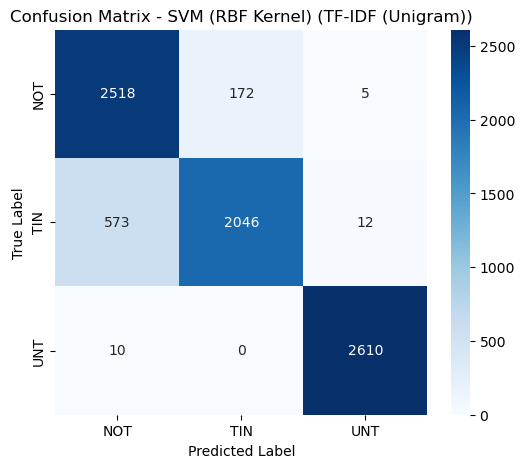


 Applying TF-IDF (Bigram) with SVM (RBF Kernel)
 Accuracy (SMOTE applied - final_text - TF-IDF (Bigram) - SVM (RBF Kernel)): 0.8570

 Classification Report:

              precision    recall  f1-score   support

         NOT       0.79      0.97      0.87      2695
         TIN       0.98      0.61      0.75      2631
         UNT       0.86      1.00      0.92      2620

    accuracy                           0.86      7946
   macro avg       0.88      0.86      0.85      7946
weighted avg       0.88      0.86      0.85      7946



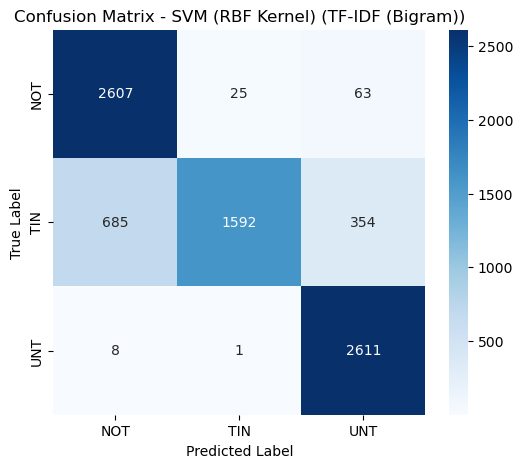


 Applying TF-IDF (Trigram) with SVM (RBF Kernel)
 Accuracy (SMOTE applied - final_text - TF-IDF (Trigram) - SVM (RBF Kernel)): 0.8243

 Classification Report:

              precision    recall  f1-score   support

         NOT       0.80      0.91      0.85      2695
         TIN       1.00      0.56      0.72      2631
         UNT       0.77      1.00      0.87      2620

    accuracy                           0.82      7946
   macro avg       0.86      0.82      0.81      7946
weighted avg       0.86      0.82      0.81      7946



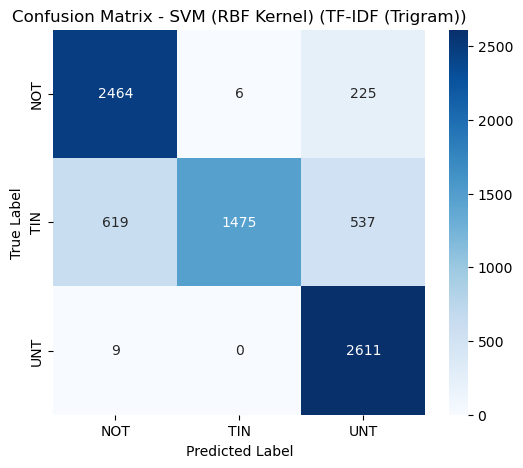


 Applying TF-IDF (N-gram 1-3) with SVM (RBF Kernel)
 Accuracy (SMOTE applied - final_text - TF-IDF (N-gram 1-3) - SVM (RBF Kernel)): 0.8889

 Classification Report:

              precision    recall  f1-score   support

         NOT       0.76      0.99      0.86      2695
         TIN       0.98      0.69      0.81      2631
         UNT       0.99      0.99      0.99      2620

    accuracy                           0.89      7946
   macro avg       0.91      0.89      0.89      7946
weighted avg       0.91      0.89      0.89      7946



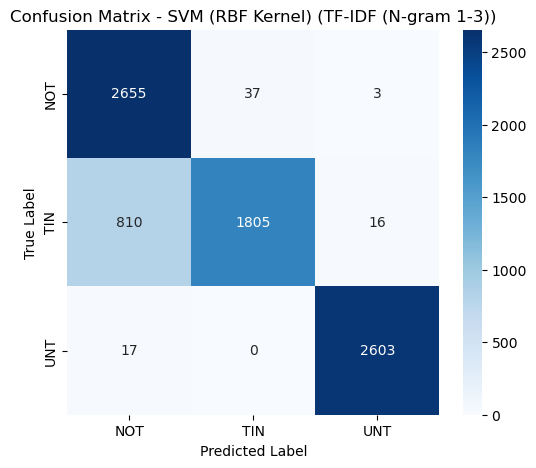


 Applying TF-IDF (Feature Limited) with SVM (RBF Kernel)
 Accuracy (SMOTE applied - final_text - TF-IDF (Feature Limited) - SVM (RBF Kernel)): 0.8738

 Classification Report:

              precision    recall  f1-score   support

         NOT       0.83      0.90      0.86      2695
         TIN       0.90      0.73      0.81      2631
         UNT       0.90      0.99      0.95      2620

    accuracy                           0.87      7946
   macro avg       0.88      0.87      0.87      7946
weighted avg       0.88      0.87      0.87      7946



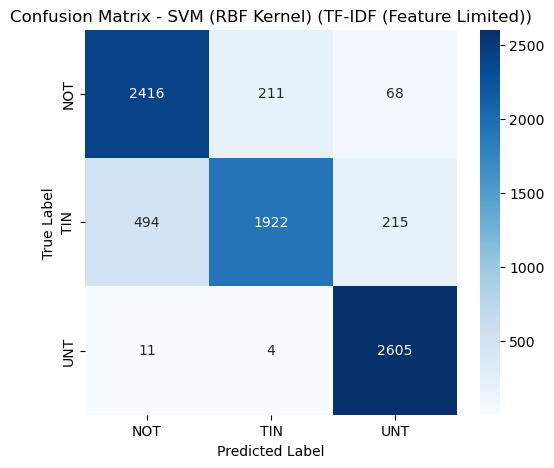


 Applying TF-IDF (Stopword Removed) with SVM (RBF Kernel)
 Accuracy (SMOTE applied - final_text - TF-IDF (Stopword Removed) - SVM (RBF Kernel)): 0.9183

 Classification Report:

              precision    recall  f1-score   support

         NOT       0.83      0.96      0.89      2695
         TIN       0.95      0.80      0.87      2631
         UNT       0.99      1.00      0.99      2620

    accuracy                           0.92      7946
   macro avg       0.93      0.92      0.92      7946
weighted avg       0.92      0.92      0.92      7946



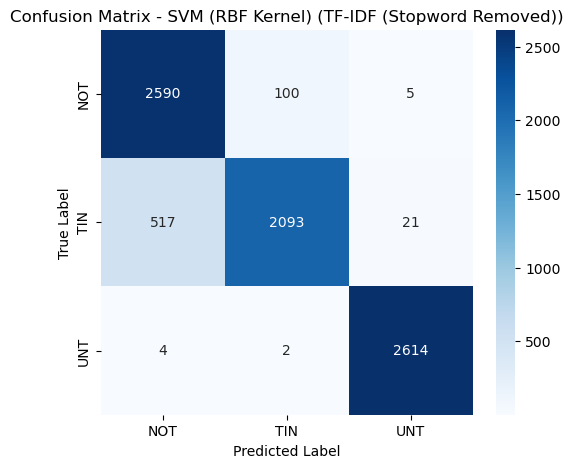


 Applying TF-IDF (Custom Stopwords) with SVM (RBF Kernel)
 Accuracy (SMOTE applied - final_text - TF-IDF (Custom Stopwords) - SVM (RBF Kernel)): 0.8987

 Classification Report:

              precision    recall  f1-score   support

         NOT       0.79      0.97      0.87      2695
         TIN       0.96      0.73      0.83      2631
         UNT       0.99      1.00      1.00      2620

    accuracy                           0.90      7946
   macro avg       0.91      0.90      0.90      7946
weighted avg       0.91      0.90      0.90      7946



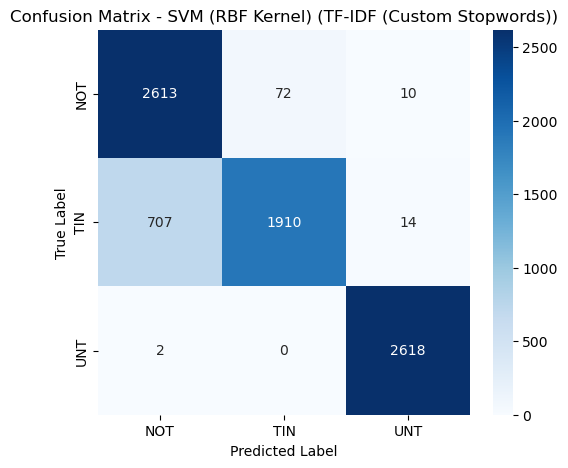


 Applying TF-IDF (Max Features=10000) with SVM (RBF Kernel)
 Accuracy (SMOTE applied - final_text - TF-IDF (Max Features=10000) - SVM (RBF Kernel)): 0.8871

 Classification Report:

              precision    recall  f1-score   support

         NOT       0.83      0.92      0.87      2695
         TIN       0.87      0.79      0.83      2631
         UNT       0.97      0.95      0.96      2620

    accuracy                           0.89      7946
   macro avg       0.89      0.89      0.89      7946
weighted avg       0.89      0.89      0.89      7946



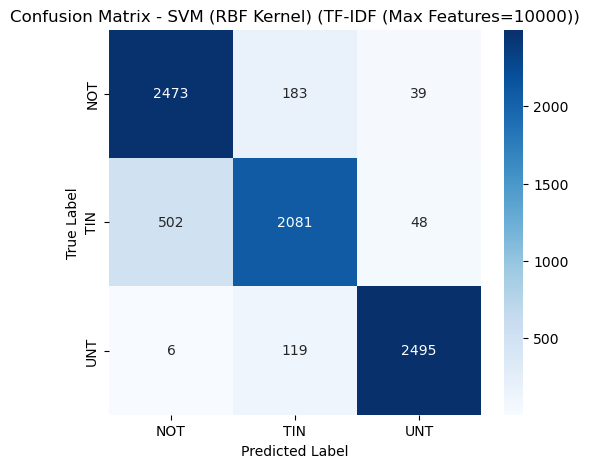


 Applying TF-IDF (Sublinear TF Scaling) with SVM (RBF Kernel)
 Accuracy (SMOTE applied - final_text - TF-IDF (Sublinear TF Scaling) - SVM (RBF Kernel)): 0.9013

 Classification Report:

              precision    recall  f1-score   support

         NOT       0.79      0.98      0.87      2695
         TIN       0.97      0.73      0.83      2631
         UNT       0.99      0.99      0.99      2620

    accuracy                           0.90      7946
   macro avg       0.92      0.90      0.90      7946
weighted avg       0.92      0.90      0.90      7946



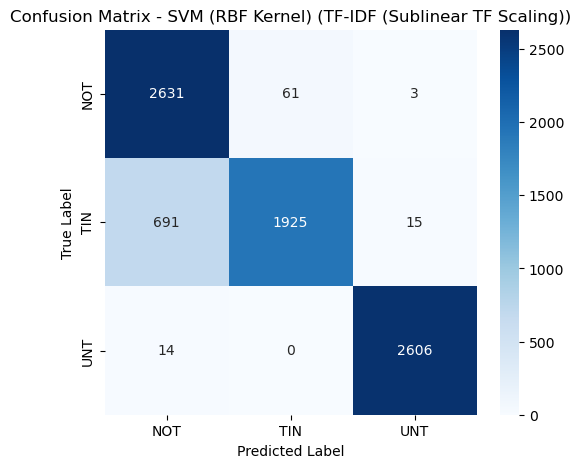


 Applying TF-IDF (Binary Term Presence) with SVM (RBF Kernel)
 Accuracy (SMOTE applied - final_text - TF-IDF (Binary Term Presence) - SVM (RBF Kernel)): 0.8988

 Classification Report:

              precision    recall  f1-score   support

         NOT       0.79      0.97      0.87      2695
         TIN       0.97      0.73      0.83      2631
         UNT       0.99      0.99      0.99      2620

    accuracy                           0.90      7946
   macro avg       0.91      0.90      0.90      7946
weighted avg       0.91      0.90      0.90      7946



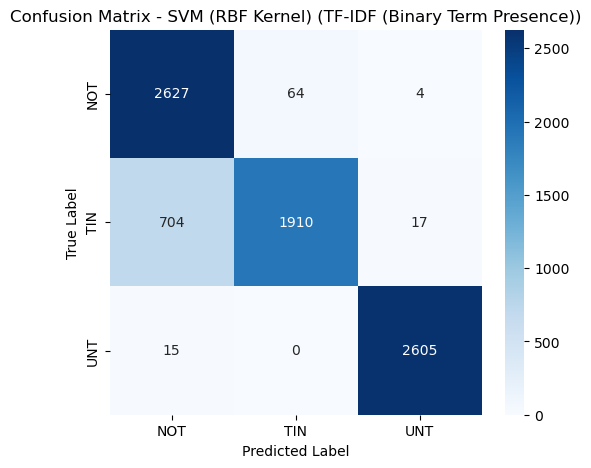


 Applying TF-IDF (L2 Normalization) with SVM (RBF Kernel)
 Accuracy (SMOTE applied - final_text - TF-IDF (L2 Normalization) - SVM (RBF Kernel)): 0.8953

 Classification Report:

              precision    recall  f1-score   support

         NOT       0.78      0.97      0.86      2695
         TIN       0.97      0.72      0.82      2631
         UNT       0.99      1.00      0.99      2620

    accuracy                           0.90      7946
   macro avg       0.91      0.89      0.89      7946
weighted avg       0.91      0.90      0.89      7946



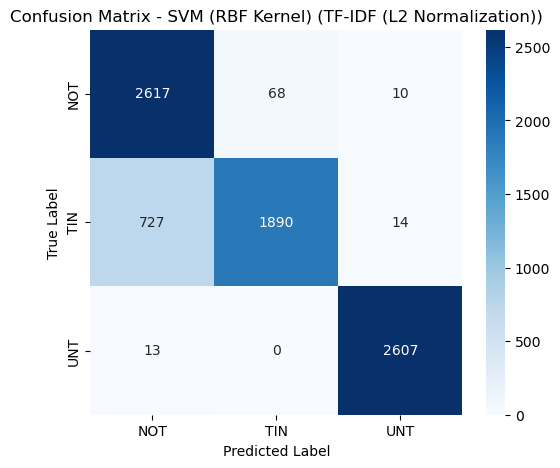


 Applying TF-IDF (L1 Normalization) with SVM (RBF Kernel)
 Accuracy (SMOTE applied - final_text - TF-IDF (L1 Normalization) - SVM (RBF Kernel)): 0.9186

 Classification Report:

              precision    recall  f1-score   support

         NOT       0.85      0.93      0.89      2695
         TIN       0.92      0.83      0.87      2631
         UNT       1.00      1.00      1.00      2620

    accuracy                           0.92      7946
   macro avg       0.92      0.92      0.92      7946
weighted avg       0.92      0.92      0.92      7946



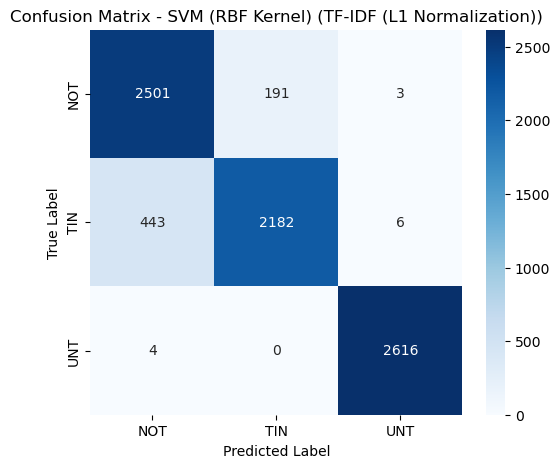


 Applying TF-IDF (No IDF Weighting) with SVM (RBF Kernel)
 Accuracy (SMOTE applied - final_text - TF-IDF (No IDF Weighting) - SVM (RBF Kernel)): 0.8989

 Classification Report:

              precision    recall  f1-score   support

         NOT       0.80      0.94      0.87      2695
         TIN       0.93      0.76      0.83      2631
         UNT       0.99      1.00      0.99      2620

    accuracy                           0.90      7946
   macro avg       0.91      0.90      0.90      7946
weighted avg       0.91      0.90      0.90      7946



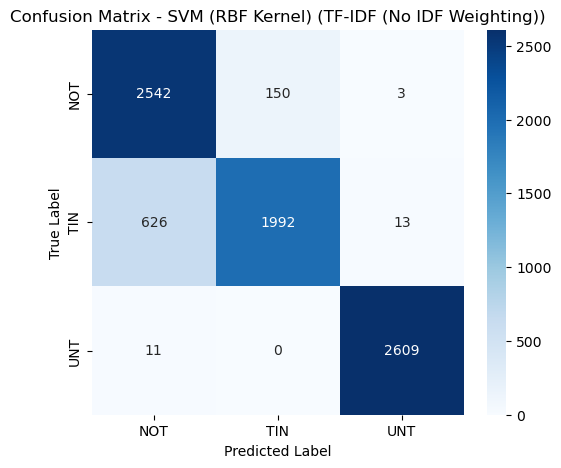


 Applying TF-IDF (Max DF=0.85) with SVM (RBF Kernel)
 Accuracy (SMOTE applied - final_text - TF-IDF (Max DF=0.85) - SVM (RBF Kernel)): 0.8953

 Classification Report:

              precision    recall  f1-score   support

         NOT       0.78      0.97      0.86      2695
         TIN       0.97      0.72      0.82      2631
         UNT       0.99      1.00      0.99      2620

    accuracy                           0.90      7946
   macro avg       0.91      0.89      0.89      7946
weighted avg       0.91      0.90      0.89      7946



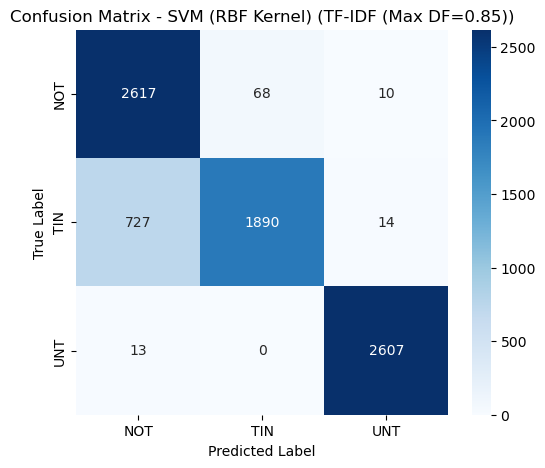


 Applying TF-IDF (Min DF=3) with SVM (RBF Kernel)
 Accuracy (SMOTE applied - final_text - TF-IDF (Min DF=3) - SVM (RBF Kernel)): 0.8877

 Classification Report:

              precision    recall  f1-score   support

         NOT       0.83      0.92      0.87      2695
         TIN       0.87      0.79      0.83      2631
         UNT       0.97      0.95      0.96      2620

    accuracy                           0.89      7946
   macro avg       0.89      0.89      0.89      7946
weighted avg       0.89      0.89      0.89      7946



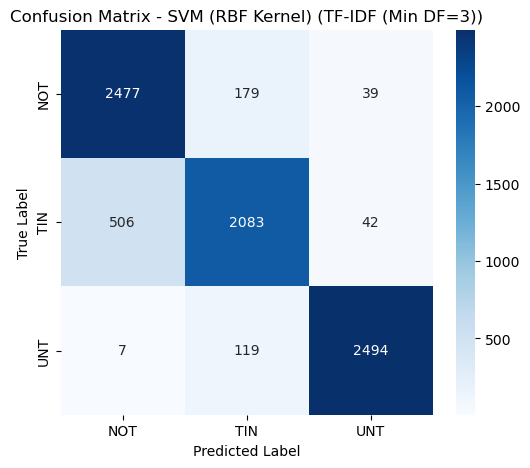


 Applying TF-IDF (Lowercase Disabled) with SVM (RBF Kernel)
 Accuracy (SMOTE applied - final_text - TF-IDF (Lowercase Disabled) - SVM (RBF Kernel)): 0.8953

 Classification Report:

              precision    recall  f1-score   support

         NOT       0.78      0.97      0.86      2695
         TIN       0.97      0.72      0.82      2631
         UNT       0.99      1.00      0.99      2620

    accuracy                           0.90      7946
   macro avg       0.91      0.89      0.89      7946
weighted avg       0.91      0.90      0.89      7946



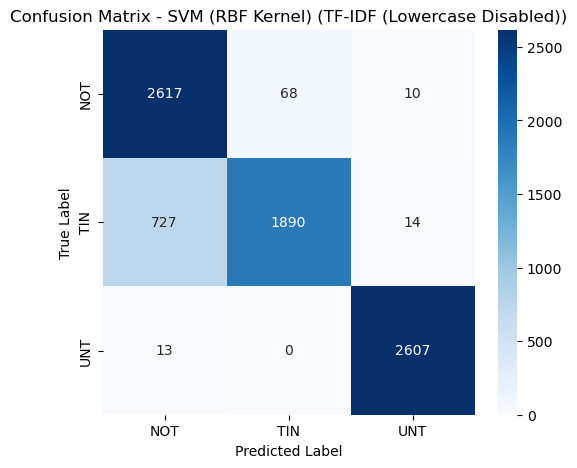

In [ ]:
# SVM (RBF Kernel)
train_and_evaluate("TF-IDF (Unigram)", "SVM (RBF Kernel)")
train_and_evaluate("TF-IDF (Bigram)", "SVM (RBF Kernel)")
train_and_evaluate("TF-IDF (Trigram)", "SVM (RBF Kernel)")
train_and_evaluate("TF-IDF (N-gram 1-3)", "SVM (RBF Kernel)")
train_and_evaluate("TF-IDF (Feature Limited)", "SVM (RBF Kernel)")
train_and_evaluate("TF-IDF (Stopword Removed)", "SVM (RBF Kernel)")
train_and_evaluate("TF-IDF (Custom Stopwords)", "SVM (RBF Kernel)")
train_and_evaluate("TF-IDF (Max Features=10000)", "SVM (RBF Kernel)")
train_and_evaluate("TF-IDF (Sublinear TF Scaling)", "SVM (RBF Kernel)")
train_and_evaluate("TF-IDF (Binary Term Presence)", "SVM (RBF Kernel)")
train_and_evaluate("TF-IDF (L2 Normalization)", "SVM (RBF Kernel)")
train_and_evaluate("TF-IDF (L1 Normalization)", "SVM (RBF Kernel)")
train_and_evaluate("TF-IDF (No IDF Weighting)", "SVM (RBF Kernel)")
train_and_evaluate("TF-IDF (Max DF=0.85)", "SVM (RBF Kernel)")
train_and_evaluate("TF-IDF (Min DF=3)", "SVM (RBF Kernel)")
train_and_evaluate("TF-IDF (Lowercase Disabled)", "SVM (RBF Kernel)")


 Applying TF-IDF (Unigram) with Decision Tree
 Accuracy (SMOTE applied - final_text - TF-IDF (Unigram) - Decision Tree): 0.6107

 Classification Report:

              precision    recall  f1-score   support

         NOT       0.53      0.87      0.66      2695
         TIN       0.56      0.33      0.42      2631
         UNT       0.83      0.62      0.71      2620

    accuracy                           0.61      7946
   macro avg       0.64      0.61      0.60      7946
weighted avg       0.64      0.61      0.60      7946



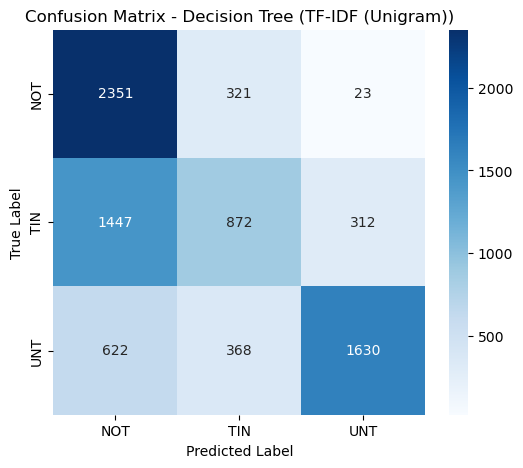


 Applying TF-IDF (Bigram) with Decision Tree
 Accuracy (SMOTE applied - final_text - TF-IDF (Bigram) - Decision Tree): 0.3998

 Classification Report:

              precision    recall  f1-score   support

         NOT       0.37      0.99      0.53      2695
         TIN       0.70      0.04      0.07      2631
         UNT       0.78      0.16      0.26      2620

    accuracy                           0.40      7946
   macro avg       0.62      0.39      0.29      7946
weighted avg       0.61      0.40      0.29      7946



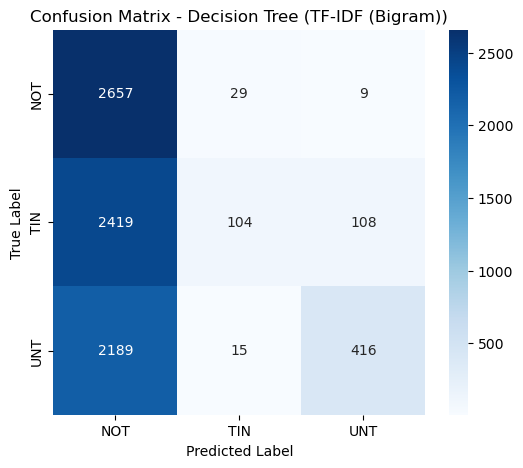


 Applying TF-IDF (Trigram) with Decision Tree
 Accuracy (SMOTE applied - final_text - TF-IDF (Trigram) - Decision Tree): 0.3384

 Classification Report:

              precision    recall  f1-score   support

         NOT       0.00      0.00      0.00      2695
         TIN       0.33      1.00      0.50      2631
         UNT       0.97      0.02      0.04      2620

    accuracy                           0.34      7946
   macro avg       0.43      0.34      0.18      7946
weighted avg       0.43      0.34      0.18      7946



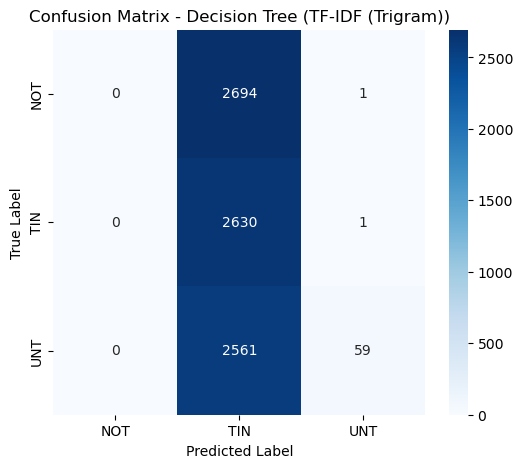


 Applying TF-IDF (N-gram 1-3) with Decision Tree
 Accuracy (SMOTE applied - final_text - TF-IDF (N-gram 1-3) - Decision Tree): 0.6014

 Classification Report:

              precision    recall  f1-score   support

         NOT       0.52      0.87      0.65      2695
         TIN       0.55      0.33      0.41      2631
         UNT       0.82      0.61      0.70      2620

    accuracy                           0.60      7946
   macro avg       0.63      0.60      0.59      7946
weighted avg       0.63      0.60      0.59      7946



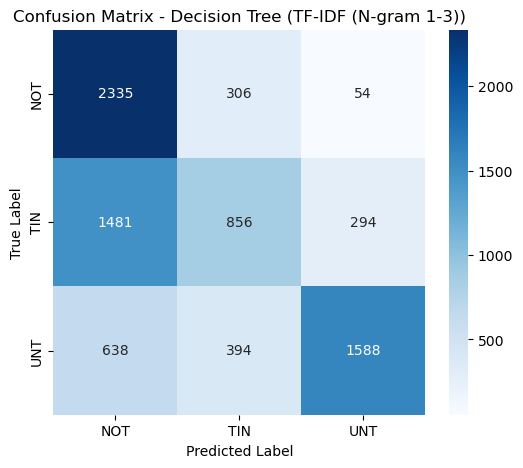


 Applying TF-IDF (Feature Limited) with Decision Tree
 Accuracy (SMOTE applied - final_text - TF-IDF (Feature Limited) - Decision Tree): 0.5690

 Classification Report:

              precision    recall  f1-score   support

         NOT       0.50      0.92      0.65      2695
         TIN       0.56      0.31      0.40      2631
         UNT       0.78      0.47      0.59      2620

    accuracy                           0.57      7946
   macro avg       0.62      0.57      0.54      7946
weighted avg       0.62      0.57      0.55      7946



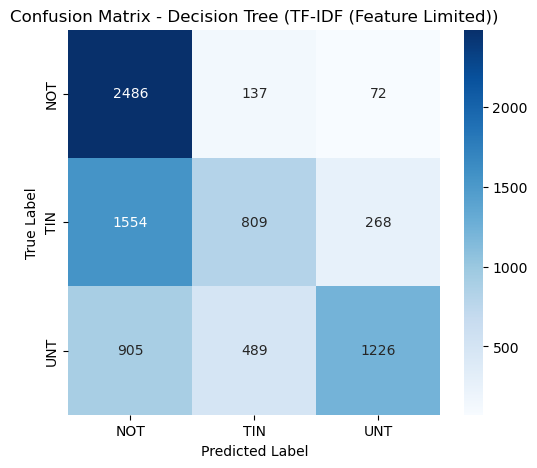


 Applying TF-IDF (Stopword Removed) with Decision Tree
 Accuracy (SMOTE applied - final_text - TF-IDF (Stopword Removed) - Decision Tree): 0.5824

 Classification Report:

              precision    recall  f1-score   support

         NOT       0.49      0.93      0.64      2695
         TIN       0.52      0.20      0.29      2631
         UNT       0.90      0.61      0.72      2620

    accuracy                           0.58      7946
   macro avg       0.64      0.58      0.55      7946
weighted avg       0.63      0.58      0.55      7946



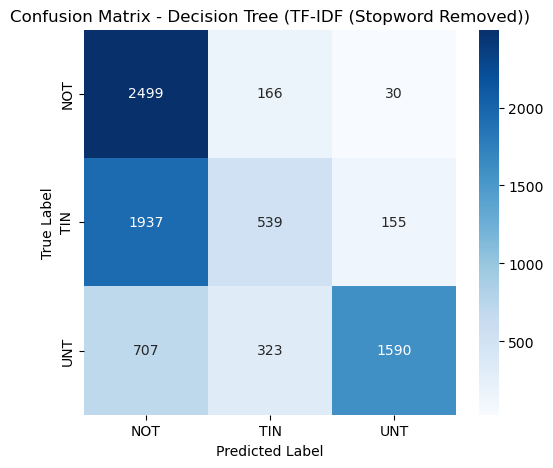


 Applying TF-IDF (Custom Stopwords) with Decision Tree
 Accuracy (SMOTE applied - final_text - TF-IDF (Custom Stopwords) - Decision Tree): 0.5919

 Classification Report:

              precision    recall  f1-score   support

         NOT       0.50      0.94      0.65      2695
         TIN       0.58      0.20      0.30      2631
         UNT       0.82      0.63      0.71      2620

    accuracy                           0.59      7946
   macro avg       0.64      0.59      0.56      7946
weighted avg       0.63      0.59      0.56      7946



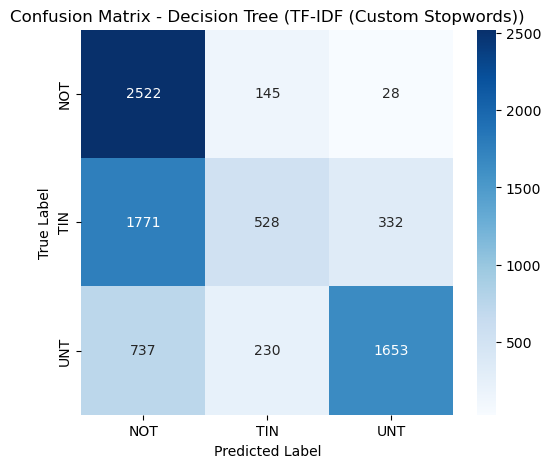


 Applying TF-IDF (Max Features=10000) with Decision Tree
 Accuracy (SMOTE applied - final_text - TF-IDF (Max Features=10000) - Decision Tree): 0.5861

 Classification Report:

              precision    recall  f1-score   support

         NOT       0.53      0.76      0.62      2695
         TIN       0.51      0.45      0.48      2631
         UNT       0.83      0.55      0.66      2620

    accuracy                           0.59      7946
   macro avg       0.62      0.58      0.59      7946
weighted avg       0.62      0.59      0.59      7946



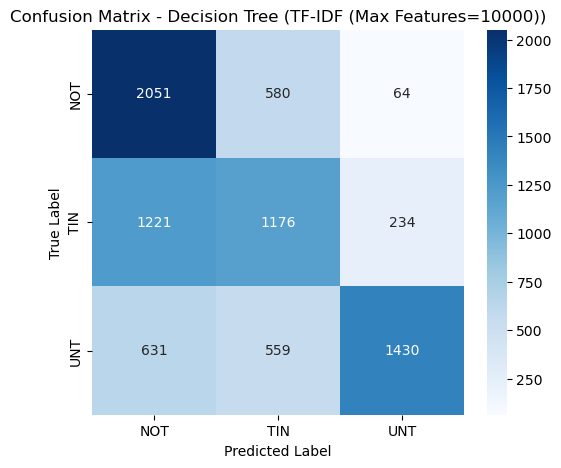


 Applying TF-IDF (Sublinear TF Scaling) with Decision Tree
 Accuracy (SMOTE applied - final_text - TF-IDF (Sublinear TF Scaling) - Decision Tree): 0.6135

 Classification Report:

              precision    recall  f1-score   support

         NOT       0.53      0.87      0.66      2695
         TIN       0.58      0.30      0.40      2631
         UNT       0.81      0.66      0.72      2620

    accuracy                           0.61      7946
   macro avg       0.64      0.61      0.59      7946
weighted avg       0.64      0.61      0.59      7946



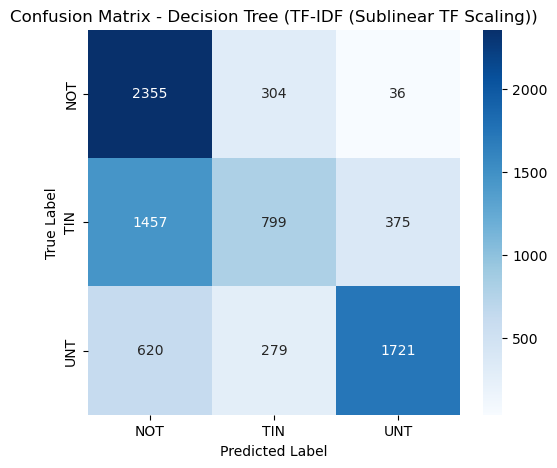


 Applying TF-IDF (Binary Term Presence) with Decision Tree
 Accuracy (SMOTE applied - final_text - TF-IDF (Binary Term Presence) - Decision Tree): 0.6168

 Classification Report:

              precision    recall  f1-score   support

         NOT       0.54      0.88      0.67      2695
         TIN       0.58      0.34      0.43      2631
         UNT       0.82      0.63      0.71      2620

    accuracy                           0.62      7946
   macro avg       0.64      0.61      0.60      7946
weighted avg       0.64      0.62      0.60      7946



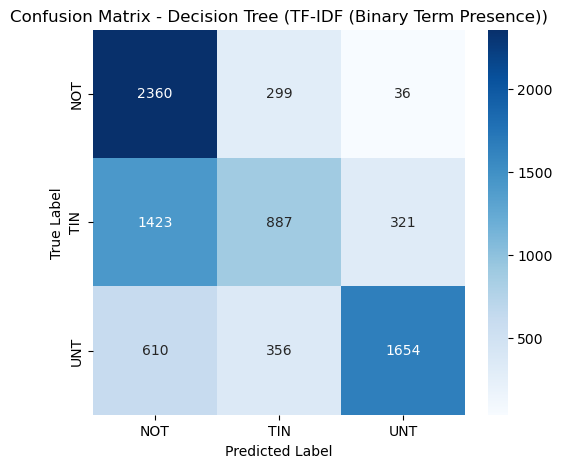


 Applying TF-IDF (L2 Normalization) with Decision Tree
 Accuracy (SMOTE applied - final_text - TF-IDF (L2 Normalization) - Decision Tree): 0.5955

 Classification Report:

              precision    recall  f1-score   support

         NOT       0.50      0.94      0.65      2695
         TIN       0.59      0.20      0.30      2631
         UNT       0.83      0.64      0.72      2620

    accuracy                           0.60      7946
   macro avg       0.64      0.59      0.56      7946
weighted avg       0.64      0.60      0.56      7946



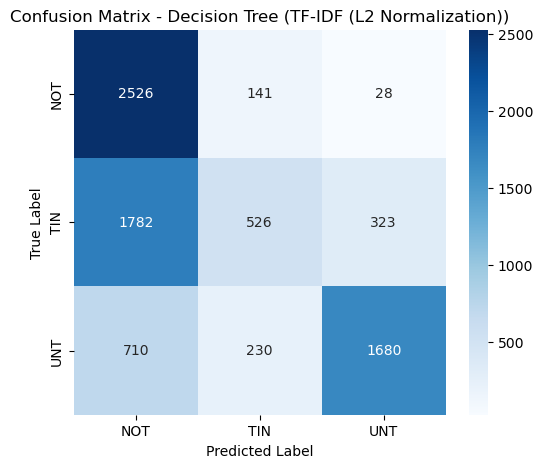


 Applying TF-IDF (L1 Normalization) with Decision Tree
 Accuracy (SMOTE applied - final_text - TF-IDF (L1 Normalization) - Decision Tree): 0.7874

 Classification Report:

              precision    recall  f1-score   support

         NOT       0.64      0.94      0.76      2695
         TIN       0.86      0.52      0.64      2631
         UNT       0.98      0.90      0.94      2620

    accuracy                           0.79      7946
   macro avg       0.83      0.79      0.78      7946
weighted avg       0.82      0.79      0.78      7946



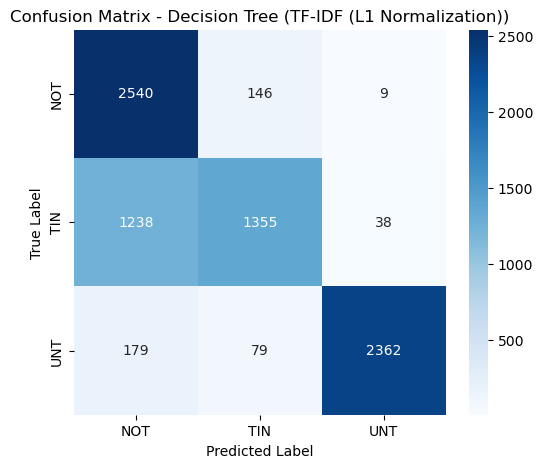


 Applying TF-IDF (No IDF Weighting) with Decision Tree
 Accuracy (SMOTE applied - final_text - TF-IDF (No IDF Weighting) - Decision Tree): 0.6314

 Classification Report:

              precision    recall  f1-score   support

         NOT       0.51      0.94      0.66      2695
         TIN       0.72      0.29      0.41      2631
         UNT       0.91      0.66      0.76      2620

    accuracy                           0.63      7946
   macro avg       0.71      0.63      0.61      7946
weighted avg       0.71      0.63      0.61      7946



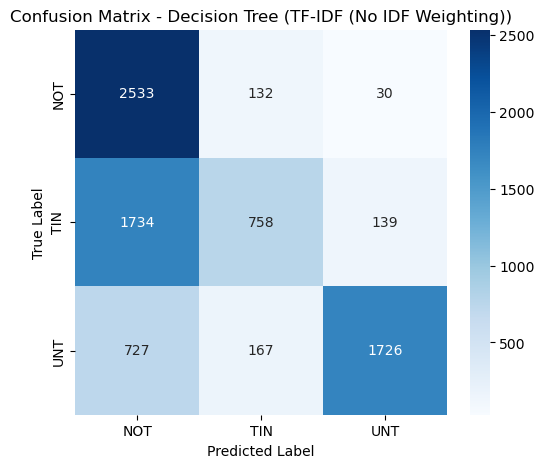


 Applying TF-IDF (Max DF=0.85) with Decision Tree
 Accuracy (SMOTE applied - final_text - TF-IDF (Max DF=0.85) - Decision Tree): 0.5955

 Classification Report:

              precision    recall  f1-score   support

         NOT       0.50      0.94      0.65      2695
         TIN       0.59      0.20      0.30      2631
         UNT       0.83      0.64      0.72      2620

    accuracy                           0.60      7946
   macro avg       0.64      0.59      0.56      7946
weighted avg       0.64      0.60      0.56      7946



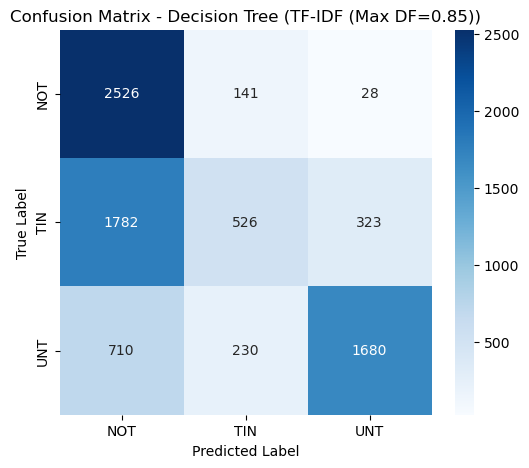


 Applying TF-IDF (Min DF=3) with Decision Tree
 Accuracy (SMOTE applied - final_text - TF-IDF (Min DF=3) - Decision Tree): 0.5848

 Classification Report:

              precision    recall  f1-score   support

         NOT       0.52      0.76      0.62      2695
         TIN       0.50      0.48      0.49      2631
         UNT       0.88      0.51      0.65      2620

    accuracy                           0.58      7946
   macro avg       0.64      0.58      0.59      7946
weighted avg       0.63      0.58      0.59      7946



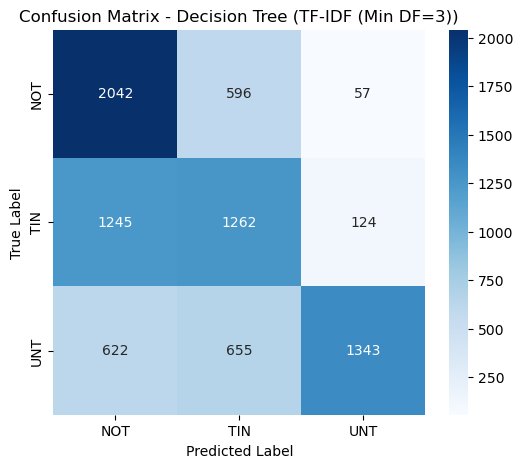


 Applying TF-IDF (Lowercase Disabled) with Decision Tree
 Accuracy (SMOTE applied - final_text - TF-IDF (Lowercase Disabled) - Decision Tree): 0.5955

 Classification Report:

              precision    recall  f1-score   support

         NOT       0.50      0.94      0.65      2695
         TIN       0.59      0.20      0.30      2631
         UNT       0.83      0.64      0.72      2620

    accuracy                           0.60      7946
   macro avg       0.64      0.59      0.56      7946
weighted avg       0.64      0.60      0.56      7946



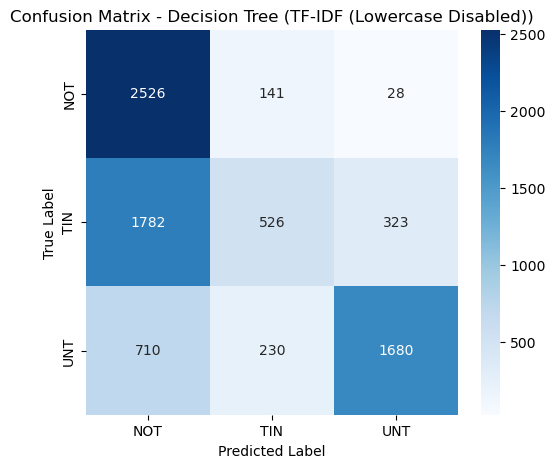

In [ ]:
# Decision Tree
train_and_evaluate("TF-IDF (Unigram)", "Decision Tree")
train_and_evaluate("TF-IDF (Bigram)", "Decision Tree")
train_and_evaluate("TF-IDF (Trigram)", "Decision Tree")
train_and_evaluate("TF-IDF (N-gram 1-3)", "Decision Tree")
train_and_evaluate("TF-IDF (Feature Limited)", "Decision Tree")
train_and_evaluate("TF-IDF (Stopword Removed)", "Decision Tree")
train_and_evaluate("TF-IDF (Custom Stopwords)", "Decision Tree")
train_and_evaluate("TF-IDF (Max Features=10000)", "Decision Tree")
train_and_evaluate("TF-IDF (Sublinear TF Scaling)", "Decision Tree")
train_and_evaluate("TF-IDF (Binary Term Presence)", "Decision Tree")
train_and_evaluate("TF-IDF (L2 Normalization)", "Decision Tree")
train_and_evaluate("TF-IDF (L1 Normalization)", "Decision Tree")
train_and_evaluate("TF-IDF (No IDF Weighting)", "Decision Tree")
train_and_evaluate("TF-IDF (Max DF=0.85)", "Decision Tree")
train_and_evaluate("TF-IDF (Min DF=3)", "Decision Tree")
train_and_evaluate("TF-IDF (Lowercase Disabled)", "Decision Tree")


 Applying TF-IDF (Unigram) with Naïve Bayes
 Accuracy (SMOTE applied - final_text - TF-IDF (Unigram) - Naïve Bayes): 0.7843

 Classification Report:

              precision    recall  f1-score   support

         NOT       0.85      0.59      0.70      2695
         TIN       0.73      0.78      0.75      2631
         UNT       0.80      0.98      0.88      2620

    accuracy                           0.78      7946
   macro avg       0.79      0.79      0.78      7946
weighted avg       0.79      0.78      0.78      7946



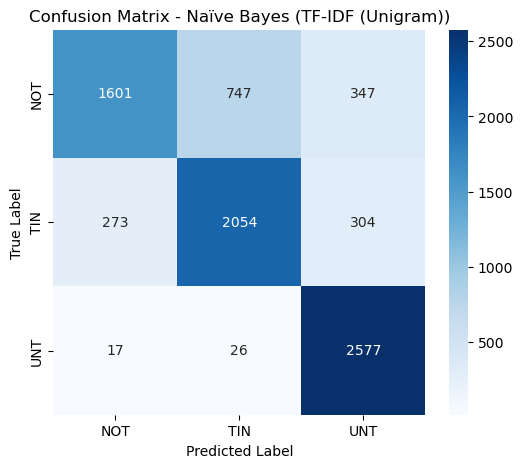


 Applying TF-IDF (Bigram) with Naïve Bayes
 Accuracy (SMOTE applied - final_text - TF-IDF (Bigram) - Naïve Bayes): 0.7564

 Classification Report:

              precision    recall  f1-score   support

         NOT       0.82      0.49      0.62      2695
         TIN       0.77      0.79      0.78      2631
         UNT       0.71      0.99      0.83      2620

    accuracy                           0.76      7946
   macro avg       0.77      0.76      0.74      7946
weighted avg       0.77      0.76      0.74      7946



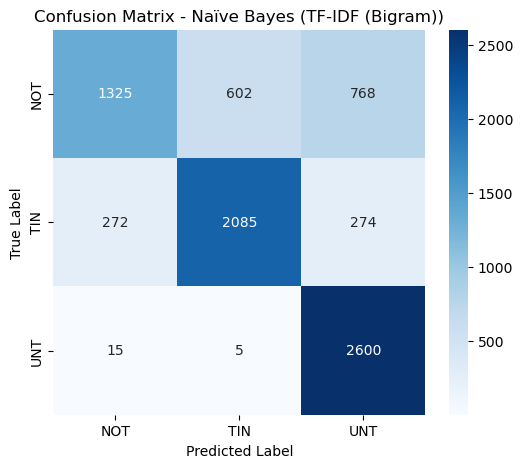


 Applying TF-IDF (Trigram) with Naïve Bayes
 Accuracy (SMOTE applied - final_text - TF-IDF (Trigram) - Naïve Bayes): 0.5917

 Classification Report:

              precision    recall  f1-score   support

         NOT       0.83      0.09      0.16      2695
         TIN       0.92      0.70      0.80      2631
         UNT       0.46      1.00      0.63      2620

    accuracy                           0.59      7946
   macro avg       0.74      0.60      0.53      7946
weighted avg       0.74      0.59      0.53      7946



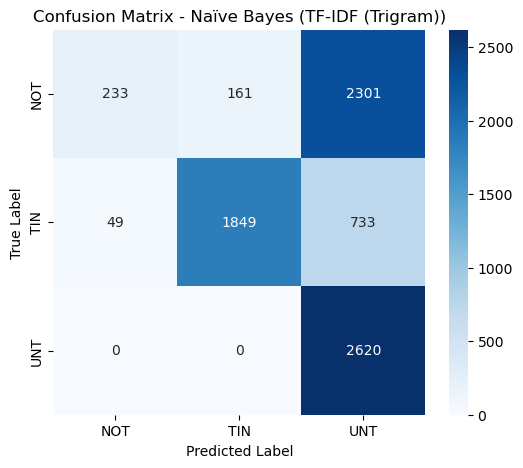


 Applying TF-IDF (N-gram 1-3) with Naïve Bayes
 Accuracy (SMOTE applied - final_text - TF-IDF (N-gram 1-3) - Naïve Bayes): 0.8334

 Classification Report:

              precision    recall  f1-score   support

         NOT       0.92      0.61      0.74      2695
         TIN       0.76      0.89      0.82      2631
         UNT       0.86      1.00      0.93      2620

    accuracy                           0.83      7946
   macro avg       0.85      0.84      0.83      7946
weighted avg       0.85      0.83      0.83      7946



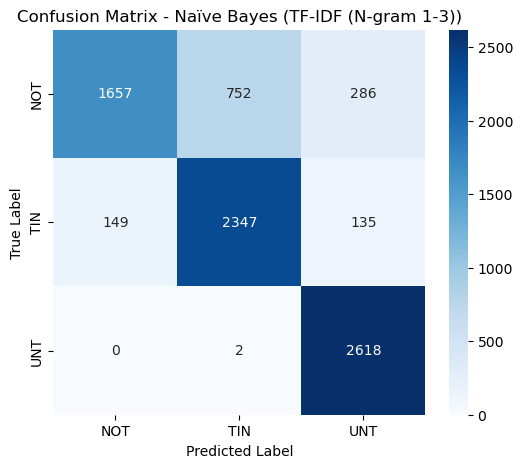


 Applying TF-IDF (Feature Limited) with Naïve Bayes
 Accuracy (SMOTE applied - final_text - TF-IDF (Feature Limited) - Naïve Bayes): 0.7426

 Classification Report:

              precision    recall  f1-score   support

         NOT       0.73      0.64      0.69      2695
         TIN       0.72      0.65      0.68      2631
         UNT       0.77      0.94      0.85      2620

    accuracy                           0.74      7946
   macro avg       0.74      0.74      0.74      7946
weighted avg       0.74      0.74      0.74      7946



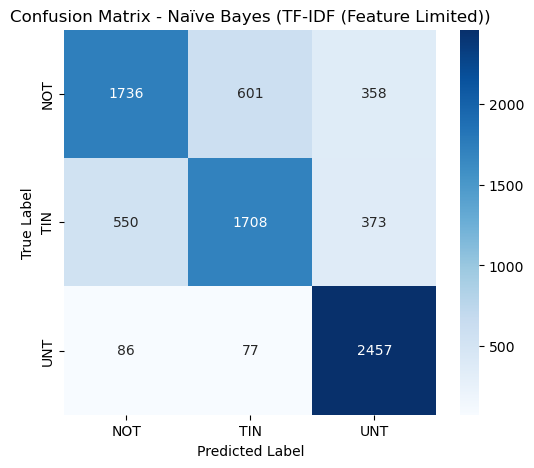


 Applying TF-IDF (Stopword Removed) with Naïve Bayes
 Accuracy (SMOTE applied - final_text - TF-IDF (Stopword Removed) - Naïve Bayes): 0.8233

 Classification Report:

              precision    recall  f1-score   support

         NOT       0.88      0.65      0.75      2695
         TIN       0.79      0.82      0.80      2631
         UNT       0.82      1.00      0.90      2620

    accuracy                           0.82      7946
   macro avg       0.83      0.82      0.82      7946
weighted avg       0.83      0.82      0.82      7946



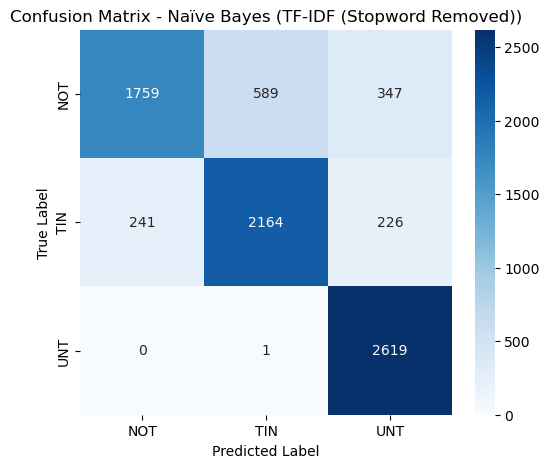


 Applying TF-IDF (Custom Stopwords) with Naïve Bayes
 Accuracy (SMOTE applied - final_text - TF-IDF (Custom Stopwords) - Naïve Bayes): 0.8241

 Classification Report:

              precision    recall  f1-score   support

         NOT       0.90      0.61      0.73      2695
         TIN       0.75      0.87      0.80      2631
         UNT       0.86      1.00      0.92      2620

    accuracy                           0.82      7946
   macro avg       0.83      0.83      0.82      7946
weighted avg       0.84      0.82      0.82      7946



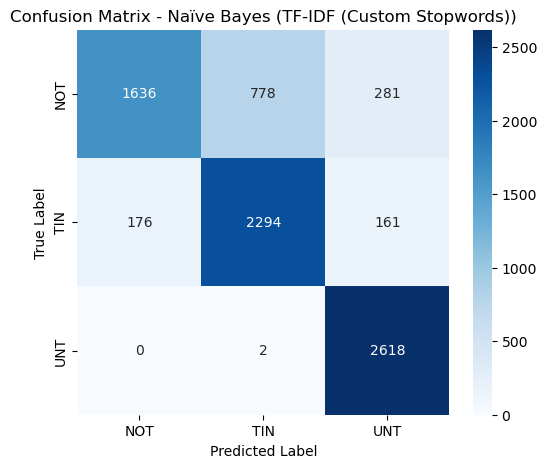


 Applying TF-IDF (Max Features=10000) with Naïve Bayes
 Accuracy (SMOTE applied - final_text - TF-IDF (Max Features=10000) - Naïve Bayes): 0.7683

 Classification Report:

              precision    recall  f1-score   support

         NOT       0.76      0.66      0.71      2695
         TIN       0.74      0.67      0.70      2631
         UNT       0.79      0.98      0.88      2620

    accuracy                           0.77      7946
   macro avg       0.77      0.77      0.76      7946
weighted avg       0.77      0.77      0.76      7946



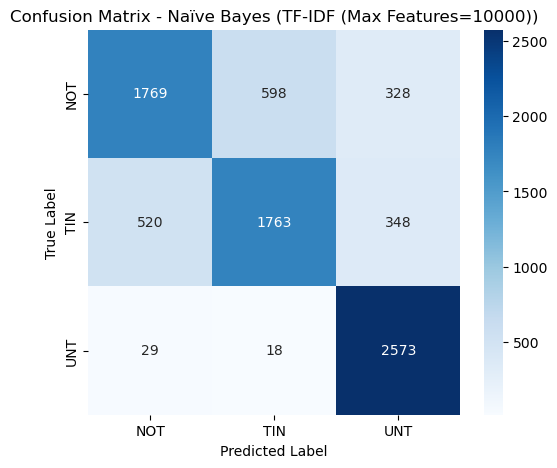


 Applying TF-IDF (Sublinear TF Scaling) with Naïve Bayes
 Accuracy (SMOTE applied - final_text - TF-IDF (Sublinear TF Scaling) - Naïve Bayes): 0.8263

 Classification Report:

              precision    recall  f1-score   support

         NOT       0.91      0.61      0.73      2695
         TIN       0.75      0.87      0.81      2631
         UNT       0.85      1.00      0.92      2620

    accuracy                           0.83      7946
   macro avg       0.84      0.83      0.82      7946
weighted avg       0.84      0.83      0.82      7946



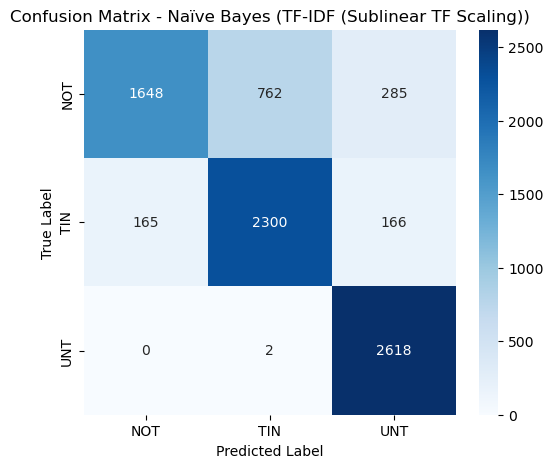


 Applying TF-IDF (Binary Term Presence) with Naïve Bayes
 Accuracy (SMOTE applied - final_text - TF-IDF (Binary Term Presence) - Naïve Bayes): 0.8319

 Classification Report:

              precision    recall  f1-score   support

         NOT       0.91      0.62      0.74      2695
         TIN       0.76      0.88      0.81      2631
         UNT       0.86      1.00      0.92      2620

    accuracy                           0.83      7946
   macro avg       0.84      0.83      0.83      7946
weighted avg       0.84      0.83      0.82      7946



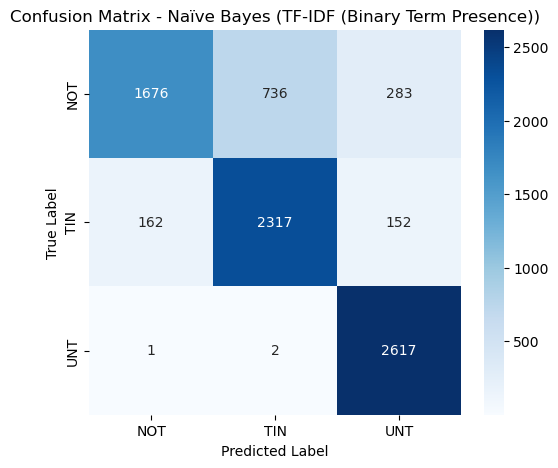


 Applying TF-IDF (L2 Normalization) with Naïve Bayes
 Accuracy (SMOTE applied - final_text - TF-IDF (L2 Normalization) - Naïve Bayes): 0.8229

 Classification Report:

              precision    recall  f1-score   support

         NOT       0.91      0.60      0.72      2695
         TIN       0.75      0.87      0.80      2631
         UNT       0.85      1.00      0.92      2620

    accuracy                           0.82      7946
   macro avg       0.84      0.82      0.82      7946
weighted avg       0.84      0.82      0.81      7946



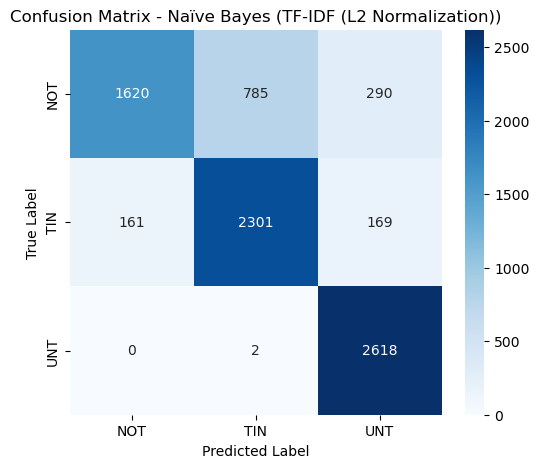


 Applying TF-IDF (L1 Normalization) with Naïve Bayes
 Accuracy (SMOTE applied - final_text - TF-IDF (L1 Normalization) - Naïve Bayes): 0.8207

 Classification Report:

              precision    recall  f1-score   support

         NOT       0.85      0.67      0.75      2695
         TIN       0.79      0.81      0.80      2631
         UNT       0.83      0.99      0.90      2620

    accuracy                           0.82      7946
   macro avg       0.82      0.82      0.82      7946
weighted avg       0.82      0.82      0.82      7946



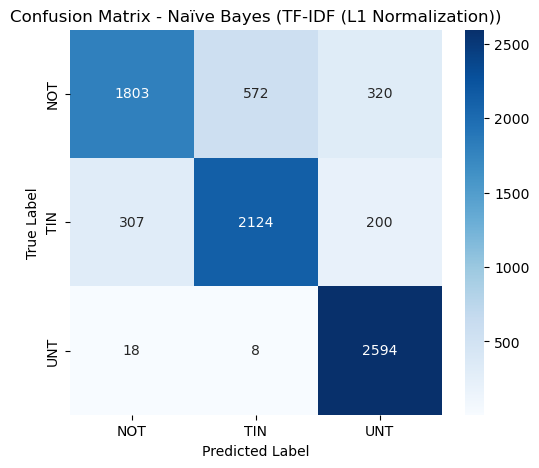


 Applying TF-IDF (No IDF Weighting) with Naïve Bayes
 Accuracy (SMOTE applied - final_text - TF-IDF (No IDF Weighting) - Naïve Bayes): 0.8090

 Classification Report:

              precision    recall  f1-score   support

         NOT       0.88      0.59      0.70      2695
         TIN       0.72      0.85      0.78      2631
         UNT       0.85      0.99      0.92      2620

    accuracy                           0.81      7946
   macro avg       0.82      0.81      0.80      7946
weighted avg       0.82      0.81      0.80      7946



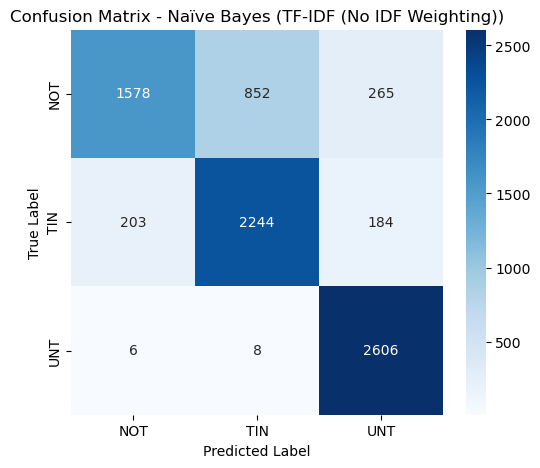


 Applying TF-IDF (Max DF=0.85) with Naïve Bayes
 Accuracy (SMOTE applied - final_text - TF-IDF (Max DF=0.85) - Naïve Bayes): 0.8229

 Classification Report:

              precision    recall  f1-score   support

         NOT       0.91      0.60      0.72      2695
         TIN       0.75      0.87      0.80      2631
         UNT       0.85      1.00      0.92      2620

    accuracy                           0.82      7946
   macro avg       0.84      0.82      0.82      7946
weighted avg       0.84      0.82      0.81      7946



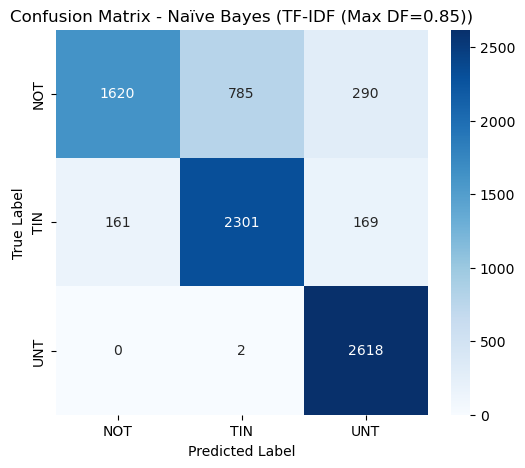


 Applying TF-IDF (Min DF=3) with Naïve Bayes
 Accuracy (SMOTE applied - final_text - TF-IDF (Min DF=3) - Naïve Bayes): 0.7678

 Classification Report:

              precision    recall  f1-score   support

         NOT       0.76      0.65      0.70      2695
         TIN       0.74      0.67      0.70      2631
         UNT       0.79      0.98      0.88      2620

    accuracy                           0.77      7946
   macro avg       0.76      0.77      0.76      7946
weighted avg       0.76      0.77      0.76      7946



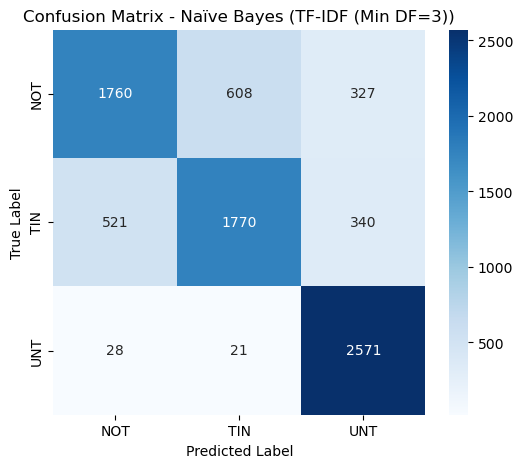


 Applying TF-IDF (Lowercase Disabled) with Naïve Bayes
 Accuracy (SMOTE applied - final_text - TF-IDF (Lowercase Disabled) - Naïve Bayes): 0.8229

 Classification Report:

              precision    recall  f1-score   support

         NOT       0.91      0.60      0.72      2695
         TIN       0.75      0.87      0.80      2631
         UNT       0.85      1.00      0.92      2620

    accuracy                           0.82      7946
   macro avg       0.84      0.82      0.82      7946
weighted avg       0.84      0.82      0.81      7946



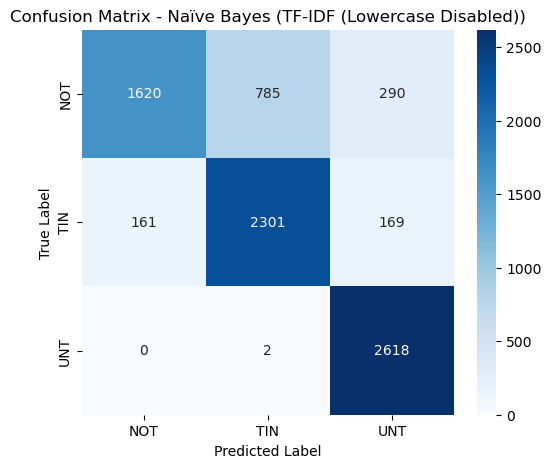

In [ ]:
# Naïve Bayes
train_and_evaluate("TF-IDF (Unigram)", "Naïve Bayes")
train_and_evaluate("TF-IDF (Bigram)", "Naïve Bayes")
train_and_evaluate("TF-IDF (Trigram)", "Naïve Bayes")
train_and_evaluate("TF-IDF (N-gram 1-3)", "Naïve Bayes")
train_and_evaluate("TF-IDF (Feature Limited)", "Naïve Bayes")
train_and_evaluate("TF-IDF (Stopword Removed)", "Naïve Bayes")
train_and_evaluate("TF-IDF (Custom Stopwords)", "Naïve Bayes")
train_and_evaluate("TF-IDF (Max Features=10000)", "Naïve Bayes")
train_and_evaluate("TF-IDF (Sublinear TF Scaling)", "Naïve Bayes")
train_and_evaluate("TF-IDF (Binary Term Presence)", "Naïve Bayes")
train_and_evaluate("TF-IDF (L2 Normalization)", "Naïve Bayes")
train_and_evaluate("TF-IDF (L1 Normalization)", "Naïve Bayes")
train_and_evaluate("TF-IDF (No IDF Weighting)", "Naïve Bayes")
train_and_evaluate("TF-IDF (Max DF=0.85)", "Naïve Bayes")
train_and_evaluate("TF-IDF (Min DF=3)", "Naïve Bayes")
train_and_evaluate("TF-IDF (Lowercase Disabled)", "Naïve Bayes")


 Applying TF-IDF (Unigram) with Random Forest
 Accuracy (SMOTE applied - final_text - TF-IDF (Unigram) - Random Forest): 0.8955

 Classification Report:

              precision    recall  f1-score   support

         NOT       0.82      0.91      0.86      2695
         TIN       0.90      0.79      0.84      2631
         UNT       0.99      0.99      0.99      2620

    accuracy                           0.90      7946
   macro avg       0.90      0.90      0.90      7946
weighted avg       0.90      0.90      0.90      7946



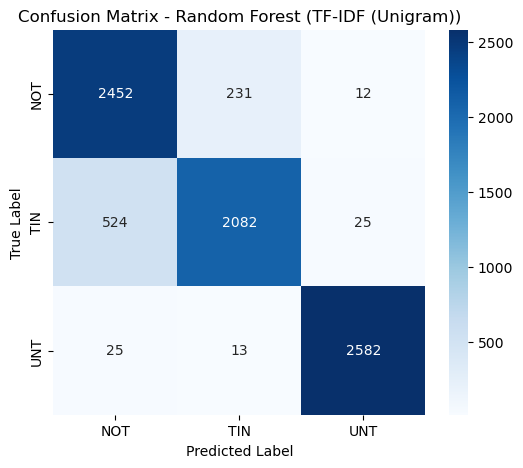


 Applying TF-IDF (Bigram) with Random Forest
 Accuracy (SMOTE applied - final_text - TF-IDF (Bigram) - Random Forest): 0.7598

 Classification Report:

              precision    recall  f1-score   support

         NOT       0.81      0.59      0.68      2695
         TIN       0.85      0.71      0.77      2631
         UNT       0.68      0.99      0.81      2620

    accuracy                           0.76      7946
   macro avg       0.78      0.76      0.75      7946
weighted avg       0.78      0.76      0.75      7946



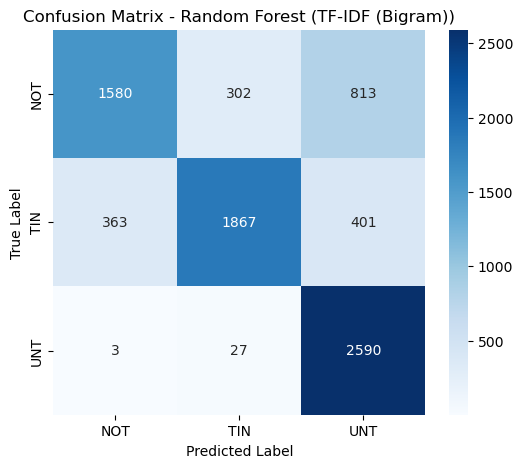


 Applying TF-IDF (Trigram) with Random Forest
 Accuracy (SMOTE applied - final_text - TF-IDF (Trigram) - Random Forest): 0.5775

 Classification Report:

              precision    recall  f1-score   support

         NOT       0.76      0.16      0.26      2695
         TIN       0.95      0.59      0.73      2631
         UNT       0.45      1.00      0.62      2620

    accuracy                           0.58      7946
   macro avg       0.72      0.58      0.54      7946
weighted avg       0.72      0.58      0.53      7946



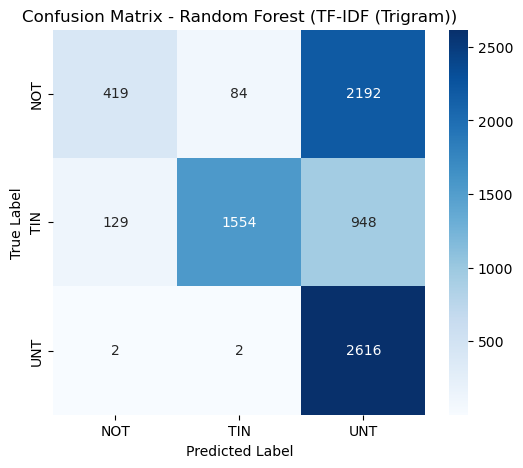


 Applying TF-IDF (N-gram 1-3) with Random Forest
 Accuracy (SMOTE applied - final_text - TF-IDF (N-gram 1-3) - Random Forest): 0.8974

 Classification Report:

              precision    recall  f1-score   support

         NOT       0.80      0.95      0.87      2695
         TIN       0.94      0.75      0.84      2631
         UNT       0.99      0.98      0.99      2620

    accuracy                           0.90      7946
   macro avg       0.91      0.90      0.90      7946
weighted avg       0.91      0.90      0.90      7946



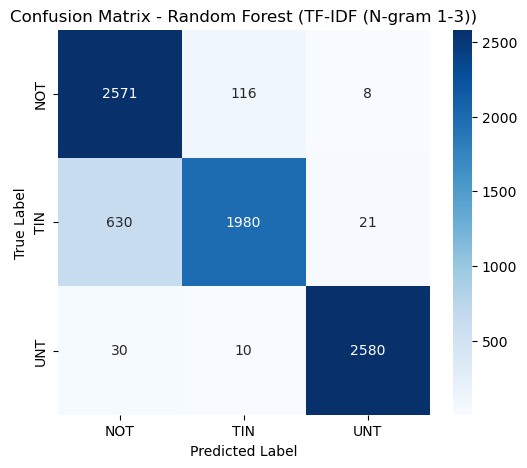


 Applying TF-IDF (Feature Limited) with Random Forest
 Accuracy (SMOTE applied - final_text - TF-IDF (Feature Limited) - Random Forest): 0.8563

 Classification Report:

              precision    recall  f1-score   support

         NOT       0.80      0.86      0.83      2695
         TIN       0.85      0.74      0.79      2631
         UNT       0.93      0.97      0.95      2620

    accuracy                           0.86      7946
   macro avg       0.86      0.86      0.85      7946
weighted avg       0.86      0.86      0.85      7946



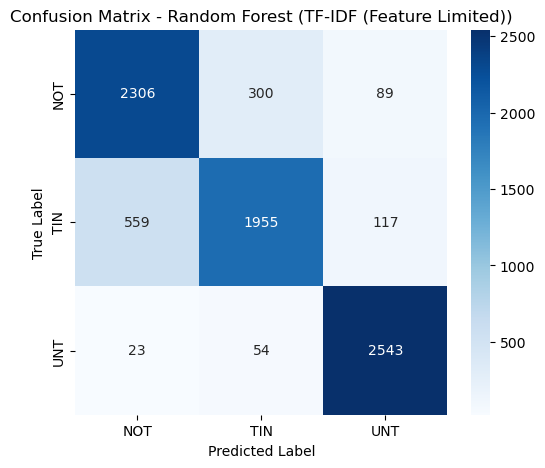


 Applying TF-IDF (Stopword Removed) with Random Forest
 Accuracy (SMOTE applied - final_text - TF-IDF (Stopword Removed) - Random Forest): 0.8920

 Classification Report:

              precision    recall  f1-score   support

         NOT       0.81      0.90      0.85      2695
         TIN       0.88      0.79      0.83      2631
         UNT       0.99      0.99      0.99      2620

    accuracy                           0.89      7946
   macro avg       0.90      0.89      0.89      7946
weighted avg       0.89      0.89      0.89      7946



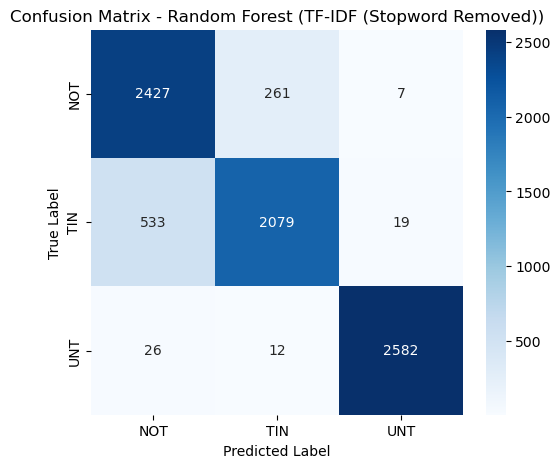


 Applying TF-IDF (Custom Stopwords) with Random Forest
 Accuracy (SMOTE applied - final_text - TF-IDF (Custom Stopwords) - Random Forest): 0.8963

 Classification Report:

              precision    recall  f1-score   support

         NOT       0.80      0.94      0.86      2695
         TIN       0.93      0.76      0.84      2631
         UNT       0.99      0.98      0.99      2620

    accuracy                           0.90      7946
   macro avg       0.91      0.90      0.90      7946
weighted avg       0.90      0.90      0.90      7946



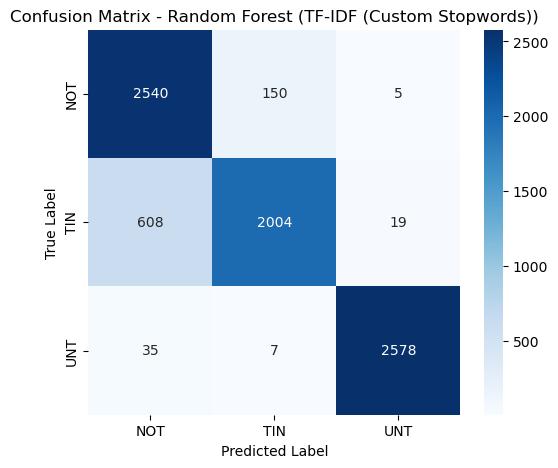


 Applying TF-IDF (Max Features=10000) with Random Forest
 Accuracy (SMOTE applied - final_text - TF-IDF (Max Features=10000) - Random Forest): 0.8696

 Classification Report:

              precision    recall  f1-score   support

         NOT       0.81      0.87      0.84      2695
         TIN       0.85      0.77      0.81      2631
         UNT       0.95      0.97      0.96      2620

    accuracy                           0.87      7946
   macro avg       0.87      0.87      0.87      7946
weighted avg       0.87      0.87      0.87      7946



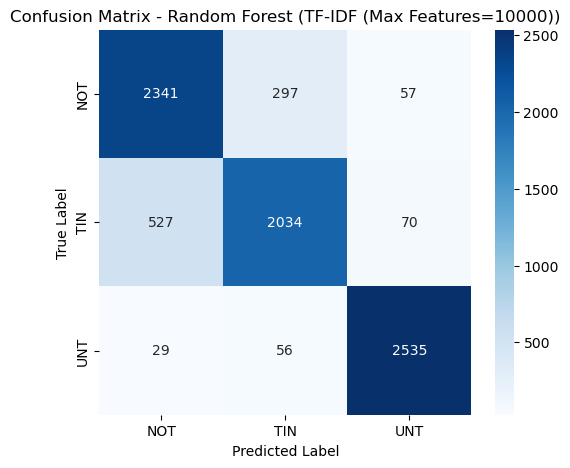


 Applying TF-IDF (Sublinear TF Scaling) with Random Forest
 Accuracy (SMOTE applied - final_text - TF-IDF (Sublinear TF Scaling) - Random Forest): 0.8972

 Classification Report:

              precision    recall  f1-score   support

         NOT       0.80      0.94      0.87      2695
         TIN       0.93      0.77      0.84      2631
         UNT       0.99      0.99      0.99      2620

    accuracy                           0.90      7946
   macro avg       0.91      0.90      0.90      7946
weighted avg       0.90      0.90      0.90      7946



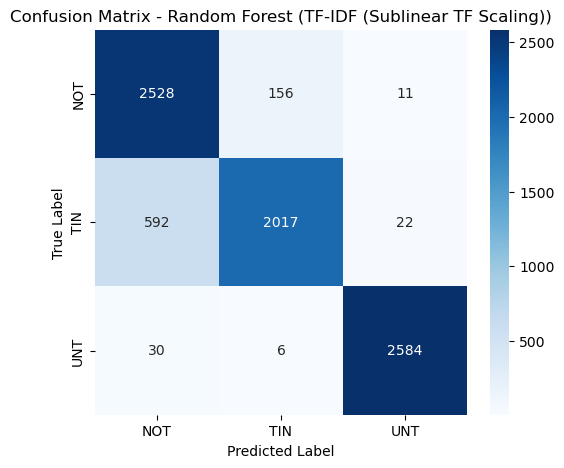


 Applying TF-IDF (Binary Term Presence) with Random Forest
 Accuracy (SMOTE applied - final_text - TF-IDF (Binary Term Presence) - Random Forest): 0.8958

 Classification Report:

              precision    recall  f1-score   support

         NOT       0.80      0.94      0.86      2695
         TIN       0.93      0.76      0.83      2631
         UNT       0.99      0.99      0.99      2620

    accuracy                           0.90      7946
   macro avg       0.90      0.90      0.90      7946
weighted avg       0.90      0.90      0.89      7946



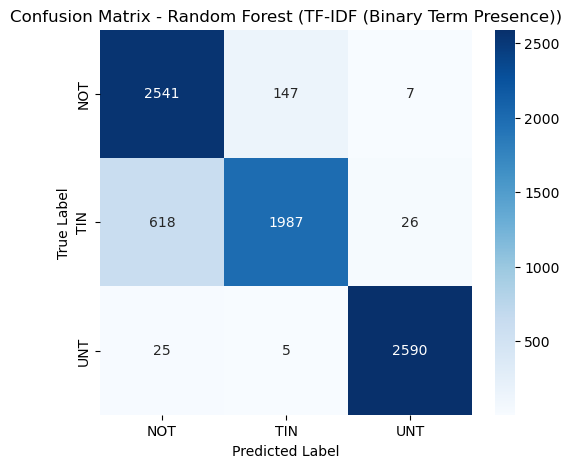


 Applying TF-IDF (L2 Normalization) with Random Forest
 Accuracy (SMOTE applied - final_text - TF-IDF (L2 Normalization) - Random Forest): 0.8973

 Classification Report:

              precision    recall  f1-score   support

         NOT       0.80      0.95      0.87      2695
         TIN       0.93      0.76      0.84      2631
         UNT       0.99      0.98      0.99      2620

    accuracy                           0.90      7946
   macro avg       0.91      0.90      0.90      7946
weighted avg       0.91      0.90      0.90      7946



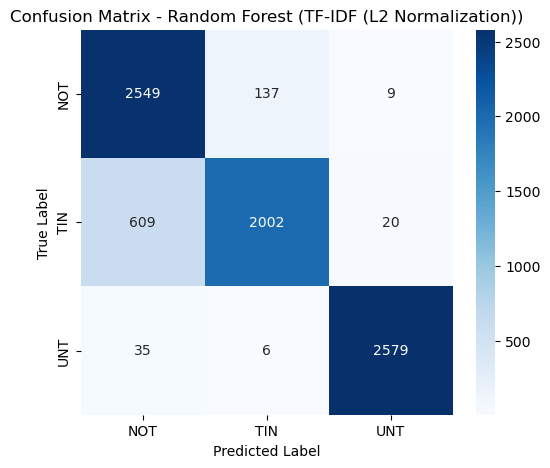


 Applying TF-IDF (L1 Normalization) with Random Forest
 Accuracy (SMOTE applied - final_text - TF-IDF (L1 Normalization) - Random Forest): 0.8748

 Classification Report:

              precision    recall  f1-score   support

         NOT       0.75      0.98      0.85      2695
         TIN       0.96      0.69      0.80      2631
         UNT       0.99      0.95      0.97      2620

    accuracy                           0.87      7946
   macro avg       0.90      0.87      0.87      7946
weighted avg       0.90      0.87      0.87      7946



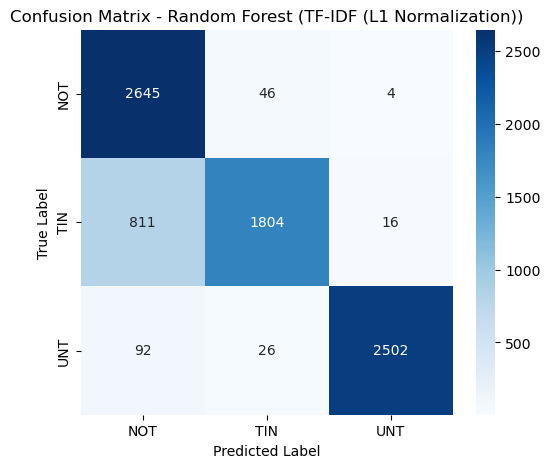


 Applying TF-IDF (No IDF Weighting) with Random Forest
 Accuracy (SMOTE applied - final_text - TF-IDF (No IDF Weighting) - Random Forest): 0.8940

 Classification Report:

              precision    recall  f1-score   support

         NOT       0.79      0.95      0.86      2695
         TIN       0.94      0.75      0.83      2631
         UNT       0.99      0.98      0.99      2620

    accuracy                           0.89      7946
   macro avg       0.91      0.89      0.89      7946
weighted avg       0.90      0.89      0.89      7946



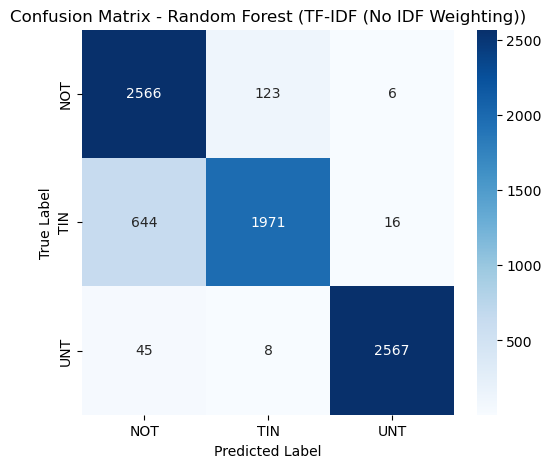


 Applying TF-IDF (Max DF=0.85) with Random Forest
 Accuracy (SMOTE applied - final_text - TF-IDF (Max DF=0.85) - Random Forest): 0.8973

 Classification Report:

              precision    recall  f1-score   support

         NOT       0.80      0.95      0.87      2695
         TIN       0.93      0.76      0.84      2631
         UNT       0.99      0.98      0.99      2620

    accuracy                           0.90      7946
   macro avg       0.91      0.90      0.90      7946
weighted avg       0.91      0.90      0.90      7946



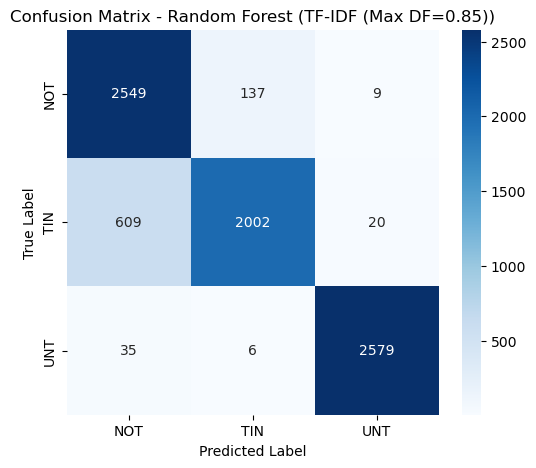


 Applying TF-IDF (Min DF=3) with Random Forest
 Accuracy (SMOTE applied - final_text - TF-IDF (Min DF=3) - Random Forest): 0.8661

 Classification Report:

              precision    recall  f1-score   support

         NOT       0.81      0.86      0.83      2695
         TIN       0.85      0.77      0.81      2631
         UNT       0.94      0.96      0.95      2620

    accuracy                           0.87      7946
   macro avg       0.87      0.87      0.87      7946
weighted avg       0.87      0.87      0.87      7946



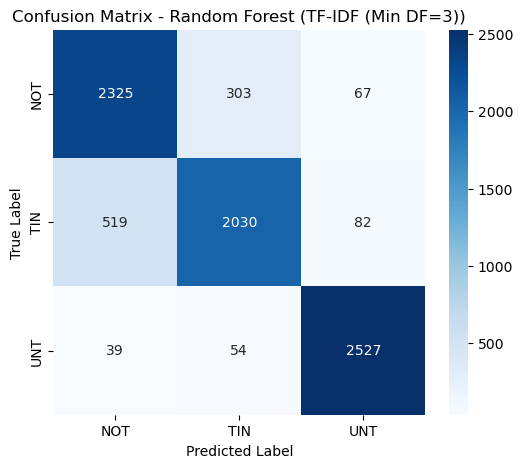


 Applying TF-IDF (Lowercase Disabled) with Random Forest
 Accuracy (SMOTE applied - final_text - TF-IDF (Lowercase Disabled) - Random Forest): 0.8973

 Classification Report:

              precision    recall  f1-score   support

         NOT       0.80      0.95      0.87      2695
         TIN       0.93      0.76      0.84      2631
         UNT       0.99      0.98      0.99      2620

    accuracy                           0.90      7946
   macro avg       0.91      0.90      0.90      7946
weighted avg       0.91      0.90      0.90      7946



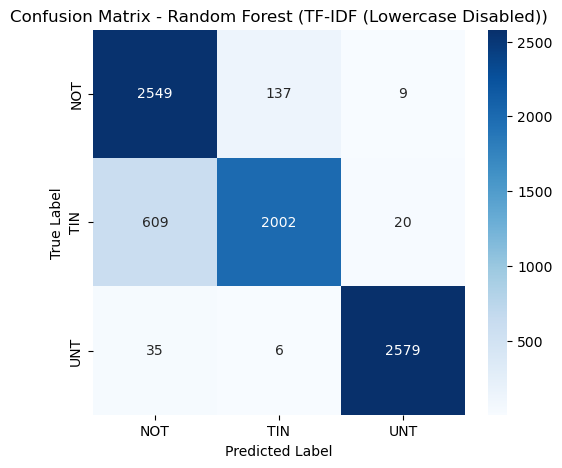

In [ ]:
# Random Forest
train_and_evaluate("TF-IDF (Unigram)", "Random Forest")
train_and_evaluate("TF-IDF (Bigram)", "Random Forest")
train_and_evaluate("TF-IDF (Trigram)", "Random Forest")
train_and_evaluate("TF-IDF (N-gram 1-3)", "Random Forest")
train_and_evaluate("TF-IDF (Feature Limited)", "Random Forest")
train_and_evaluate("TF-IDF (Stopword Removed)", "Random Forest")
train_and_evaluate("TF-IDF (Custom Stopwords)", "Random Forest")
train_and_evaluate("TF-IDF (Max Features=10000)", "Random Forest")
train_and_evaluate("TF-IDF (Sublinear TF Scaling)", "Random Forest")
train_and_evaluate("TF-IDF (Binary Term Presence)", "Random Forest")
train_and_evaluate("TF-IDF (L2 Normalization)", "Random Forest")
train_and_evaluate("TF-IDF (L1 Normalization)", "Random Forest")
train_and_evaluate("TF-IDF (No IDF Weighting)", "Random Forest")
train_and_evaluate("TF-IDF (Max DF=0.85)", "Random Forest")
train_and_evaluate("TF-IDF (Min DF=3)", "Random Forest")
train_and_evaluate("TF-IDF (Lowercase Disabled)", "Random Forest")


 Applying TF-IDF (Unigram) with XGBoost
 Accuracy (SMOTE applied - final_text - TF-IDF (Unigram) - XGBoost): 0.8241

 Classification Report:

              precision    recall  f1-score   support

           0       0.73      0.91      0.81      2695
           1       0.86      0.63      0.73      2631
           2       0.92      0.92      0.92      2620

    accuracy                           0.82      7946
   macro avg       0.84      0.82      0.82      7946
weighted avg       0.84      0.82      0.82      7946



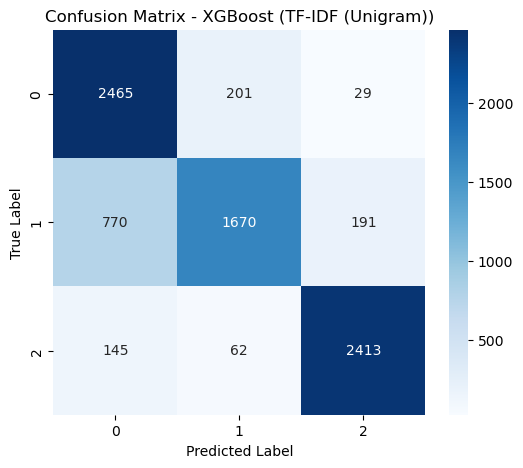


 Applying TF-IDF (Bigram) with XGBoost
 Accuracy (SMOTE applied - final_text - TF-IDF (Bigram) - XGBoost): 0.7056

 Classification Report:

              precision    recall  f1-score   support

           0       0.57      0.90      0.70      2695
           1       0.75      0.42      0.54      2631
           2       0.92      0.80      0.86      2620

    accuracy                           0.71      7946
   macro avg       0.75      0.70      0.70      7946
weighted avg       0.75      0.71      0.70      7946



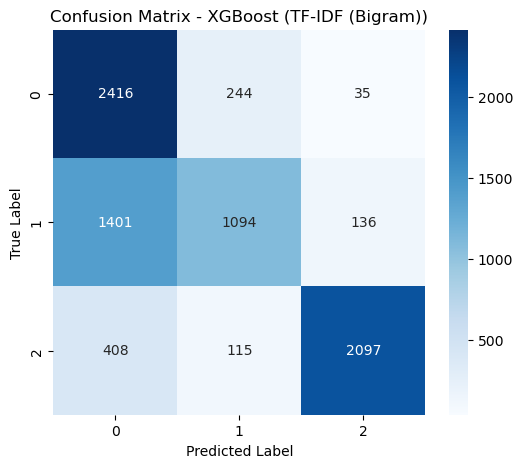


 Applying TF-IDF (Trigram) with XGBoost
 Accuracy (SMOTE applied - final_text - TF-IDF (Trigram) - XGBoost): 0.6277

 Classification Report:

              precision    recall  f1-score   support

           0       0.48      0.97      0.64      2695
           1       0.75      0.10      0.18      2631
           2       0.99      0.80      0.88      2620

    accuracy                           0.63      7946
   macro avg       0.74      0.63      0.57      7946
weighted avg       0.74      0.63      0.57      7946



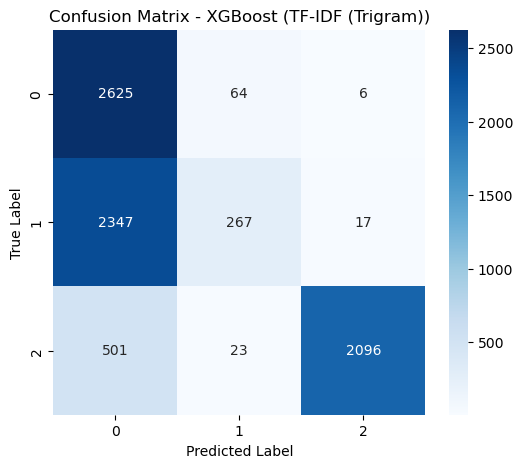


 Applying TF-IDF (N-gram 1-3) with XGBoost
 Accuracy (SMOTE applied - final_text - TF-IDF (N-gram 1-3) - XGBoost): 0.8286

 Classification Report:

              precision    recall  f1-score   support

           0       0.73      0.92      0.81      2695
           1       0.87      0.65      0.74      2631
           2       0.93      0.92      0.92      2620

    accuracy                           0.83      7946
   macro avg       0.84      0.83      0.83      7946
weighted avg       0.84      0.83      0.83      7946



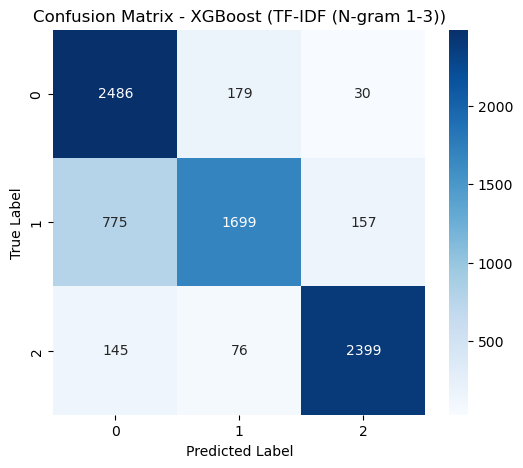


 Applying TF-IDF (Feature Limited) with XGBoost
 Accuracy (SMOTE applied - final_text - TF-IDF (Feature Limited) - XGBoost): 0.7614

 Classification Report:

              precision    recall  f1-score   support

           0       0.68      0.87      0.77      2695
           1       0.80      0.56      0.66      2631
           2       0.84      0.85      0.84      2620

    accuracy                           0.76      7946
   macro avg       0.77      0.76      0.76      7946
weighted avg       0.77      0.76      0.76      7946



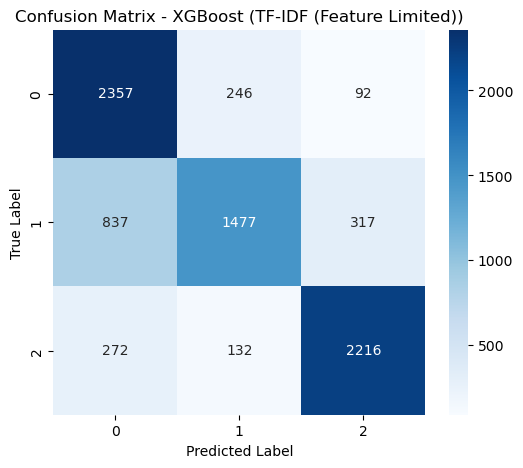


 Applying TF-IDF (Stopword Removed) with XGBoost
 Accuracy (SMOTE applied - final_text - TF-IDF (Stopword Removed) - XGBoost): 0.8058

 Classification Report:

              precision    recall  f1-score   support

           0       0.70      0.91      0.79      2695
           1       0.84      0.60      0.70      2631
           2       0.93      0.91      0.92      2620

    accuracy                           0.81      7946
   macro avg       0.82      0.81      0.80      7946
weighted avg       0.82      0.81      0.80      7946



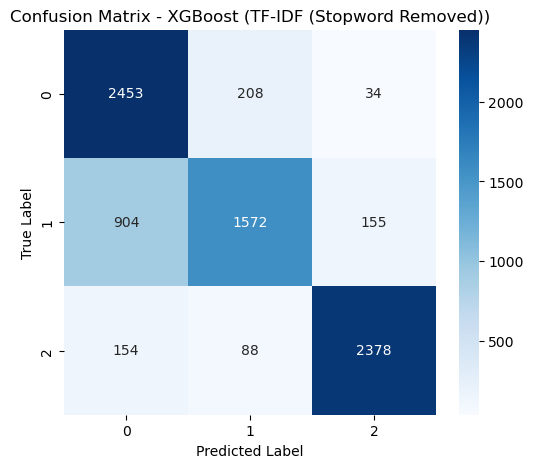


 Applying TF-IDF (Custom Stopwords) with XGBoost
 Accuracy (SMOTE applied - final_text - TF-IDF (Custom Stopwords) - XGBoost): 0.8285

 Classification Report:

              precision    recall  f1-score   support

           0       0.73      0.92      0.81      2695
           1       0.87      0.64      0.74      2631
           2       0.93      0.92      0.92      2620

    accuracy                           0.83      7946
   macro avg       0.84      0.83      0.83      7946
weighted avg       0.84      0.83      0.83      7946



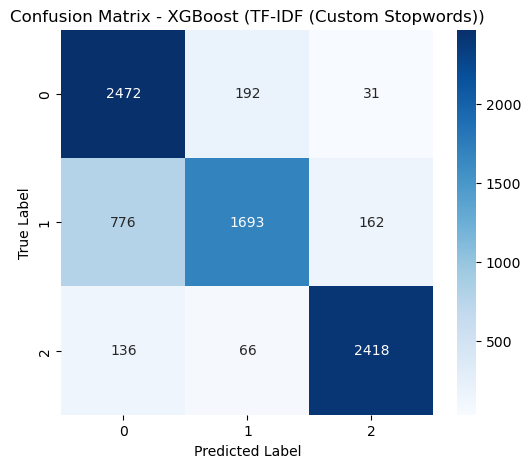


 Applying TF-IDF (Max Features=10000) with XGBoost
 Accuracy (SMOTE applied - final_text - TF-IDF (Max Features=10000) - XGBoost): 0.7793

 Classification Report:

              precision    recall  f1-score   support

           0       0.69      0.88      0.77      2695
           1       0.79      0.61      0.69      2631
           2       0.90      0.84      0.87      2620

    accuracy                           0.78      7946
   macro avg       0.79      0.78      0.78      7946
weighted avg       0.79      0.78      0.78      7946



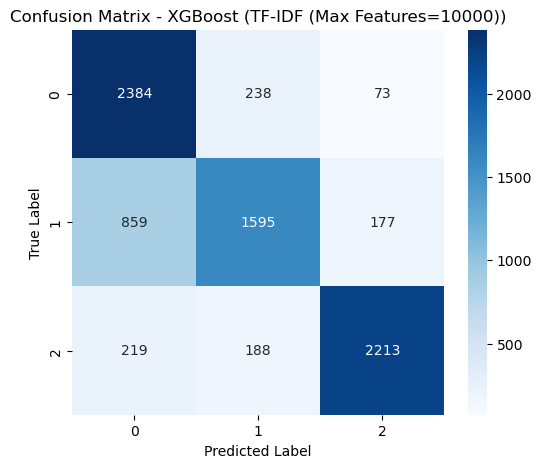


 Applying TF-IDF (Sublinear TF Scaling) with XGBoost
 Accuracy (SMOTE applied - final_text - TF-IDF (Sublinear TF Scaling) - XGBoost): 0.8248

 Classification Report:

              precision    recall  f1-score   support

           0       0.73      0.92      0.82      2695
           1       0.86      0.63      0.73      2631
           2       0.92      0.92      0.92      2620

    accuracy                           0.82      7946
   macro avg       0.84      0.82      0.82      7946
weighted avg       0.84      0.82      0.82      7946



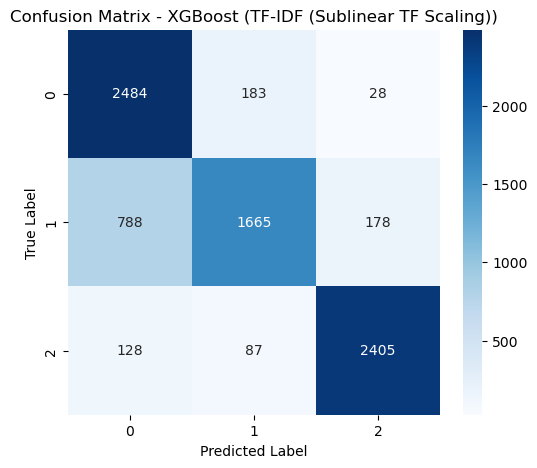


 Applying TF-IDF (Binary Term Presence) with XGBoost
 Accuracy (SMOTE applied - final_text - TF-IDF (Binary Term Presence) - XGBoost): 0.8272

 Classification Report:

              precision    recall  f1-score   support

           0       0.73      0.92      0.82      2695
           1       0.86      0.64      0.73      2631
           2       0.93      0.92      0.92      2620

    accuracy                           0.83      7946
   macro avg       0.84      0.83      0.82      7946
weighted avg       0.84      0.83      0.82      7946



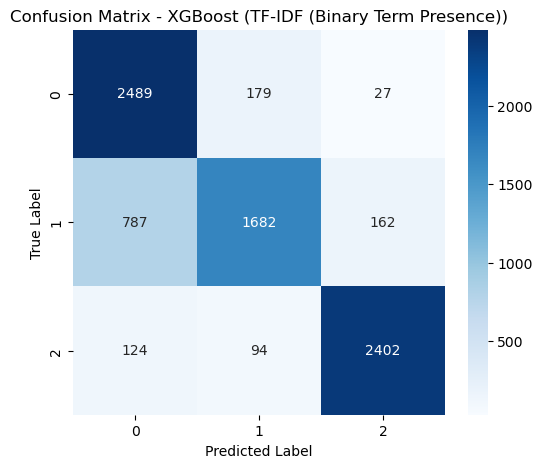


 Applying TF-IDF (L2 Normalization) with XGBoost
 Accuracy (SMOTE applied - final_text - TF-IDF (L2 Normalization) - XGBoost): 0.8296

 Classification Report:

              precision    recall  f1-score   support

           0       0.73      0.92      0.81      2695
           1       0.87      0.65      0.74      2631
           2       0.93      0.92      0.93      2620

    accuracy                           0.83      7946
   macro avg       0.84      0.83      0.83      7946
weighted avg       0.84      0.83      0.83      7946



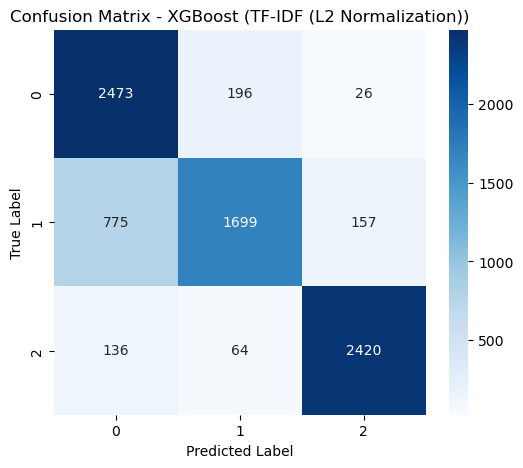


 Applying TF-IDF (L1 Normalization) with XGBoost
 Accuracy (SMOTE applied - final_text - TF-IDF (L1 Normalization) - XGBoost): 0.8696

 Classification Report:

              precision    recall  f1-score   support

           0       0.76      0.94      0.84      2695
           1       0.90      0.73      0.80      2631
           2       0.98      0.95      0.96      2620

    accuracy                           0.87      7946
   macro avg       0.88      0.87      0.87      7946
weighted avg       0.88      0.87      0.87      7946



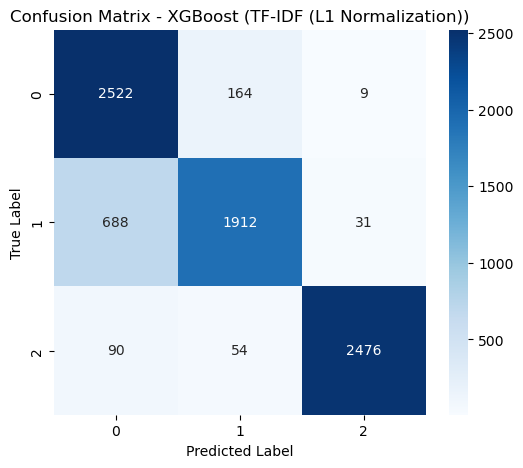


 Applying TF-IDF (No IDF Weighting) with XGBoost
 Accuracy (SMOTE applied - final_text - TF-IDF (No IDF Weighting) - XGBoost): 0.8314

 Classification Report:

              precision    recall  f1-score   support

           0       0.74      0.91      0.81      2695
           1       0.85      0.67      0.75      2631
           2       0.94      0.92      0.93      2620

    accuracy                           0.83      7946
   macro avg       0.84      0.83      0.83      7946
weighted avg       0.84      0.83      0.83      7946



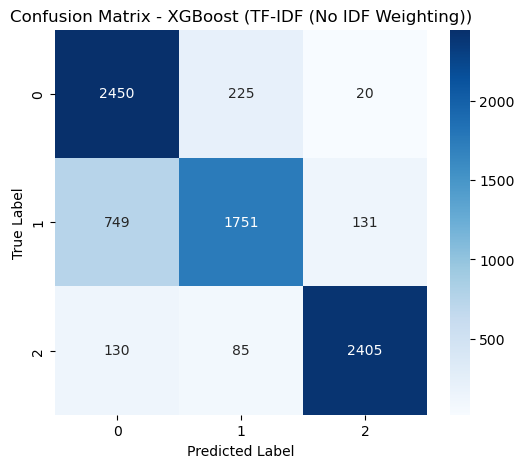


 Applying TF-IDF (Max DF=0.85) with XGBoost
 Accuracy (SMOTE applied - final_text - TF-IDF (Max DF=0.85) - XGBoost): 0.8296

 Classification Report:

              precision    recall  f1-score   support

           0       0.73      0.92      0.81      2695
           1       0.87      0.65      0.74      2631
           2       0.93      0.92      0.93      2620

    accuracy                           0.83      7946
   macro avg       0.84      0.83      0.83      7946
weighted avg       0.84      0.83      0.83      7946



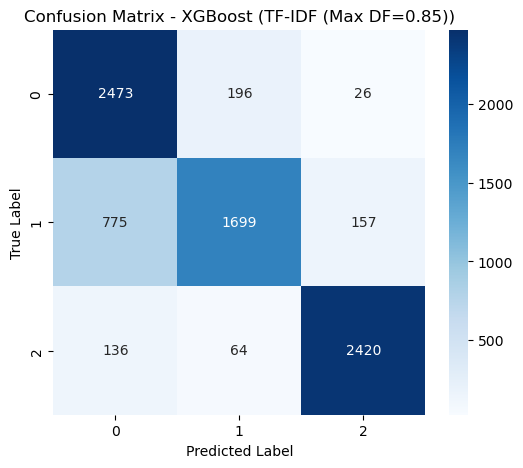


 Applying TF-IDF (Min DF=3) with XGBoost
 Accuracy (SMOTE applied - final_text - TF-IDF (Min DF=3) - XGBoost): 0.7791

 Classification Report:

              precision    recall  f1-score   support

           0       0.69      0.88      0.77      2695
           1       0.79      0.61      0.69      2631
           2       0.90      0.85      0.87      2620

    accuracy                           0.78      7946
   macro avg       0.79      0.78      0.78      7946
weighted avg       0.79      0.78      0.78      7946



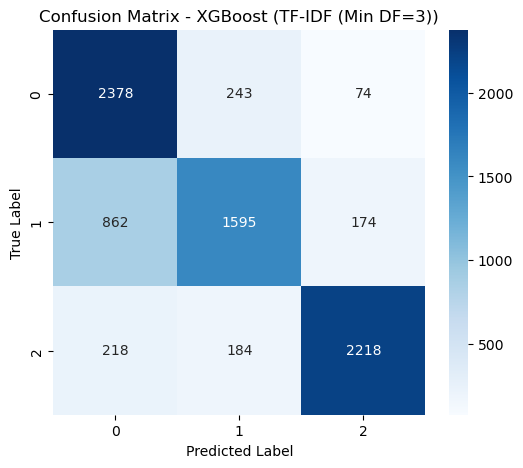


 Applying TF-IDF (Lowercase Disabled) with XGBoost
 Accuracy (SMOTE applied - final_text - TF-IDF (Lowercase Disabled) - XGBoost): 0.8296

 Classification Report:

              precision    recall  f1-score   support

           0       0.73      0.92      0.81      2695
           1       0.87      0.65      0.74      2631
           2       0.93      0.92      0.93      2620

    accuracy                           0.83      7946
   macro avg       0.84      0.83      0.83      7946
weighted avg       0.84      0.83      0.83      7946



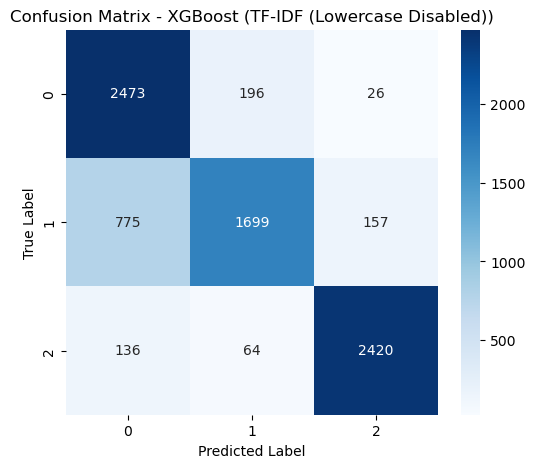

In [ ]:
# XGBoost
train_and_evaluate("TF-IDF (Unigram)", "XGBoost")
train_and_evaluate("TF-IDF (Bigram)", "XGBoost")
train_and_evaluate("TF-IDF (Trigram)", "XGBoost")
train_and_evaluate("TF-IDF (N-gram 1-3)", "XGBoost")
train_and_evaluate("TF-IDF (Feature Limited)", "XGBoost")
train_and_evaluate("TF-IDF (Stopword Removed)", "XGBoost")
train_and_evaluate("TF-IDF (Custom Stopwords)", "XGBoost")
train_and_evaluate("TF-IDF (Max Features=10000)", "XGBoost")
train_and_evaluate("TF-IDF (Sublinear TF Scaling)", "XGBoost")
train_and_evaluate("TF-IDF (Binary Term Presence)", "XGBoost")
train_and_evaluate("TF-IDF (L2 Normalization)", "XGBoost")
train_and_evaluate("TF-IDF (L1 Normalization)", "XGBoost")
train_and_evaluate("TF-IDF (No IDF Weighting)", "XGBoost")
train_and_evaluate("TF-IDF (Max DF=0.85)", "XGBoost")
train_and_evaluate("TF-IDF (Min DF=3)", "XGBoost")
train_and_evaluate("TF-IDF (Lowercase Disabled)", "XGBoost")


In [ ]:
# Voting Classifier
train_and_evaluate("TF-IDF (Unigram)", "Voting Classifier")
train_and_evaluate("TF-IDF (Bigram)", "Voting Classifier")
train_and_evaluate("TF-IDF (Trigram)", "Voting Classifier")
train_and_evaluate("TF-IDF (N-gram 1-3)", "Voting Classifier")
train_and_evaluate("TF-IDF (Feature Limited)", "Voting Classifier")
train_and_evaluate("TF-IDF (Stopword Removed)", "Voting Classifier")
train_and_evaluate("TF-IDF (Custom Stopwords)", "Voting Classifier")
train_and_evaluate("TF-IDF (Max Features=10000)", "Voting Classifier")
train_and_evaluate("TF-IDF (Sublinear TF Scaling)", "Voting Classifier")
train_and_evaluate("TF-IDF (Binary Term Presence)", "Voting Classifier")
train_and_evaluate("TF-IDF (L2 Normalization)", "Voting Classifier")
train_and_evaluate("TF-IDF (L1 Normalization)", "Voting Classifier")
train_and_evaluate("TF-IDF (No IDF Weighting)", "Voting Classifier")
train_and_evaluate("TF-IDF (Max DF=0.85)", "Voting Classifier")
train_and_evaluate("TF-IDF (Min DF=3)", "Voting Classifier")
train_and_evaluate("TF-IDF (Lowercase Disabled)", "Voting Classifier"

SyntaxError: incomplete input (3167846620.py, line 17)

### XGBoost (Extreme Gradient Boosting)

##### Default Baseline (Reference)

In [ ]:
# Install XGBoost if not installed
#!pip install xgboost
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="xgboost")

# Import core libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
import xgboost as xgb  # Import XGBoost

# Define Best Text Version for Vectorization
text_version = 'final_text'

# Define Multiple Vectorization Techniques
vectorization_techniques = {
    # **TF-IDF Variants**
    "TF-IDF (Unigram)": TfidfVectorizer(ngram_range=(1, 1)),
    "TF-IDF (Bigram)": TfidfVectorizer(ngram_range=(2, 2)),
    "TF-IDF (Trigram)": TfidfVectorizer(ngram_range=(3, 3)),
    "TF-IDF (N-gram 1-3)": TfidfVectorizer(ngram_range=(1, 3)),
    "TF-IDF (Feature Limited)": TfidfVectorizer(ngram_range=(1, 2), max_features=5000),
    "TF-IDF (Stopword Removed)": TfidfVectorizer(ngram_range=(1, 2), stop_words='english'),
    "TF-IDF (Custom Stopwords)": TfidfVectorizer(ngram_range=(1, 2), stop_words=['bad', 'hate', 'offensive']),
    "TF-IDF (Max Features=10000)": TfidfVectorizer(ngram_range=(1, 2), max_features=10000),

    # **TF-IDF Regularization Variants**
    "TF-IDF (Sublinear TF Scaling)": TfidfVectorizer(ngram_range=(1, 2), sublinear_tf=True),
    "TF-IDF (Binary Term Presence)": TfidfVectorizer(ngram_range=(1, 2), binary=True),
    "TF-IDF (L2 Normalization)": TfidfVectorizer(ngram_range=(1, 2), norm='l2'),
    "TF-IDF (L1 Normalization)": TfidfVectorizer(ngram_range=(1, 2), norm='l1'),
    "TF-IDF (No IDF Weighting)": TfidfVectorizer(ngram_range=(1, 2), use_idf=False),

    # **TF-IDF Frequency Threshold Variants**
    "TF-IDF (Max DF=0.85)": TfidfVectorizer(ngram_range=(1, 2), max_df=0.85),
    "TF-IDF (Min DF=3)": TfidfVectorizer(ngram_range=(1, 2), min_df=3),

    # **TF-IDF Additional Customization**
    "TF-IDF (Lowercase Disabled)": TfidfVectorizer(ngram_range=(1, 2), lowercase=False)
}

# Encode Labels (Required for XGBoost)**
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(df['label'])  # Encode categorical labels ('NOT', 'TIN', 'UNT') into (0, 1, 2)

# Store Results
results = {
    'vectorization_type': [],
    'accuracy': []
}

# Loop Through Each Vectorization Method
for vec_name, vectorizer in vectorization_techniques.items():
    print(f"\n Applying {vec_name} on '{text_version}'")

    # Apply Vectorization Before Splitting
    X_vectorized = vectorizer.fit_transform(df[text_version])

    # Split Data Into Training & Validation Sets
    X_train, X_val, y_train, y_val = train_test_split(X_vectorized, y_encoded, test_size=0.3, random_state=100, stratify=y_encoded)

    # Initialize and Train XGBoost Model
    model = xgb.XGBClassifier(
        objective='multi:softmax',  # Multiclass classification
        num_class=3,                # Number of classes
        eval_metric='mlogloss',     # Evaluation metric
        use_label_encoder=False,    # Avoids warnings
        random_state=100
    )

    # Train the model
    model.fit(X_train, y_train)

    # Make Predictions
    y_pred = model.predict(X_val)

    # Compute Accuracy
    accuracy = accuracy_score(y_val, y_pred)
    print(f"\n Accuracy ({vec_name}): {accuracy:.4f}")

    # Step 5F: Store Results
    results['vectorization_type'].append(vec_name)
    results['accuracy'].append(accuracy)

# Convert Results to DataFrame & Display
results_df = pd.DataFrame(results)
print("\n Final Accuracy Results:")
print(results_df)



 Applying TF-IDF (Unigram) on 'final_text'

 Accuracy (TF-IDF (Unigram)): 0.7377

 Applying TF-IDF (Bigram) on 'final_text'

 Accuracy (TF-IDF (Bigram)): 0.6863

 Applying TF-IDF (Trigram) on 'final_text'

 Accuracy (TF-IDF (Trigram)): 0.6636

 Applying TF-IDF (N-gram 1-3) on 'final_text'

 Accuracy (TF-IDF (N-gram 1-3)): 0.7415

 Applying TF-IDF (Feature Limited) on 'final_text'

 Accuracy (TF-IDF (Feature Limited)): 0.7400

 Applying TF-IDF (Stopword Removed) on 'final_text'

 Accuracy (TF-IDF (Stopword Removed)): 0.7407

 Applying TF-IDF (Custom Stopwords) on 'final_text'

 Accuracy (TF-IDF (Custom Stopwords)): 0.7405

 Applying TF-IDF (Max Features=10000) on 'final_text'

 Accuracy (TF-IDF (Max Features=10000)): 0.7372

 Applying TF-IDF (Sublinear TF Scaling) on 'final_text'

 Accuracy (TF-IDF (Sublinear TF Scaling)): 0.7445

 Applying TF-IDF (Binary Term Presence) on 'final_text'

 Accuracy (TF-IDF (Binary Term Presence)): 0.7377

 Applying TF-IDF (L2 Normalization) on 'final_tex

**apply smote**

In [ ]:
# Define Best Text Version for Vectorization
text_version = 'final_text'

#  Define Vectorization Techniques
vectorization_techniques = {


    "TF-IDF (Sublinear TF Scaling)": TfidfVectorizer(ngram_range=(1, 2), sublinear_tf=True),
    "TF-IDF (Bigram)": TfidfVectorizer(ngram_range=(2, 2)),
    "TF-IDF (Feature Limited)": TfidfVectorizer(ngram_range=(1, 2), max_features=5000),
    "TF-IDF (Max Features=10000)": TfidfVectorizer(ngram_range=(1, 2), max_features=10000),
    "TF-IDF (Min DF=3)": TfidfVectorizer(ngram_range=(1, 2), min_df=3),
    "TF-IDF (L1 Normalization)": TfidfVectorizer(ngram_range=(1, 2), norm='l1'),
    "TF-IDF (Binary Term Presence)": TfidfVectorizer(ngram_range=(1, 2), binary=True),
    "TF-IDF (N-gram 1-3)": TfidfVectorizer(ngram_range=(1, 3)),
}

# Encode Labels (Required for XGBoost)
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(df['label'])  # Encode categorical labels ('NOT', 'TIN', 'UNT') into (0, 1, 2)

# Store Results
results = {
    'vectorization_type': [],
    'accuracy': []
}

# Loop Through Each Vectorization Method
for vec_name, vectorizer in vectorization_techniques.items():
    print(f"\n Applying {vec_name} on '{text_version}'")

    # Apply Vectorization
    X_vectorized = vectorizer.fit_transform(df[text_version])

    # Apply SMOTE for Class Balancing
    smote = SMOTE(random_state=100)
    X_resampled, y_resampled = smote.fit_resample(X_vectorized, y_encoded)

    # Split Data Into Training & Validation Sets
    X_train, X_val, y_train, y_val = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=100, stratify=y_resampled)

    # Initialize and Train XGBoost Model
    model = xgb.XGBClassifier(
        objective='multi:softmax',  # Multiclass classification
        num_class=3,                # Number of classes
        eval_metric='mlogloss',     # Evaluation metric
        use_label_encoder=False,    # Avoids warnings
        random_state=100
    )

    # Train the model
    model.fit(X_train, y_train)

    # Make Predictions
    y_pred = model.predict(X_val)

    # Compute Accuracy
    accuracy = accuracy_score(y_val, y_pred)
    print(f"\n Accuracy ({vec_name}): {accuracy:.4f}")

    # Store Results
    results['vectorization_type'].append(vec_name)
    results['accuracy'].append(accuracy)

# Convert Results to DataFrame & Display
results_df = pd.DataFrame(results)
print("\n Final Accuracy Results:")
print(results_df)


 Applying TF-IDF (Sublinear TF Scaling) on 'final_text'

 Accuracy (TF-IDF (Sublinear TF Scaling)): 0.8306

 Applying TF-IDF (Max Features=10000) on 'final_text'

 Accuracy (TF-IDF (Max Features=10000)): 0.7819

 Applying TF-IDF (Min DF=3) on 'final_text'

 Accuracy (TF-IDF (Min DF=3)): 0.7793

 Applying TF-IDF (L1 Normalization) on 'final_text'

 Accuracy (TF-IDF (L1 Normalization)): 0.8687

 Final Accuracy Results:
              vectorization_type  accuracy
0  TF-IDF (Sublinear TF Scaling)  0.830607
1    TF-IDF (Max Features=10000)  0.781903
2              TF-IDF (Min DF=3)  0.779260
3      TF-IDF (L1 Normalization)  0.868739


#### Basic Optimization (Grid Search Inspired)

### Naïve Bayes (NB)

In [ ]:
# Import Required Libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import MultinomialNB  # Import Naïve Bayes
from sklearn.metrics import accuracy_score

# Define Best Text Version for Vectorization
text_version = 'final_text'

# Define Multiple Vectorization Techniques
vectorization_techniques = {
    "TF-IDF (Unigram)": TfidfVectorizer(ngram_range=(1, 1)),
    "TF-IDF (Bigram)": TfidfVectorizer(ngram_range=(2, 2)),
    "TF-IDF (Trigram)": TfidfVectorizer(ngram_range=(3, 3)),
    "TF-IDF (N-gram 1-3)": TfidfVectorizer(ngram_range=(1, 3)),
    "TF-IDF (Feature Limited)": TfidfVectorizer(ngram_range=(1, 2), max_features=5000),
    "TF-IDF (Stopword Removed)": TfidfVectorizer(ngram_range=(1, 2), stop_words='english'),
    "TF-IDF (Custom Stopwords)": TfidfVectorizer(ngram_range=(1, 2), stop_words=['bad', 'hate', 'offensive']),
    "TF-IDF (Max Features=10000)": TfidfVectorizer(ngram_range=(1, 2), max_features=10000),
    "TF-IDF (Sublinear TF Scaling)": TfidfVectorizer(ngram_range=(1, 2), sublinear_tf=True),
    "TF-IDF (Binary Term Presence)": TfidfVectorizer(ngram_range=(1, 2), binary=True),
    "TF-IDF (L2 Normalization)": TfidfVectorizer(ngram_range=(1, 2), norm='l2'),
    "TF-IDF (L1 Normalization)": TfidfVectorizer(ngram_range=(1, 2), norm='l1'),
    "TF-IDF (No IDF Weighting)": TfidfVectorizer(ngram_range=(1, 2), use_idf=False),
    "TF-IDF (Max DF=0.85)": TfidfVectorizer(ngram_range=(1, 2), max_df=0.85),
    "TF-IDF (Min DF=3)": TfidfVectorizer(ngram_range=(1, 2), min_df=3),
    "TF-IDF (Lowercase Disabled)": TfidfVectorizer(ngram_range=(1, 2), lowercase=False)
}

# Encode Labels (Required for NB)
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(df['label'])  # Convert categorical labels into numerical format

# Store Results
results = {
    'vectorization_type': [],
    'accuracy': []
}

#  Function to Train and Evaluate Naïve Bayes Model
def train_and_evaluate_nb(X, y, vectorization_type):
    """Train and evaluate a Naïve Bayes model."""

    # Step 1: Split Data
    X_train, X_val, y_train, y_val = train_test_split(
        X, y, test_size=0.3, random_state=100, stratify=y
    )

    # Step 2: Initialize and Train Naïve Bayes Model
    model = MultinomialNB(alpha=1.0)  # Laplace smoothing
    model.fit(X_train, y_train)

    # Make Predictions
    y_pred = model.predict(X_val)

    # Compute Accuracy
    accuracy = accuracy_score(y_val, y_pred)
    print(f"\n Accuracy ({vectorization_type}): {accuracy:.4f}")

    return accuracy

# Apply Vectorization, Train Model, and Evaluate
for vec_name, vectorizer in vectorization_techniques.items():
    print(f"\n Applying {vec_name} on '{text_version}'")

    #  Apply TF-IDF Vectorization Before Splitting
    X_vectorized = vectorizer.fit_transform(df[text_version])

    # Train & Evaluate Naïve Bayes
    accuracy = train_and_evaluate_nb(X_vectorized, y_encoded, vec_name)

    # Store Results
    results['vectorization_type'].append(vec_name)
    results['accuracy'].append(accuracy)

# Convert Results to DataFrame & Display
results_df = pd.DataFrame(results)
print("\n Final Accuracy Results:")
print(results_df)



Applying TF-IDF (Unigram) on 'lemmatized_text'
Accuracy (lemmatized_text - TF-IDF (Unigram)): 0.6807653575025177

Applying TF-IDF (Bigram) on 'lemmatized_text'
Accuracy (lemmatized_text - TF-IDF (Bigram)): 0.6674219536757301

Applying TF-IDF (Trigram) on 'lemmatized_text'
Accuracy (lemmatized_text - TF-IDF (Trigram)): 0.6649043303121853

Applying TF-IDF (N-gram 1-3) on 'lemmatized_text'
Accuracy (lemmatized_text - TF-IDF (N-gram 1-3)): 0.6664149043303121

Applying TF-IDF (Feature Limited) on 'lemmatized_text'
Accuracy (lemmatized_text - TF-IDF (Feature Limited)): 0.7107250755287009

Applying TF-IDF (Stopword Removed) on 'lemmatized_text'
Accuracy (lemmatized_text - TF-IDF (Stopword Removed)): 0.675226586102719

Applying TF-IDF (Custom Stopwords) on 'lemmatized_text'
Accuracy (lemmatized_text - TF-IDF (Custom Stopwords)): 0.6704431017119838

Applying TF-IDF (Max Features=10000) on 'lemmatized_text'
Accuracy (lemmatized_text - TF-IDF (Max Features=10000)): 0.7031722054380665

Applying T

**Applying Smote**

In [ ]:
# Import Required Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE  # Import SMOTE for class balancing

# Define Best Text Version for Vectorization
text_version = 'final_text'

#  Define Multiple Vectorization Techniques
vectorization_techniques = {
    "TF-IDF (Sublinear TF Scaling)": TfidfVectorizer(ngram_range=(1, 2), sublinear_tf=True),
    "TF-IDF (Bigram)": TfidfVectorizer(ngram_range=(2, 2)),
    "TF-IDF (Feature Limited)": TfidfVectorizer(ngram_range=(1, 2), max_features=5000),
    "TF-IDF (Max Features=10000)": TfidfVectorizer(ngram_range=(1, 2), max_features=10000),
    "TF-IDF (Min DF=3)": TfidfVectorizer(ngram_range=(1, 2), min_df=3),
    "TF-IDF (L1 Normalization)": TfidfVectorizer(ngram_range=(1, 2), norm='l1'),
    "TF-IDF (Binary Term Presence)": TfidfVectorizer(ngram_range=(1, 2), binary=True),
    "TF-IDF (N-gram 1-3)": TfidfVectorizer(ngram_range=(1, 3)),
}

#  Encode Labels (Required for NB)
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(df['label'])  # Convert labels into numerical values

# Initialize Results Dictionary
results = {
    'vectorization_type': [],
    'accuracy': []
}

#  Loop Through Each Vectorization Method
for vec_name, vectorizer in vectorization_techniques.items():
    print(f"\n Applying {vec_name} on '{text_version}'")

    # Apply TF-IDF Vectorization Before Balancing
    X_vectorized = vectorizer.fit_transform(df[text_version])

    # Handle Class Imbalance Using SMOTE
    smote = SMOTE(random_state=100)
    X_resampled, y_resampled = smote.fit_resample(X_vectorized, y_encoded)

    # Split Data After Balancing
    X_train, X_val, y_train, y_val = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=100, stratify=y_resampled)

    # Initialize & Train Naïve Bayes Model
    model = MultinomialNB(alpha=1.0)  # Laplace smoothing
    model.fit(X_train, y_train)

    # Make Predictions*
    y_pred = model.predict(X_val)

    # Compute Accuracy
    accuracy = accuracy_score(y_val, y_pred)
    print(f"\n Accuracy ({vec_name}): {accuracy:.4f}")

    # Store Results
    results['vectorization_type'].append(vec_name)
    results['accuracy'].append(accuracy)

# Convert Results to DataFrame & Display
results_df = pd.DataFrame(results)
print("\n Final Accuracy Results:")
print(results_df)


 Applying TF-IDF (Bigram) on 'final_text'

 Accuracy (TF-IDF (Bigram)): 0.7535

 Applying TF-IDF (Feature Limited) on 'final_text'

 Accuracy (TF-IDF (Feature Limited)): 0.7361

 Applying TF-IDF (Max Features=10000) on 'final_text'

 Accuracy (TF-IDF (Max Features=10000)): 0.7712

 Applying TF-IDF (Min DF=3) on 'final_text'

 Accuracy (TF-IDF (Min DF=3)): 0.7723

 Applying TF-IDF (L1 Normalization) on 'final_text'

 Accuracy (TF-IDF (L1 Normalization)): 0.8398

 Final Accuracy Results:
            vectorization_type  accuracy
0              TF-IDF (Bigram)  0.753461
1     TF-IDF (Feature Limited)  0.736094
2  TF-IDF (Max Features=10000)  0.771206
3            TF-IDF (Min DF=3)  0.772338
4    TF-IDF (L1 Normalization)  0.839794


#### Decision Tress

##### Default Baseline

In [ ]:
# Import Required Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Define Best Text Version for Vectorization
text_version = 'final_text'

# Define Multiple Vectorization Techniques
vectorization_techniques = {
    "TF-IDF (Unigram)": TfidfVectorizer(ngram_range=(1, 1)),
    "TF-IDF (Bigram)": TfidfVectorizer(ngram_range=(2, 2)),
    "TF-IDF (Trigram)": TfidfVectorizer(ngram_range=(3, 3)),
    "TF-IDF (N-gram 1-3)": TfidfVectorizer(ngram_range=(1, 3)),
    "TF-IDF (Feature Limited)": TfidfVectorizer(ngram_range=(1, 2), max_features=5000),
    "TF-IDF (Stopword Removed)": TfidfVectorizer(ngram_range=(1, 2), stop_words='english'),
    "TF-IDF (Custom Stopwords)": TfidfVectorizer(ngram_range=(1, 2), stop_words=['bad', 'hate', 'offensive']),
    "TF-IDF (Max Features=10000)": TfidfVectorizer(ngram_range=(1, 2), max_features=10000),

    # **TF-IDF Regularization Variants**
    "TF-IDF (Sublinear TF Scaling)": TfidfVectorizer(ngram_range=(1, 2), sublinear_tf=True),
    "TF-IDF (Binary Term Presence)": TfidfVectorizer(ngram_range=(1, 2), binary=True),
    "TF-IDF (L2 Normalization)": TfidfVectorizer(ngram_range=(1, 2), norm='l2'),
    "TF-IDF (L1 Normalization)": TfidfVectorizer(ngram_range=(1, 2), norm='l1'),
    "TF-IDF (No IDF Weighting)": TfidfVectorizer(ngram_range=(1, 2), use_idf=False),

    # **TF-IDF Frequency Threshold Variants**
    "TF-IDF (Max DF=0.85)": TfidfVectorizer(ngram_range=(1, 2), max_df=0.85),
    "TF-IDF (Min DF=3)": TfidfVectorizer(ngram_range=(1, 2), min_df=3),

    # **TF-IDF Additional Customization**
    "TF-IDF (Lowercase Disabled)": TfidfVectorizer(ngram_range=(1, 2), lowercase=False)
}

#  Encode Labels (Convert text labels into numerical values)
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(df['label'])

#  Initialize Results Dictionary
results = {
    'vectorization_type': [],
    'accuracy': []
}

#  Loop Through Each Vectorization Method
for vec_name, vectorizer in vectorization_techniques.items():
    print(f"\n Applying {vec_name} on '{text_version}'")

    #  Apply TF-IDF Vectorization
    X_vectorized = vectorizer.fit_transform(df[text_version])

    #  Split Data Before Training
    X_train, X_val, y_train, y_val = train_test_split(X_vectorized, y_encoded, test_size=0.3, random_state=100, stratify=y_encoded)

    #  Initialize & Train Decision Tree Model
    model = DecisionTreeClassifier(criterion='gini', max_depth=10, random_state=100)
    model.fit(X_train, y_train)

    #  Make Predictions
    y_pred = model.predict(X_val)

    #  Compute Accuracy
    accuracy = accuracy_score(y_val, y_pred)
    print(f"\n Accuracy ({vec_name}): {accuracy:.4f}")

    #  Store Results
    results['vectorization_type'].append(vec_name)
    results['accuracy'].append(accuracy)

#  Convert Results to DataFrame & Display
results_df = pd.DataFrame(results)
print("\n Final Accuracy Results:")
print(results_df)



 Applying TF-IDF (Unigram) on 'final_text'

 Accuracy (TF-IDF (Unigram)): 0.7163

 Applying TF-IDF (Bigram) on 'final_text'

 Accuracy (TF-IDF (Bigram)): 0.6825

 Applying TF-IDF (Trigram) on 'final_text'

 Accuracy (TF-IDF (Trigram)): 0.6659

 Applying TF-IDF (N-gram 1-3) on 'final_text'

 Accuracy (TF-IDF (N-gram 1-3)): 0.7173

 Applying TF-IDF (Feature Limited) on 'final_text'

 Accuracy (TF-IDF (Feature Limited)): 0.7206

 Applying TF-IDF (Stopword Removed) on 'final_text'

 Accuracy (TF-IDF (Stopword Removed)): 0.7158

 Applying TF-IDF (Custom Stopwords) on 'final_text'

 Accuracy (TF-IDF (Custom Stopwords)): 0.7171

 Applying TF-IDF (Max Features=10000) on 'final_text'

 Accuracy (TF-IDF (Max Features=10000)): 0.7188

 Applying TF-IDF (Sublinear TF Scaling) on 'final_text'

 Accuracy (TF-IDF (Sublinear TF Scaling)): 0.7173

 Applying TF-IDF (Binary Term Presence) on 'final_text'

 Accuracy (TF-IDF (Binary Term Presence)): 0.7201

 Applying TF-IDF (L2 Normalization) on 'final_tex

### APPLying smote

In [ ]:
# Import Required Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier  # Import Decision Tree Classifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE  # Import SMOTE for class balancing

# Define Best Text Version for Vectorization
text_version = 'final_text'

# Define Multiple Vectorization Techniques
vectorization_techniques = {
    "TF-IDF (Sublinear TF Scaling)": TfidfVectorizer(ngram_range=(1, 2), sublinear_tf=True),
    "TF-IDF (Bigram)": TfidfVectorizer(ngram_range=(2, 2)),
    "TF-IDF (Feature Limited)": TfidfVectorizer(ngram_range=(1, 2), max_features=5000),
    "TF-IDF (Max Features=10000)": TfidfVectorizer(ngram_range=(1, 2), max_features=10000),
    "TF-IDF (Min DF=3)": TfidfVectorizer(ngram_range=(1, 2), min_df=3),
    "TF-IDF (L1 Normalization)": TfidfVectorizer(ngram_range=(1, 2), norm='l1'),
    "TF-IDF (Binary Term Presence)": TfidfVectorizer(ngram_range=(1, 2), binary=True),
    "TF-IDF (N-gram 1-3)": TfidfVectorizer(ngram_range=(1, 3)),
}

# Encode Labels (Required for Decision Tree)
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(df['label'])  # Convert labels into numerical values

# Initialize Results Dictionary
results = {
    'vectorization_type': [],
    'accuracy': []
}

# Loop Through Each Vectorization Method
for vec_name, vectorizer in vectorization_techniques.items():
    print(f"\n Applying {vec_name} on '{text_version}'")

    # Apply TF-IDF Vectorization Before Balancing
    X_vectorized = vectorizer.fit_transform(df[text_version])

    # Handle Class Imbalance Using SMOTE
    smote = SMOTE(random_state=100)
    X_resampled, y_resampled = smote.fit_resample(X_vectorized, y_encoded)

    # Split Data After Balancing
    X_train, X_val, y_train, y_val = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=100, stratify=y_resampled)

    # Initialize & Train Decision Tree Model
    model = DecisionTreeClassifier(random_state=100, max_depth=20, min_samples_split=5)  # Added hyperparameters
    model.fit(X_train, y_train)

    # Make Predictions
    y_pred = model.predict(X_val)

    # Compute Accuracy
    accuracy = accuracy_score(y_val, y_pred)
    print(f"\n Accuracy ({vec_name}): {accuracy:.4f}")

    # Store Results
    results['vectorization_type'].append(vec_name)
    results['accuracy'].append(accuracy)

# Convert Results to DataFrame & Display
results_df = pd.DataFrame(results)
print("\n Final Accuracy Results:")
print(results_df)


 Applying TF-IDF (Bigram) on 'final_text'

 Accuracy (TF-IDF (Bigram)): 0.4101

 Applying TF-IDF (Feature Limited) on 'final_text'

 Accuracy (TF-IDF (Feature Limited)): 0.6367

 Applying TF-IDF (Max Features=10000) on 'final_text'

 Accuracy (TF-IDF (Max Features=10000)): 0.6699

 Applying TF-IDF (Min DF=3) on 'final_text'

 Accuracy (TF-IDF (Min DF=3)): 0.6698

 Applying TF-IDF (L1 Normalization) on 'final_text'

 Accuracy (TF-IDF (L1 Normalization)): 0.8338

 Applying TF-IDF (Binary Term Presence) on 'final_text'

 Accuracy (TF-IDF (Binary Term Presence)): 0.6847

 Applying TF-IDF (N-gram 1-3) on 'final_text'

 Accuracy (TF-IDF (N-gram 1-3)): 0.6803

 Final Accuracy Results:
              vectorization_type  accuracy
0                TF-IDF (Bigram)  0.410143
1       TF-IDF (Feature Limited)  0.636673
2    TF-IDF (Max Features=10000)  0.669897
3              TF-IDF (Min DF=3)  0.669771
4      TF-IDF (L1 Normalization)  0.833753
5  TF-IDF (Binary Term Presence)  0.684747
6          

**Ensemble Modle**

**Voting Classifier**

In [ ]:
# Import Required Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE

# Define Best Text Version for Vectorization
text_version = 'final_text'

# Define Multiple Vectorization Techniques
vectorization_techniques = {
    "TF-IDF (Sublinear TF Scaling)": TfidfVectorizer(ngram_range=(1, 2), sublinear_tf=True),
    "TF-IDF (Bigram)": TfidfVectorizer(ngram_range=(2, 2)),
    "TF-IDF (Feature Limited)": TfidfVectorizer(ngram_range=(1, 2), max_features=5000),
    "TF-IDF (Max Features=10000)": TfidfVectorizer(ngram_range=(1, 2), max_features=10000),
    "TF-IDF (Min DF=3)": TfidfVectorizer(ngram_range=(1, 2), min_df=3),
    "TF-IDF (L1 Normalization)": TfidfVectorizer(ngram_range=(1, 2), norm='l1'),
    "TF-IDF (Binary Term Presence)": TfidfVectorizer(ngram_range=(1, 2), binary=True),
    "TF-IDF (N-gram 1-3)": TfidfVectorizer(ngram_range=(1, 3)),
}

# Encode Labels (Required for Models)
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(df['label'])  # Convert labels into numerical values

# Initialize Results Dictionary
results = {
    'vectorization_type': [],
    'accuracy': []
}

# Loop Through Each Vectorization Method
for vec_name, vectorizer in vectorization_techniques.items():
    print(f"\n Applying {vec_name} on '{text_version}'")

    # Apply TF-IDF Vectorization Before Balancing
    X_vectorized = vectorizer.fit_transform(df[text_version])

    # Handle Class Imbalance Using SMOTE
    smote = SMOTE(random_state=100)
    X_resampled, y_resampled = smote.fit_resample(X_vectorized, y_encoded)

    # Split Data After Balancing
    X_train, X_val, y_train, y_val = train_test_split(
        X_resampled, y_resampled, test_size=0.3, random_state=100, stratify=y_resampled
    )

    #  Initialize Base Models
    model1 = SVC(probability=True, kernel='linear', random_state=100)
    model2 = RandomForestClassifier(n_estimators=200, random_state=100)
    model3 = MultinomialNB()
    model4 = LogisticRegression(max_iter=1000, random_state=100)

    #  Create Ensemble Model (Soft Voting)
    voting_model = VotingClassifier(estimators=[
        ('svm', model1),
        ('rf', model2),
        ('nb', model3),
        ('lr', model4)
    ], voting='soft')  # Use 'hard' for majority voting

    #  Train the Model
    voting_model.fit(X_train, y_train)

    #  Make Predictions
    y_pred = voting_model.predict(X_val)

    # Compute Accuracy
    accuracy = accuracy_score(y_val, y_pred)
    print(f"\n Accuracy ({vec_name}): {accuracy:.4f}")

    # Store Results
    results['vectorization_type'].append(vec_name)
    results['accuracy'].append(accuracy)

# Convert Results to DataFrame & Display
results_df = pd.DataFrame(results)
print("\n Final Accuracy Results:")
print(results_df)



 Applying TF-IDF (Bigram) on 'final_text'

 Accuracy (TF-IDF (Bigram)): 0.8254

 Applying TF-IDF (Feature Limited) on 'final_text'

 Accuracy (TF-IDF (Feature Limited)): 0.8302

 Applying TF-IDF (Max Features=10000) on 'final_text'

 Accuracy (TF-IDF (Max Features=10000)): 0.8512

 Applying TF-IDF (Min DF=3) on 'final_text'

 Accuracy (TF-IDF (Min DF=3)): 0.8539

 Applying TF-IDF (L1 Normalization) on 'final_text'

 Accuracy (TF-IDF (L1 Normalization)): 0.8705

 Applying TF-IDF (Binary Term Presence) on 'final_text'

 Accuracy (TF-IDF (Binary Term Presence)): 0.9183

 Applying TF-IDF (N-gram 1-3) on 'final_text'

 Accuracy (TF-IDF (N-gram 1-3)): 0.9239

 Final Accuracy Results:
              vectorization_type  accuracy
0                TF-IDF (Bigram)  0.825447
1       TF-IDF (Feature Limited)  0.830229
2    TF-IDF (Max Features=10000)  0.851246
3              TF-IDF (Min DF=3)  0.853889
4      TF-IDF (L1 Normalization)  0.870501
5  TF-IDF (Binary Term Presence)  0.918324
6          

**Train and the Best Model**

In [ ]:
from sklearn.ensemble import RandomForestClassifier


In [ ]:
from sklearn.preprocessing import LabelEncoder

 Accuracy (SMOTE applied - final_text - TF-IDF (Feature Limited)): 0.9185753838409263

 Classification Report:

              precision    recall  f1-score   support

           0       0.85      0.93      0.89      2695
           1       0.92      0.83      0.87      2631
           2       1.00      1.00      1.00      2620

    accuracy                           0.92      7946
   macro avg       0.92      0.92      0.92      7946
weighted avg       0.92      0.92      0.92      7946



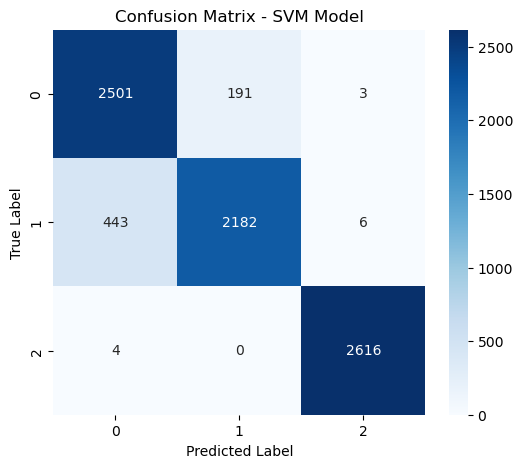

In [ ]:
# Define the best text version and vectorization technique
text_version = 'final_text'

#vectorizer =  TfidfVectorizer(ngram_range=(1, 2), binary=True)
vectorizer = TfidfVectorizer(ngram_range=(1, 2), norm='l1')
#vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=10000)  # TF-IDF (Feature Limited)
#vectorizer = TfidfVectorizer(ngram_range=(1, 2), sublinear_tf=True),
#vectorizer = TfidfVectorizer(ngram_range=(2, 2)),
#vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=5000),
#vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=10000),
#vectorizer =  TfidfVectorizer(ngram_range=(1, 2), min_df=3),
#vectorizer =  TfidfVectorizer(ngram_range=(1, 2), norm='l1'),
#vectorizer = TfidfVectorizer(ngram_range=(1, 2), binary=True),
#vectorizer =  TfidfVectorizer(ngram_range=(1, 3)),

# Apply vectorization
X_vectorized = vectorizer.fit_transform(df[text_version])


# Encode Labels (Required for XGBoost)**
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(df['label'])  # Encode categorical labels ('NOT', 'TIN', 'UNT') into (0, 1, 2)

# Apply SMOTE before splitting
smote = SMOTE(random_state=100)
X_resampled, y_resampled = smote.fit_resample(X_vectorized, y_encoded)

# Split data after applying SMOTE
X_train, X_val, y_train, y_val = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=100)


# Initialize and train the Random Forest model
best_model = SVC(kernel='rbf', C=10, random_state=100)

# Initialize & Train Decision Tree Model
#best_model = DecisionTreeClassifier(criterion='gini', max_depth=10, random_state=100)

# Initialize & Train Naïve Bayes Model
#best_model = MultinomialNB(alpha=1.0)  # Laplace smoothing

'''
best_model = xgb.XGBClassifier(
        objective='multi:softmax',  # Multiclass classification
        num_class=3,                # Number of classes
        eval_metric='mlogloss',     # Evaluation metric
        use_label_encoder=False,    # Avoids warnings
        random_state=100
    )
'''

'''
#  Initialize Base Models
model1 = SVC(probability=True, kernel='linear', random_state=100)
model2 = RandomForestClassifier(n_estimators=200, random_state=100)
model3 = MultinomialNB()
model4 = LogisticRegression(max_iter=1000, random_state=100)

    #  Create Ensemble Model (Soft Voting)
    best_model = VotingClassifier(estimators=[
        ('svm', model1),
        ('rf', model2),
        ('nb', model3),
        ('lr', model4)
        ], voting='soft')  # Use 'hard' for majority voting
'''
'''
#  Initialize and train the Random Forest model
    model = RandomForestClassifier(n_estimators=100, random_state=100)
    model.fit(X_train, y_train)
'''

best_model.fit(X_train, y_train)

# Make predictions
#y_pred = model.predict(X_val)
y_pred = best_model.predict(X_val)

# Compute accuracy
accuracy = accuracy_score(y_val, y_pred)
print(f" Accuracy (SMOTE applied - {text_version} - TF-IDF (Feature Limited)): {accuracy}")

# Classification Report
print("\n Classification Report:\n")
print(classification_report(y_val, y_pred))

# Generate Confusion Matrix
conf_matrix = confusion_matrix(y_val, y_pred)

# Plot the Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues", xticklabels=np.unique(y_encoded), yticklabels=np.unique(y_encoded))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - SVM Model")
plt.show()

**Function for Dynamic Vectorization & Model Selection**

In [ ]:
**Function for Dynamic Vectorization & Model Selection**
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Define text version
text_version = 'final_text'

# Define Multiple Vectorization Techniques
vectorization_techniques = {
    "TF-IDF (Sublinear TF Scaling)": TfidfVectorizer(ngram_range=(1, 2), sublinear_tf=True),
    "TF-IDF (Bigram)": TfidfVectorizer(ngram_range=(2, 2)),
    "TF-IDF (Feature Limited)": TfidfVectorizer(ngram_range=(1, 2), max_features=5000),
    "TF-IDF (Max Features=10000)": TfidfVectorizer(ngram_range=(1, 2), max_features=10000),
    "TF-IDF (Min DF=3)": TfidfVectorizer(ngram_range=(1, 2), min_df=3),
    "TF-IDF (L1 Normalization)": TfidfVectorizer(ngram_range=(1, 2), norm='l1'),
    "TF-IDF (Binary Term Presence)": TfidfVectorizer(ngram_range=(1, 2), binary=True),
    "TF-IDF (N-gram 1-3)": TfidfVectorizer(ngram_range=(1, 3)),
}

# Define Multiple Models
models = {
    "SVM (RBF Kernel)": SVC(kernel='rbf', C=10, random_state=100),
    "Decision Tree": DecisionTreeClassifier(criterion='gini', max_depth=10, random_state=100),
    "Naïve Bayes": MultinomialNB(alpha=1.0),  # Laplace smoothing
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=100),
    "XGBoost": XGBClassifier(
        objective='multi:softmax',
        num_class=3,
        eval_metric='mlogloss',
        use_label_encoder=False,
        random_state=100
    ),
    "Voting Classifier": VotingClassifier(estimators=[
        ('svm', SVC(probability=True, kernel='linear', random_state=100)),
        ('rf', RandomForestClassifier(n_estimators=200, random_state=100)),
        ('nb', MultinomialNB()),
        ('lr', LogisticRegression(max_iter=1000, random_state=100))
    ], voting='soft')
}

# Function to Train and Evaluate Model
def train_and_evaluate(vectorizer_name, model_name):
    """
    Function to apply vectorization, train a selected model, and evaluate performance.

    Parameters:
    - vectorizer_name (str): The name of the vectorization technique.
    - model_name (str): The name of the model to train.
    """
    print(f"\n Applying {vectorizer_name} with {model_name}")

    # Get the selected vectorizer
    vectorizer = vectorization_techniques[vectorizer_name]

    # Apply Vectorization
    X_vectorized = vectorizer.fit_transform(df[text_version])

    # Encode Labels
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(df['label'])  # Convert labels ('NOT', 'TIN', 'UNT') into (0, 1, 2)

    # Apply SMOTE before splitting
    smote = SMOTE(random_state=100)
    X_resampled, y_resampled = smote.fit_resample(X_vectorized, y_encoded)

    # Split data
    X_train, X_val, y_train, y_val = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=100)

    # Select Model
    best_model = models[model_name]

    # Train Model
    best_model.fit(X_train, y_train)

    # Make Predictions
    y_pred = best_model.predict(X_val)

    # Compute Accuracy
    accuracy = accuracy_score(y_val, y_pred)
    print(f" Accuracy (SMOTE applied - {text_version} - {vectorizer_name} - {model_name}): {accuracy:.4f}")

    # Classification Report
    print("\n Classification Report:\n")
    print(classification_report(y_val, y_pred))

    # Generate and Plot Confusion Matrix
    conf_matrix = confusion_matrix(y_val, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues", xticklabels=np.unique(y_encoded), yticklabels=np.unique(y_encoded))
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"Confusion Matrix - {model_name} ({vectorizer_name})")
    plt.show()


 Applying TF-IDF (Sublinear TF Scaling) with SVM (RBF Kernel)
 Accuracy (SMOTE applied - final_text - TF-IDF (Sublinear TF Scaling) - SVM (RBF Kernel)): 0.9013

 Classification Report:

              precision    recall  f1-score   support

           0       0.79      0.98      0.87      2695
           1       0.97      0.73      0.83      2631
           2       0.99      0.99      0.99      2620

    accuracy                           0.90      7946
   macro avg       0.92      0.90      0.90      7946
weighted avg       0.92      0.90      0.90      7946



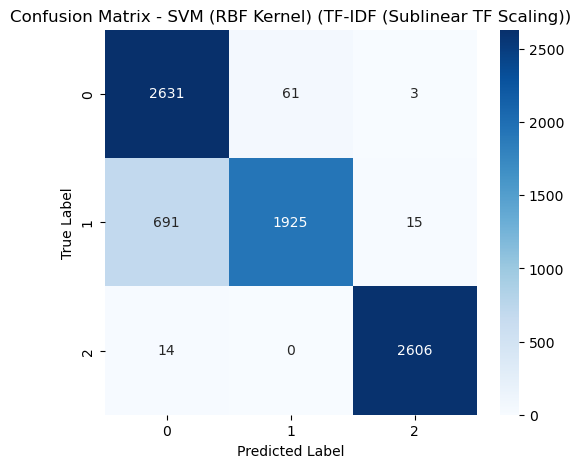


 Applying TF-IDF (Bigram) with SVM (RBF Kernel)
 Accuracy (SMOTE applied - final_text - TF-IDF (Bigram) - SVM (RBF Kernel)): 0.8570

 Classification Report:

              precision    recall  f1-score   support

           0       0.79      0.97      0.87      2695
           1       0.98      0.61      0.75      2631
           2       0.86      1.00      0.92      2620

    accuracy                           0.86      7946
   macro avg       0.88      0.86      0.85      7946
weighted avg       0.88      0.86      0.85      7946



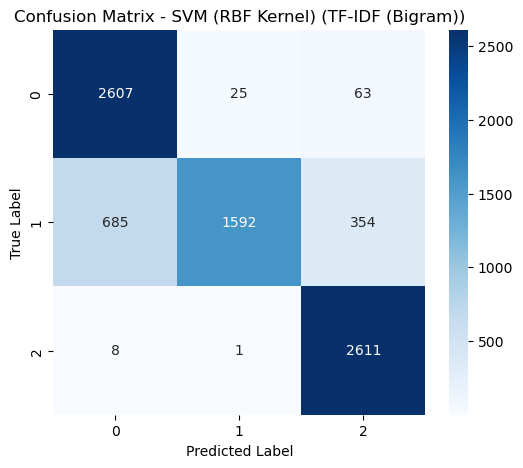


 Applying TF-IDF (Feature Limited) with SVM (RBF Kernel)
 Accuracy (SMOTE applied - final_text - TF-IDF (Feature Limited) - SVM (RBF Kernel)): 0.8738

 Classification Report:

              precision    recall  f1-score   support

           0       0.83      0.90      0.86      2695
           1       0.90      0.73      0.81      2631
           2       0.90      0.99      0.95      2620

    accuracy                           0.87      7946
   macro avg       0.88      0.87      0.87      7946
weighted avg       0.88      0.87      0.87      7946



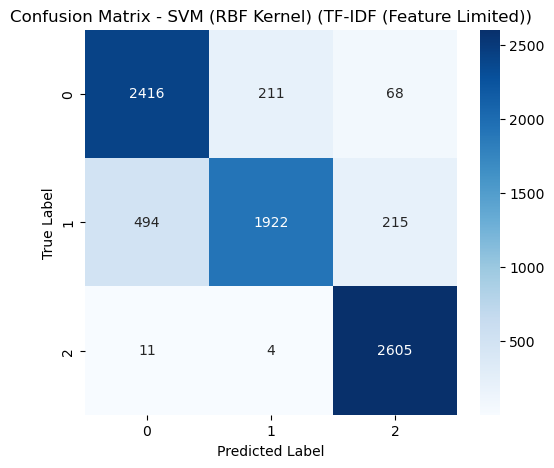


 Applying TF-IDF (Max Features=10000) with SVM (RBF Kernel)
 Accuracy (SMOTE applied - final_text - TF-IDF (Max Features=10000) - SVM (RBF Kernel)): 0.8871

 Classification Report:

              precision    recall  f1-score   support

           0       0.83      0.92      0.87      2695
           1       0.87      0.79      0.83      2631
           2       0.97      0.95      0.96      2620

    accuracy                           0.89      7946
   macro avg       0.89      0.89      0.89      7946
weighted avg       0.89      0.89      0.89      7946



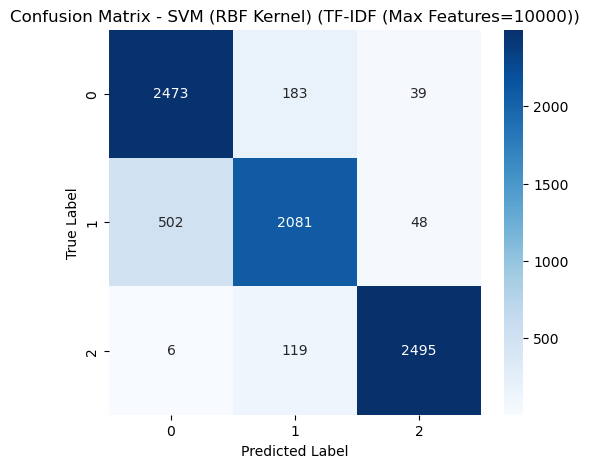


 Applying TF-IDF (Min DF=3) with SVM (RBF Kernel)
 Accuracy (SMOTE applied - final_text - TF-IDF (Min DF=3) - SVM (RBF Kernel)): 0.8877

 Classification Report:

              precision    recall  f1-score   support

           0       0.83      0.92      0.87      2695
           1       0.87      0.79      0.83      2631
           2       0.97      0.95      0.96      2620

    accuracy                           0.89      7946
   macro avg       0.89      0.89      0.89      7946
weighted avg       0.89      0.89      0.89      7946



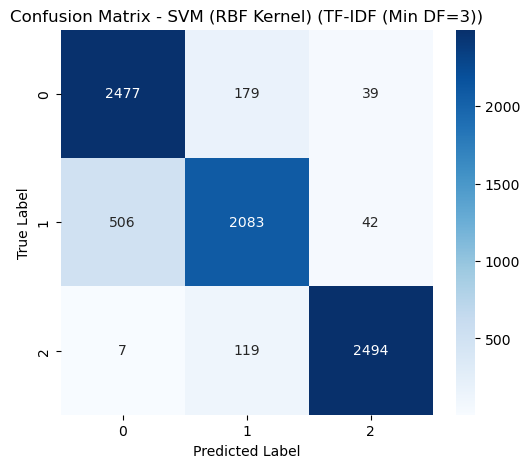


 Applying TF-IDF (L1 Normalization) with SVM (RBF Kernel)
 Accuracy (SMOTE applied - final_text - TF-IDF (L1 Normalization) - SVM (RBF Kernel)): 0.9186

 Classification Report:

              precision    recall  f1-score   support

           0       0.85      0.93      0.89      2695
           1       0.92      0.83      0.87      2631
           2       1.00      1.00      1.00      2620

    accuracy                           0.92      7946
   macro avg       0.92      0.92      0.92      7946
weighted avg       0.92      0.92      0.92      7946



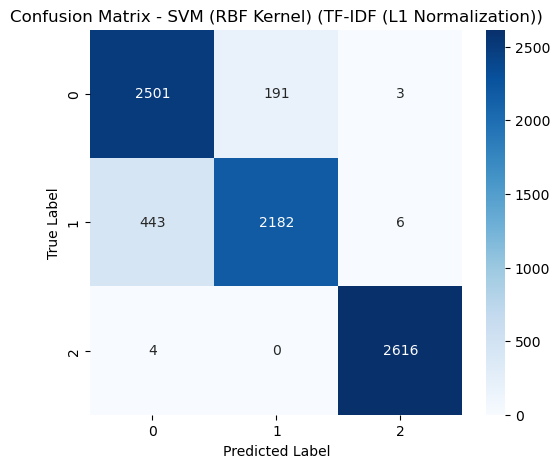


 Applying TF-IDF (Binary Term Presence) with SVM (RBF Kernel)
 Accuracy (SMOTE applied - final_text - TF-IDF (Binary Term Presence) - SVM (RBF Kernel)): 0.8988

 Classification Report:

              precision    recall  f1-score   support

           0       0.79      0.97      0.87      2695
           1       0.97      0.73      0.83      2631
           2       0.99      0.99      0.99      2620

    accuracy                           0.90      7946
   macro avg       0.91      0.90      0.90      7946
weighted avg       0.91      0.90      0.90      7946



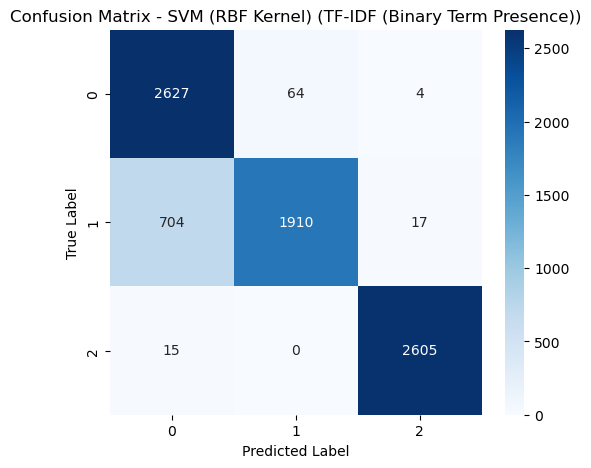


 Applying TF-IDF (N-gram 1-3) with SVM (RBF Kernel)
 Accuracy (SMOTE applied - final_text - TF-IDF (N-gram 1-3) - SVM (RBF Kernel)): 0.8889

 Classification Report:

              precision    recall  f1-score   support

           0       0.76      0.99      0.86      2695
           1       0.98      0.69      0.81      2631
           2       0.99      0.99      0.99      2620

    accuracy                           0.89      7946
   macro avg       0.91      0.89      0.89      7946
weighted avg       0.91      0.89      0.89      7946



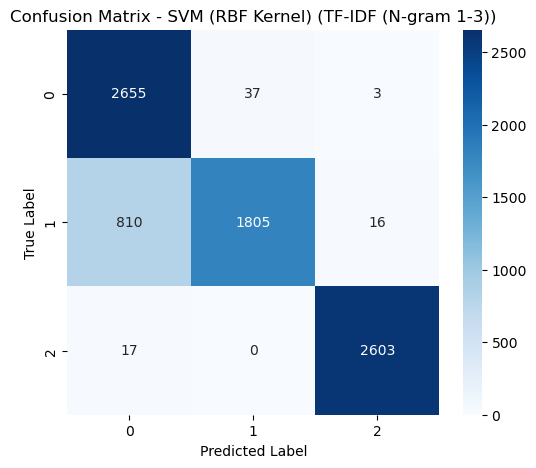

In [ ]:
# SVM (RBF Kernel)
train_and_evaluate("TF-IDF (Sublinear TF Scaling)", "SVM (RBF Kernel)")
train_and_evaluate("TF-IDF (Bigram)", "SVM (RBF Kernel)")
train_and_evaluate("TF-IDF (Feature Limited)", "SVM (RBF Kernel)")
train_and_evaluate("TF-IDF (Max Features=10000)", "SVM (RBF Kernel)")
train_and_evaluate("TF-IDF (Min DF=3)", "SVM (RBF Kernel)")
train_and_evaluate("TF-IDF (L1 Normalization)", "SVM (RBF Kernel)")
train_and_evaluate("TF-IDF (Binary Term Presence)", "SVM (RBF Kernel)")
train_and_evaluate("TF-IDF (N-gram 1-3)", "SVM (RBF Kernel)")


 Applying TF-IDF (Sublinear TF Scaling) with Decision Tree
 Accuracy (SMOTE applied - final_text - TF-IDF (Sublinear TF Scaling) - Decision Tree): 0.6135

 Classification Report:

              precision    recall  f1-score   support

           0       0.53      0.87      0.66      2695
           1       0.58      0.30      0.40      2631
           2       0.81      0.66      0.72      2620

    accuracy                           0.61      7946
   macro avg       0.64      0.61      0.59      7946
weighted avg       0.64      0.61      0.59      7946



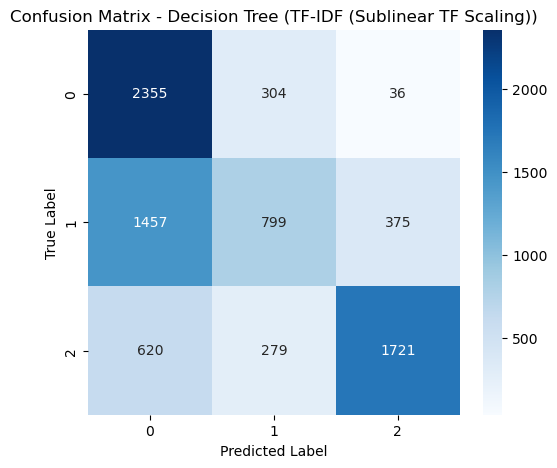


 Applying TF-IDF (Bigram) with Decision Tree
 Accuracy (SMOTE applied - final_text - TF-IDF (Bigram) - Decision Tree): 0.3998

 Classification Report:

              precision    recall  f1-score   support

           0       0.37      0.99      0.53      2695
           1       0.70      0.04      0.07      2631
           2       0.78      0.16      0.26      2620

    accuracy                           0.40      7946
   macro avg       0.62      0.39      0.29      7946
weighted avg       0.61      0.40      0.29      7946



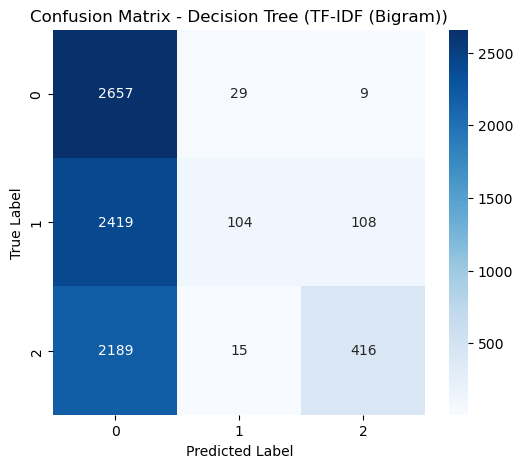


 Applying TF-IDF (Feature Limited) with Decision Tree
 Accuracy (SMOTE applied - final_text - TF-IDF (Feature Limited) - Decision Tree): 0.5690

 Classification Report:

              precision    recall  f1-score   support

           0       0.50      0.92      0.65      2695
           1       0.56      0.31      0.40      2631
           2       0.78      0.47      0.59      2620

    accuracy                           0.57      7946
   macro avg       0.62      0.57      0.54      7946
weighted avg       0.62      0.57      0.55      7946



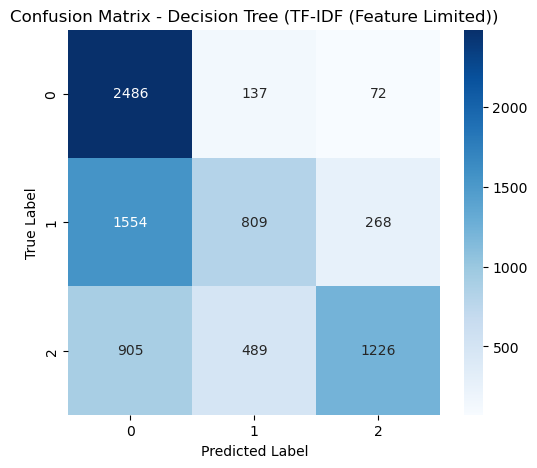


 Applying TF-IDF (Max Features=10000) with Decision Tree
 Accuracy (SMOTE applied - final_text - TF-IDF (Max Features=10000) - Decision Tree): 0.5861

 Classification Report:

              precision    recall  f1-score   support

           0       0.53      0.76      0.62      2695
           1       0.51      0.45      0.48      2631
           2       0.83      0.55      0.66      2620

    accuracy                           0.59      7946
   macro avg       0.62      0.58      0.59      7946
weighted avg       0.62      0.59      0.59      7946



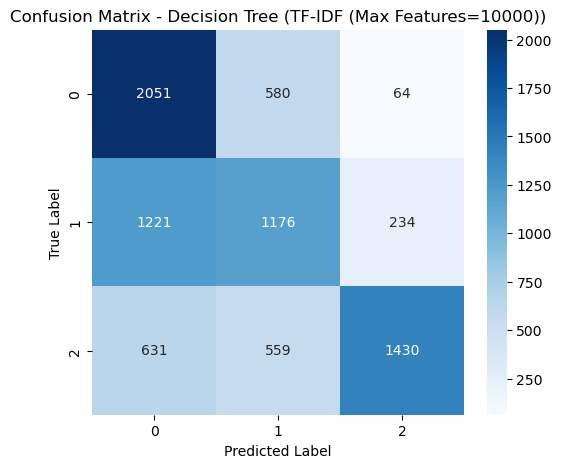


 Applying TF-IDF (Min DF=3) with Decision Tree
 Accuracy (SMOTE applied - final_text - TF-IDF (Min DF=3) - Decision Tree): 0.5848

 Classification Report:

              precision    recall  f1-score   support

           0       0.52      0.76      0.62      2695
           1       0.50      0.48      0.49      2631
           2       0.88      0.51      0.65      2620

    accuracy                           0.58      7946
   macro avg       0.64      0.58      0.59      7946
weighted avg       0.63      0.58      0.59      7946



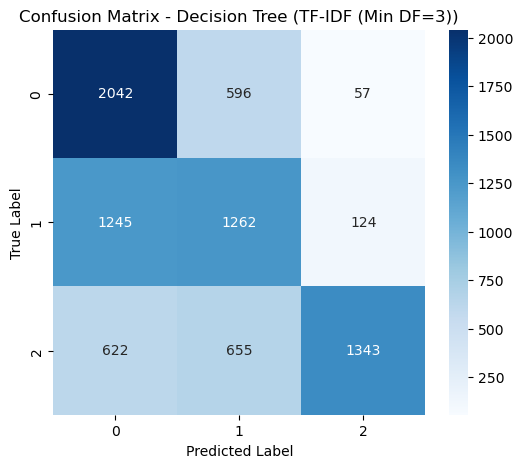


 Applying TF-IDF (L1 Normalization) with Decision Tree
 Accuracy (SMOTE applied - final_text - TF-IDF (L1 Normalization) - Decision Tree): 0.7874

 Classification Report:

              precision    recall  f1-score   support

           0       0.64      0.94      0.76      2695
           1       0.86      0.52      0.64      2631
           2       0.98      0.90      0.94      2620

    accuracy                           0.79      7946
   macro avg       0.83      0.79      0.78      7946
weighted avg       0.82      0.79      0.78      7946



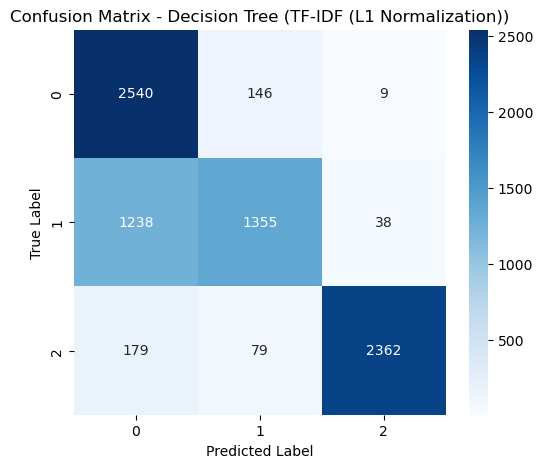


 Applying TF-IDF (Binary Term Presence) with Decision Tree
 Accuracy (SMOTE applied - final_text - TF-IDF (Binary Term Presence) - Decision Tree): 0.6168

 Classification Report:

              precision    recall  f1-score   support

           0       0.54      0.88      0.67      2695
           1       0.58      0.34      0.43      2631
           2       0.82      0.63      0.71      2620

    accuracy                           0.62      7946
   macro avg       0.64      0.61      0.60      7946
weighted avg       0.64      0.62      0.60      7946



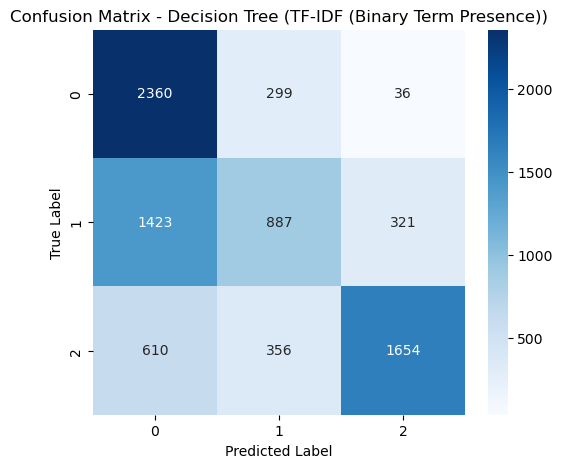


 Applying TF-IDF (N-gram 1-3) with Decision Tree
 Accuracy (SMOTE applied - final_text - TF-IDF (N-gram 1-3) - Decision Tree): 0.6014

 Classification Report:

              precision    recall  f1-score   support

           0       0.52      0.87      0.65      2695
           1       0.55      0.33      0.41      2631
           2       0.82      0.61      0.70      2620

    accuracy                           0.60      7946
   macro avg       0.63      0.60      0.59      7946
weighted avg       0.63      0.60      0.59      7946



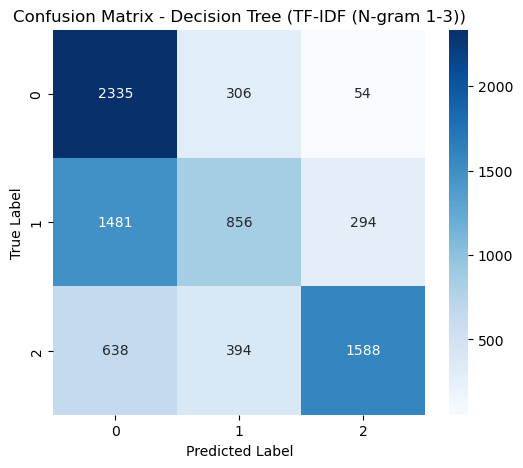

In [ ]:
# Decision Tree
train_and_evaluate("TF-IDF (Sublinear TF Scaling)", "Decision Tree")
train_and_evaluate("TF-IDF (Bigram)", "Decision Tree")
train_and_evaluate("TF-IDF (Feature Limited)", "Decision Tree")
train_and_evaluate("TF-IDF (Max Features=10000)", "Decision Tree")
train_and_evaluate("TF-IDF (Min DF=3)", "Decision Tree")
train_and_evaluate("TF-IDF (L1 Normalization)", "Decision Tree")
train_and_evaluate("TF-IDF (Binary Term Presence)", "Decision Tree")
train_and_evaluate("TF-IDF (N-gram 1-3)", "Decision Tree")


 Applying TF-IDF (Sublinear TF Scaling) with Naïve Bayes
 Accuracy (SMOTE applied - final_text - TF-IDF (Sublinear TF Scaling) - Naïve Bayes): 0.8263

 Classification Report:

              precision    recall  f1-score   support

           0       0.91      0.61      0.73      2695
           1       0.75      0.87      0.81      2631
           2       0.85      1.00      0.92      2620

    accuracy                           0.83      7946
   macro avg       0.84      0.83      0.82      7946
weighted avg       0.84      0.83      0.82      7946



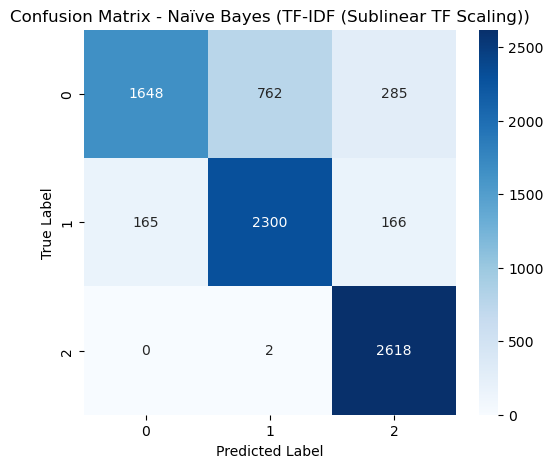


 Applying TF-IDF (Bigram) with Naïve Bayes
 Accuracy (SMOTE applied - final_text - TF-IDF (Bigram) - Naïve Bayes): 0.7564

 Classification Report:

              precision    recall  f1-score   support

           0       0.82      0.49      0.62      2695
           1       0.77      0.79      0.78      2631
           2       0.71      0.99      0.83      2620

    accuracy                           0.76      7946
   macro avg       0.77      0.76      0.74      7946
weighted avg       0.77      0.76      0.74      7946



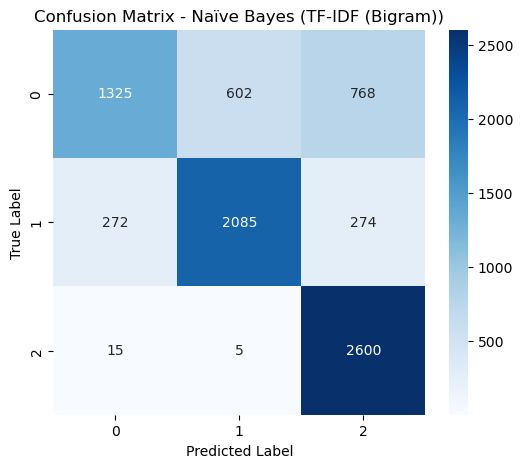


 Applying TF-IDF (Feature Limited) with Naïve Bayes
 Accuracy (SMOTE applied - final_text - TF-IDF (Feature Limited) - Naïve Bayes): 0.7426

 Classification Report:

              precision    recall  f1-score   support

           0       0.73      0.64      0.69      2695
           1       0.72      0.65      0.68      2631
           2       0.77      0.94      0.85      2620

    accuracy                           0.74      7946
   macro avg       0.74      0.74      0.74      7946
weighted avg       0.74      0.74      0.74      7946



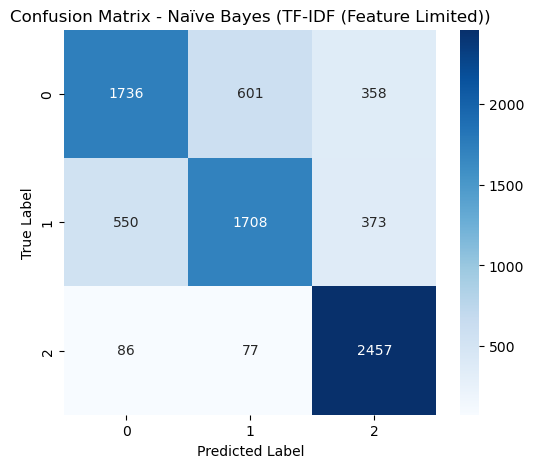


 Applying TF-IDF (Max Features=10000) with Naïve Bayes
 Accuracy (SMOTE applied - final_text - TF-IDF (Max Features=10000) - Naïve Bayes): 0.7683

 Classification Report:

              precision    recall  f1-score   support

           0       0.76      0.66      0.71      2695
           1       0.74      0.67      0.70      2631
           2       0.79      0.98      0.88      2620

    accuracy                           0.77      7946
   macro avg       0.77      0.77      0.76      7946
weighted avg       0.77      0.77      0.76      7946



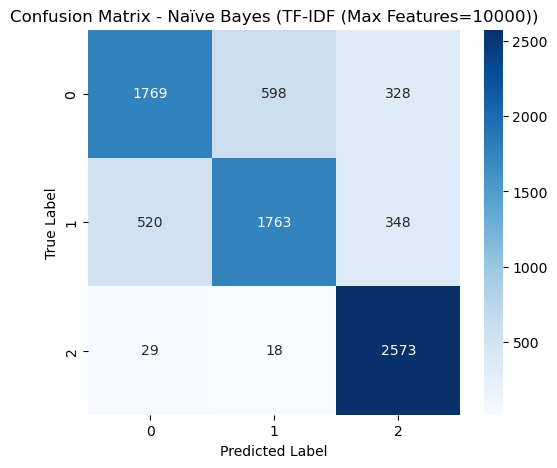


 Applying TF-IDF (Min DF=3) with Naïve Bayes
 Accuracy (SMOTE applied - final_text - TF-IDF (Min DF=3) - Naïve Bayes): 0.7678

 Classification Report:

              precision    recall  f1-score   support

           0       0.76      0.65      0.70      2695
           1       0.74      0.67      0.70      2631
           2       0.79      0.98      0.88      2620

    accuracy                           0.77      7946
   macro avg       0.76      0.77      0.76      7946
weighted avg       0.76      0.77      0.76      7946



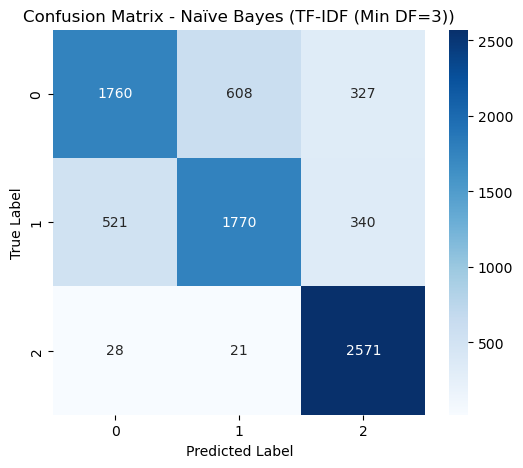


 Applying TF-IDF (L1 Normalization) with Naïve Bayes
 Accuracy (SMOTE applied - final_text - TF-IDF (L1 Normalization) - Naïve Bayes): 0.8207

 Classification Report:

              precision    recall  f1-score   support

           0       0.85      0.67      0.75      2695
           1       0.79      0.81      0.80      2631
           2       0.83      0.99      0.90      2620

    accuracy                           0.82      7946
   macro avg       0.82      0.82      0.82      7946
weighted avg       0.82      0.82      0.82      7946



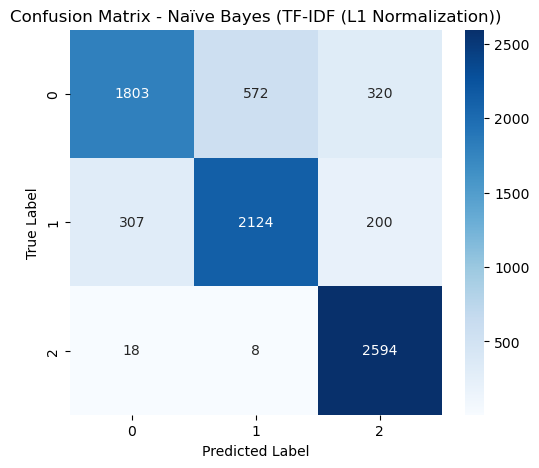


 Applying TF-IDF (Binary Term Presence) with Naïve Bayes
 Accuracy (SMOTE applied - final_text - TF-IDF (Binary Term Presence) - Naïve Bayes): 0.8319

 Classification Report:

              precision    recall  f1-score   support

           0       0.91      0.62      0.74      2695
           1       0.76      0.88      0.81      2631
           2       0.86      1.00      0.92      2620

    accuracy                           0.83      7946
   macro avg       0.84      0.83      0.83      7946
weighted avg       0.84      0.83      0.82      7946



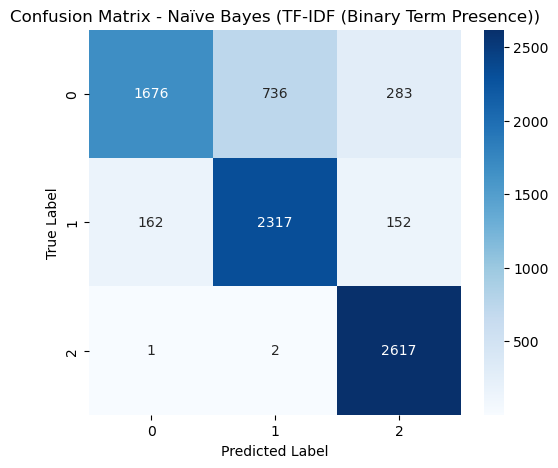


 Applying TF-IDF (N-gram 1-3) with Naïve Bayes
 Accuracy (SMOTE applied - final_text - TF-IDF (N-gram 1-3) - Naïve Bayes): 0.8334

 Classification Report:

              precision    recall  f1-score   support

           0       0.92      0.61      0.74      2695
           1       0.76      0.89      0.82      2631
           2       0.86      1.00      0.93      2620

    accuracy                           0.83      7946
   macro avg       0.85      0.84      0.83      7946
weighted avg       0.85      0.83      0.83      7946



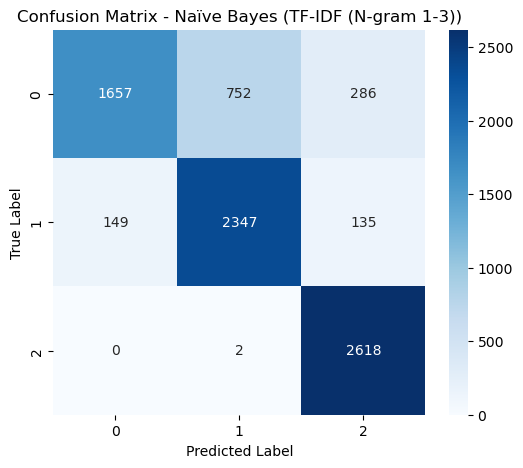

In [ ]:
# Naïve Bayes
train_and_evaluate("TF-IDF (Sublinear TF Scaling)", "Naïve Bayes")
train_and_evaluate("TF-IDF (Bigram)", "Naïve Bayes")
train_and_evaluate("TF-IDF (Feature Limited)", "Naïve Bayes")
train_and_evaluate("TF-IDF (Max Features=10000)", "Naïve Bayes")
train_and_evaluate("TF-IDF (Min DF=3)", "Naïve Bayes")
train_and_evaluate("TF-IDF (L1 Normalization)", "Naïve Bayes")
train_and_evaluate("TF-IDF (Binary Term Presence)", "Naïve Bayes")
train_and_evaluate("TF-IDF (N-gram 1-3)", "Naïve Bayes")


 Applying TF-IDF (Sublinear TF Scaling) with Random Forest
 Accuracy (SMOTE applied - final_text - TF-IDF (Sublinear TF Scaling) - Random Forest): 0.8972

 Classification Report:

              precision    recall  f1-score   support

           0       0.80      0.94      0.87      2695
           1       0.93      0.77      0.84      2631
           2       0.99      0.99      0.99      2620

    accuracy                           0.90      7946
   macro avg       0.91      0.90      0.90      7946
weighted avg       0.90      0.90      0.90      7946



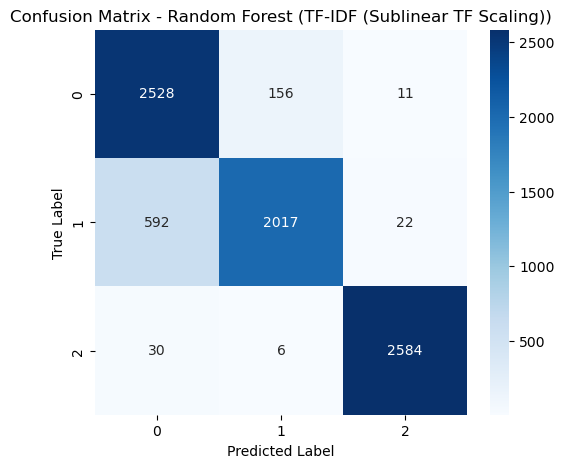


 Applying TF-IDF (Bigram) with Random Forest
 Accuracy (SMOTE applied - final_text - TF-IDF (Bigram) - Random Forest): 0.7598

 Classification Report:

              precision    recall  f1-score   support

           0       0.81      0.59      0.68      2695
           1       0.85      0.71      0.77      2631
           2       0.68      0.99      0.81      2620

    accuracy                           0.76      7946
   macro avg       0.78      0.76      0.75      7946
weighted avg       0.78      0.76      0.75      7946



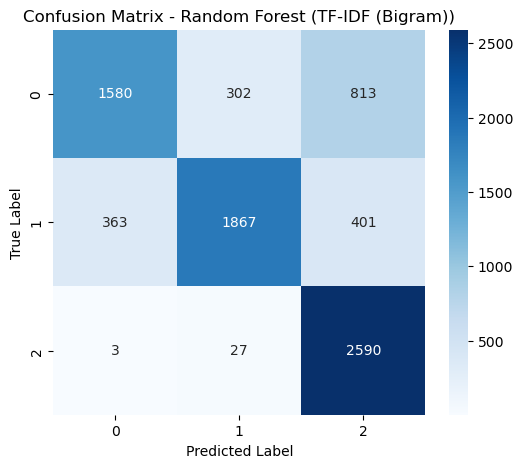


 Applying TF-IDF (Feature Limited) with Random Forest
 Accuracy (SMOTE applied - final_text - TF-IDF (Feature Limited) - Random Forest): 0.8563

 Classification Report:

              precision    recall  f1-score   support

           0       0.80      0.86      0.83      2695
           1       0.85      0.74      0.79      2631
           2       0.93      0.97      0.95      2620

    accuracy                           0.86      7946
   macro avg       0.86      0.86      0.85      7946
weighted avg       0.86      0.86      0.85      7946



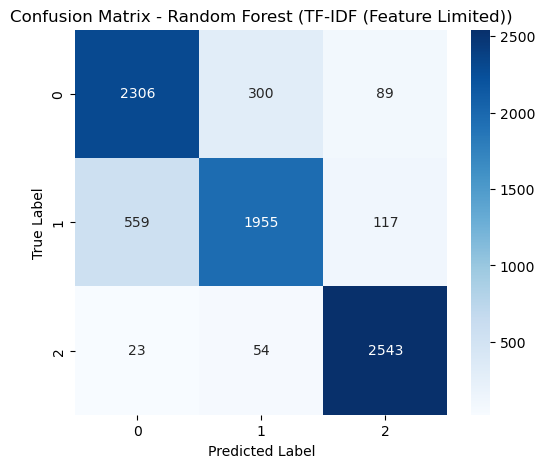


 Applying TF-IDF (Max Features=10000) with Random Forest
 Accuracy (SMOTE applied - final_text - TF-IDF (Max Features=10000) - Random Forest): 0.8696

 Classification Report:

              precision    recall  f1-score   support

           0       0.81      0.87      0.84      2695
           1       0.85      0.77      0.81      2631
           2       0.95      0.97      0.96      2620

    accuracy                           0.87      7946
   macro avg       0.87      0.87      0.87      7946
weighted avg       0.87      0.87      0.87      7946



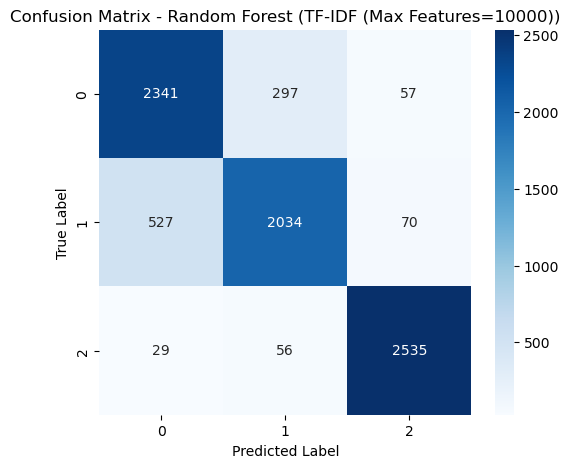


 Applying TF-IDF (Min DF=3) with Random Forest
 Accuracy (SMOTE applied - final_text - TF-IDF (Min DF=3) - Random Forest): 0.8661

 Classification Report:

              precision    recall  f1-score   support

           0       0.81      0.86      0.83      2695
           1       0.85      0.77      0.81      2631
           2       0.94      0.96      0.95      2620

    accuracy                           0.87      7946
   macro avg       0.87      0.87      0.87      7946
weighted avg       0.87      0.87      0.87      7946



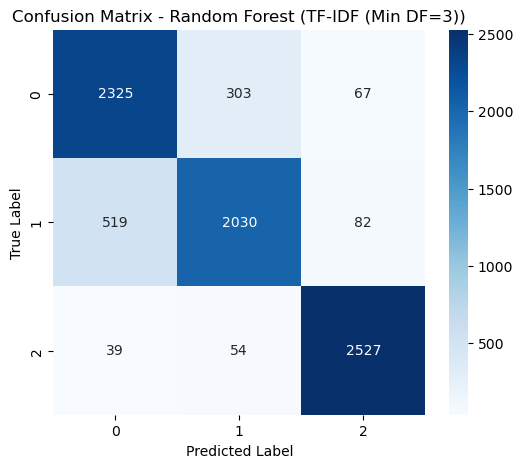


 Applying TF-IDF (L1 Normalization) with Random Forest
 Accuracy (SMOTE applied - final_text - TF-IDF (L1 Normalization) - Random Forest): 0.8748

 Classification Report:

              precision    recall  f1-score   support

           0       0.75      0.98      0.85      2695
           1       0.96      0.69      0.80      2631
           2       0.99      0.95      0.97      2620

    accuracy                           0.87      7946
   macro avg       0.90      0.87      0.87      7946
weighted avg       0.90      0.87      0.87      7946



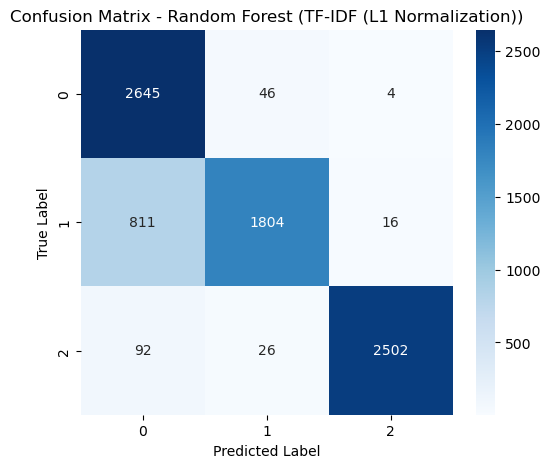


 Applying TF-IDF (Binary Term Presence) with Random Forest
 Accuracy (SMOTE applied - final_text - TF-IDF (Binary Term Presence) - Random Forest): 0.8958

 Classification Report:

              precision    recall  f1-score   support

           0       0.80      0.94      0.86      2695
           1       0.93      0.76      0.83      2631
           2       0.99      0.99      0.99      2620

    accuracy                           0.90      7946
   macro avg       0.90      0.90      0.90      7946
weighted avg       0.90      0.90      0.89      7946



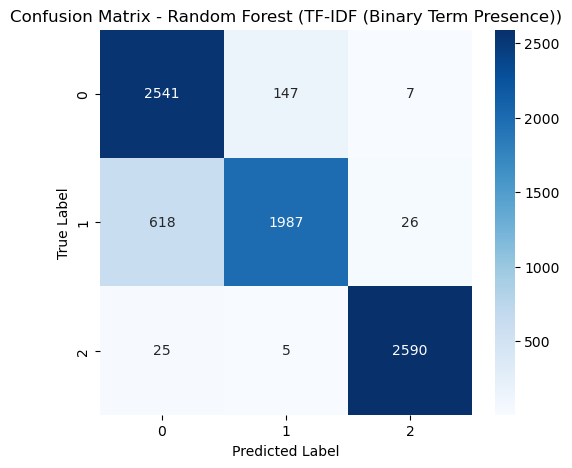


 Applying TF-IDF (N-gram 1-3) with Random Forest
 Accuracy (SMOTE applied - final_text - TF-IDF (N-gram 1-3) - Random Forest): 0.8974

 Classification Report:

              precision    recall  f1-score   support

           0       0.80      0.95      0.87      2695
           1       0.94      0.75      0.84      2631
           2       0.99      0.98      0.99      2620

    accuracy                           0.90      7946
   macro avg       0.91      0.90      0.90      7946
weighted avg       0.91      0.90      0.90      7946



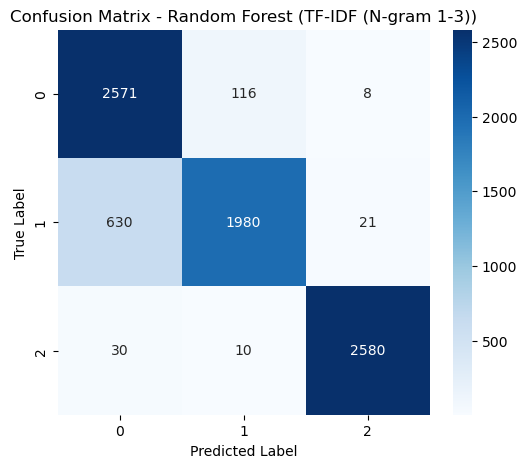

In [ ]:
# Random Forest
train_and_evaluate("TF-IDF (Sublinear TF Scaling)", "Random Forest")
train_and_evaluate("TF-IDF (Bigram)", "Random Forest")
train_and_evaluate("TF-IDF (Feature Limited)", "Random Forest")
train_and_evaluate("TF-IDF (Max Features=10000)", "Random Forest")
train_and_evaluate("TF-IDF (Min DF=3)", "Random Forest")
train_and_evaluate("TF-IDF (L1 Normalization)", "Random Forest")
train_and_evaluate("TF-IDF (Binary Term Presence)", "Random Forest")
train_and_evaluate("TF-IDF (N-gram 1-3)", "Random Forest")


 Applying TF-IDF (Sublinear TF Scaling) with XGBoost
 Accuracy (SMOTE applied - final_text - TF-IDF (Sublinear TF Scaling) - XGBoost): 0.8248

 Classification Report:

              precision    recall  f1-score   support

           0       0.73      0.92      0.82      2695
           1       0.86      0.63      0.73      2631
           2       0.92      0.92      0.92      2620

    accuracy                           0.82      7946
   macro avg       0.84      0.82      0.82      7946
weighted avg       0.84      0.82      0.82      7946



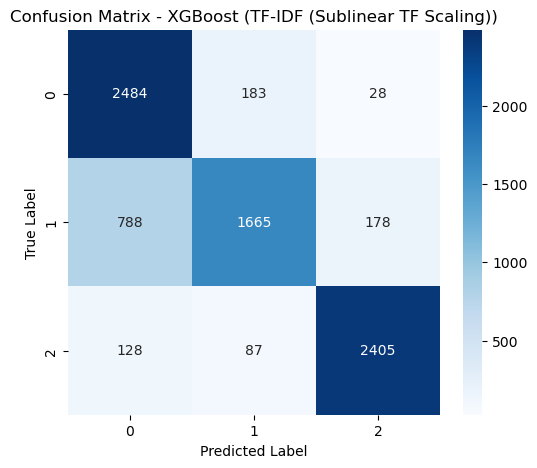


 Applying TF-IDF (Bigram) with XGBoost
 Accuracy (SMOTE applied - final_text - TF-IDF (Bigram) - XGBoost): 0.7056

 Classification Report:

              precision    recall  f1-score   support

           0       0.57      0.90      0.70      2695
           1       0.75      0.42      0.54      2631
           2       0.92      0.80      0.86      2620

    accuracy                           0.71      7946
   macro avg       0.75      0.70      0.70      7946
weighted avg       0.75      0.71      0.70      7946



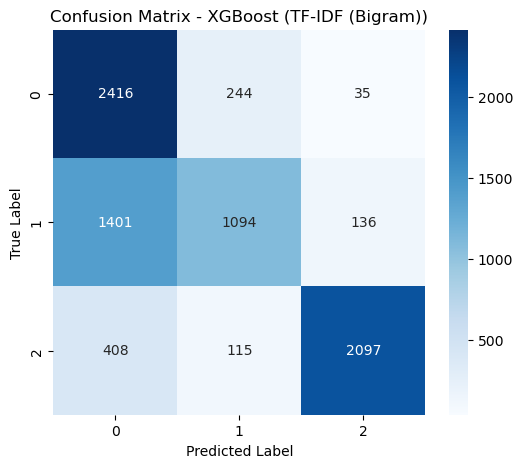


 Applying TF-IDF (Feature Limited) with XGBoost
 Accuracy (SMOTE applied - final_text - TF-IDF (Feature Limited) - XGBoost): 0.7614

 Classification Report:

              precision    recall  f1-score   support

           0       0.68      0.87      0.77      2695
           1       0.80      0.56      0.66      2631
           2       0.84      0.85      0.84      2620

    accuracy                           0.76      7946
   macro avg       0.77      0.76      0.76      7946
weighted avg       0.77      0.76      0.76      7946



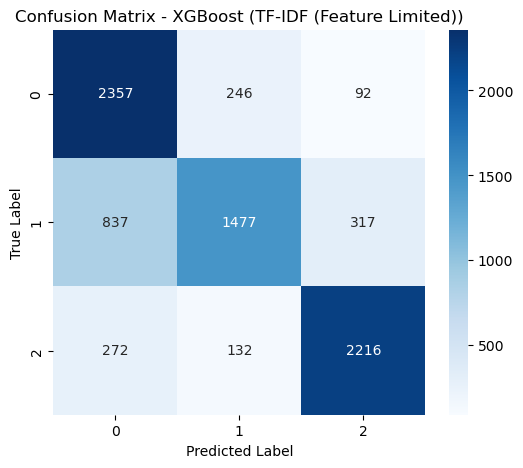


 Applying TF-IDF (Max Features=10000) with XGBoost
 Accuracy (SMOTE applied - final_text - TF-IDF (Max Features=10000) - XGBoost): 0.7793

 Classification Report:

              precision    recall  f1-score   support

           0       0.69      0.88      0.77      2695
           1       0.79      0.61      0.69      2631
           2       0.90      0.84      0.87      2620

    accuracy                           0.78      7946
   macro avg       0.79      0.78      0.78      7946
weighted avg       0.79      0.78      0.78      7946



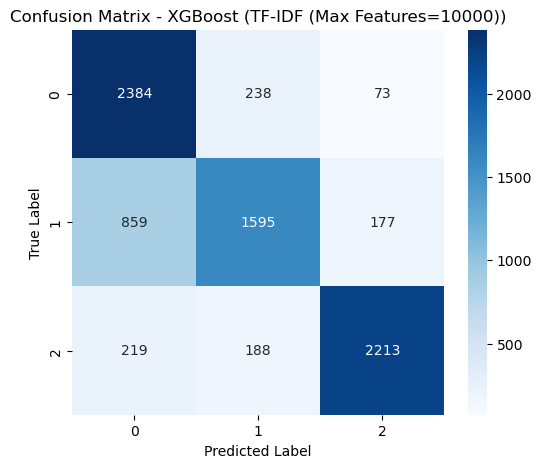


 Applying TF-IDF (Min DF=3) with XGBoost
 Accuracy (SMOTE applied - final_text - TF-IDF (Min DF=3) - XGBoost): 0.7791

 Classification Report:

              precision    recall  f1-score   support

           0       0.69      0.88      0.77      2695
           1       0.79      0.61      0.69      2631
           2       0.90      0.85      0.87      2620

    accuracy                           0.78      7946
   macro avg       0.79      0.78      0.78      7946
weighted avg       0.79      0.78      0.78      7946



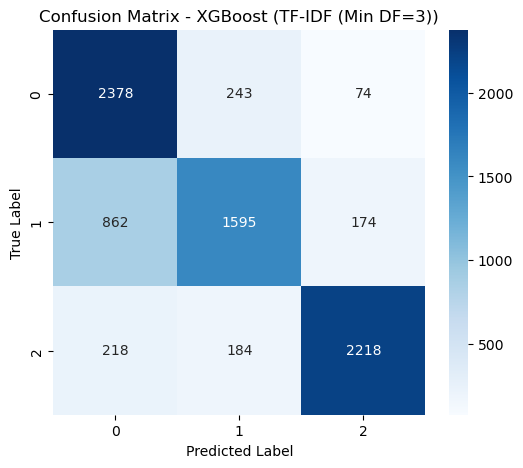


 Applying TF-IDF (L1 Normalization) with XGBoost
 Accuracy (SMOTE applied - final_text - TF-IDF (L1 Normalization) - XGBoost): 0.8696

 Classification Report:

              precision    recall  f1-score   support

           0       0.76      0.94      0.84      2695
           1       0.90      0.73      0.80      2631
           2       0.98      0.95      0.96      2620

    accuracy                           0.87      7946
   macro avg       0.88      0.87      0.87      7946
weighted avg       0.88      0.87      0.87      7946



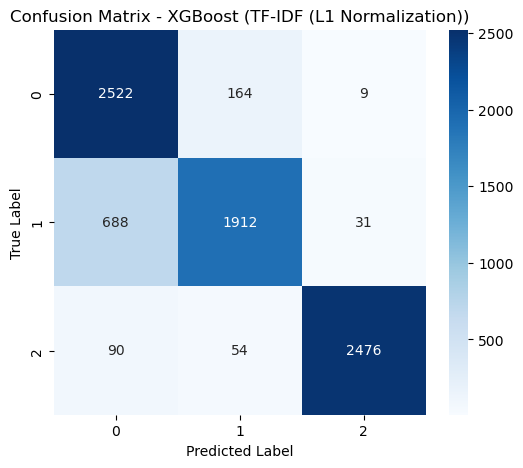


 Applying TF-IDF (Binary Term Presence) with XGBoost
 Accuracy (SMOTE applied - final_text - TF-IDF (Binary Term Presence) - XGBoost): 0.8272

 Classification Report:

              precision    recall  f1-score   support

           0       0.73      0.92      0.82      2695
           1       0.86      0.64      0.73      2631
           2       0.93      0.92      0.92      2620

    accuracy                           0.83      7946
   macro avg       0.84      0.83      0.82      7946
weighted avg       0.84      0.83      0.82      7946



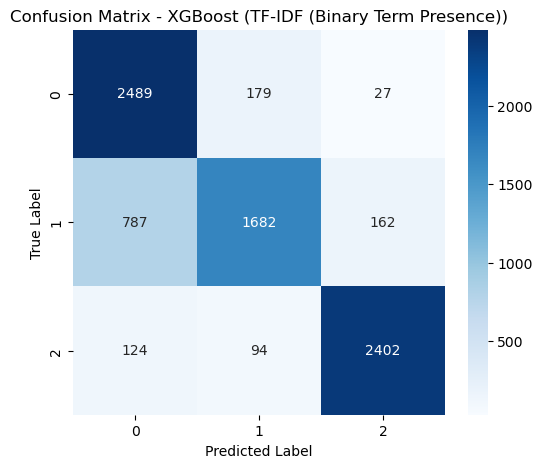


 Applying TF-IDF (N-gram 1-3) with XGBoost
 Accuracy (SMOTE applied - final_text - TF-IDF (N-gram 1-3) - XGBoost): 0.8286

 Classification Report:

              precision    recall  f1-score   support

           0       0.73      0.92      0.81      2695
           1       0.87      0.65      0.74      2631
           2       0.93      0.92      0.92      2620

    accuracy                           0.83      7946
   macro avg       0.84      0.83      0.83      7946
weighted avg       0.84      0.83      0.83      7946



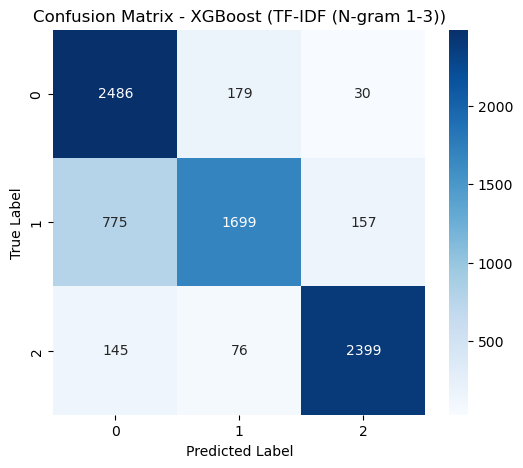

In [ ]:
# XGBoost
train_and_evaluate("TF-IDF (Sublinear TF Scaling)", "XGBoost")
train_and_evaluate("TF-IDF (Bigram)", "XGBoost")
train_and_evaluate("TF-IDF (Feature Limited)", "XGBoost")
train_and_evaluate("TF-IDF (Max Features=10000)", "XGBoost")
train_and_evaluate("TF-IDF (Min DF=3)", "XGBoost")
train_and_evaluate("TF-IDF (L1 Normalization)", "XGBoost")
train_and_evaluate("TF-IDF (Binary Term Presence)", "XGBoost")
train_and_evaluate("TF-IDF (N-gram 1-3)", "XGBoost")


 Applying TF-IDF (Sublinear TF Scaling) with Voting Classifier
 Accuracy (SMOTE applied - final_text - TF-IDF (Sublinear TF Scaling) - Voting Classifier): 0.9200

 Classification Report:

              precision    recall  f1-score   support

           0       0.87      0.91      0.89      2695
           1       0.91      0.85      0.88      2631
           2       0.99      1.00      0.99      2620

    accuracy                           0.92      7946
   macro avg       0.92      0.92      0.92      7946
weighted avg       0.92      0.92      0.92      7946



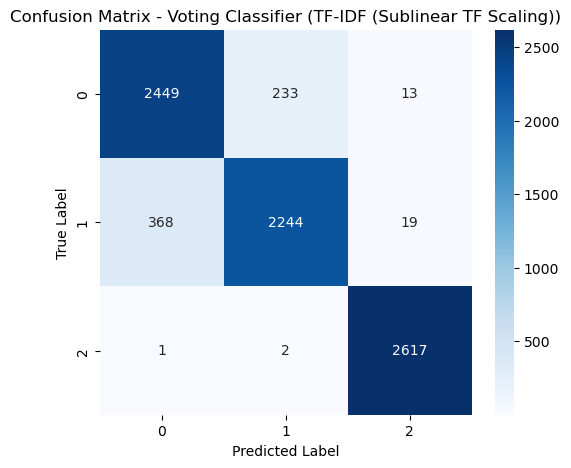


 Applying TF-IDF (Bigram) with Voting Classifier
 Accuracy (SMOTE applied - final_text - TF-IDF (Bigram) - Voting Classifier): 0.8223

 Classification Report:

              precision    recall  f1-score   support

           0       0.81      0.72      0.76      2695
           1       0.84      0.77      0.80      2631
           2       0.82      0.99      0.90      2620

    accuracy                           0.82      7946
   macro avg       0.82      0.82      0.82      7946
weighted avg       0.82      0.82      0.82      7946



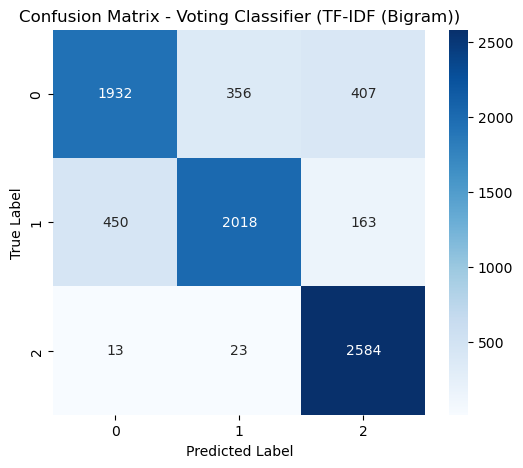


 Applying TF-IDF (Feature Limited) with Voting Classifier
 Accuracy (SMOTE applied - final_text - TF-IDF (Feature Limited) - Voting Classifier): 0.8366

 Classification Report:

              precision    recall  f1-score   support

           0       0.81      0.79      0.80      2695
           1       0.80      0.76      0.78      2631
           2       0.89      0.96      0.93      2620

    accuracy                           0.84      7946
   macro avg       0.83      0.84      0.84      7946
weighted avg       0.83      0.84      0.84      7946



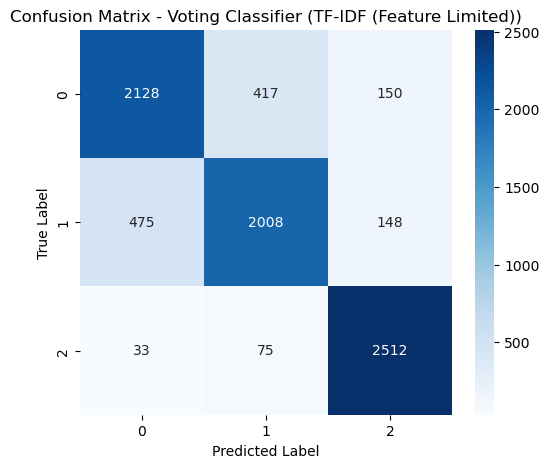


 Applying TF-IDF (Max Features=10000) with Voting Classifier
 Accuracy (SMOTE applied - final_text - TF-IDF (Max Features=10000) - Voting Classifier): 0.8458

 Classification Report:

              precision    recall  f1-score   support

           0       0.82      0.80      0.81      2695
           1       0.79      0.79      0.79      2631
           2       0.92      0.95      0.94      2620

    accuracy                           0.85      7946
   macro avg       0.85      0.85      0.85      7946
weighted avg       0.84      0.85      0.85      7946



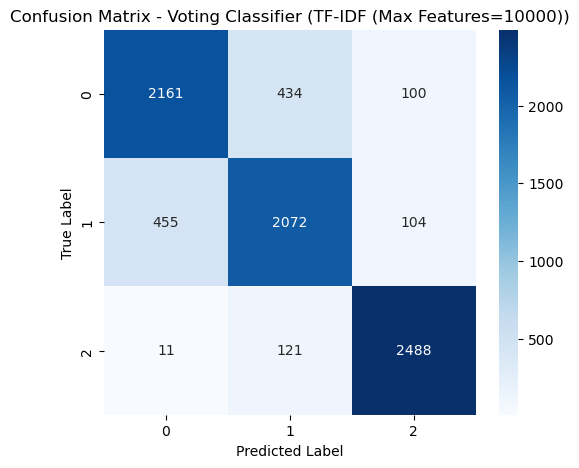


 Applying TF-IDF (Min DF=3) with Voting Classifier
 Accuracy (SMOTE applied - final_text - TF-IDF (Min DF=3) - Voting Classifier): 0.8480

 Classification Report:

              precision    recall  f1-score   support

           0       0.83      0.81      0.82      2695
           1       0.79      0.79      0.79      2631
           2       0.92      0.95      0.94      2620

    accuracy                           0.85      7946
   macro avg       0.85      0.85      0.85      7946
weighted avg       0.85      0.85      0.85      7946



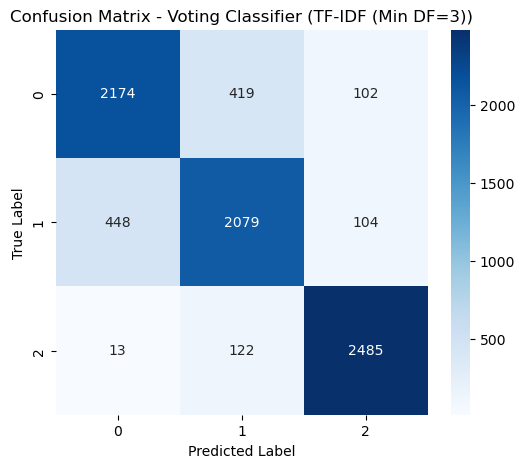


 Applying TF-IDF (L1 Normalization) with Voting Classifier
 Accuracy (SMOTE applied - final_text - TF-IDF (L1 Normalization) - Voting Classifier): 0.8738

 Classification Report:

              precision    recall  f1-score   support

           0       0.75      0.96      0.85      2695
           1       0.95      0.69      0.80      2631
           2       0.98      0.97      0.97      2620

    accuracy                           0.87      7946
   macro avg       0.89      0.87      0.87      7946
weighted avg       0.89      0.87      0.87      7946



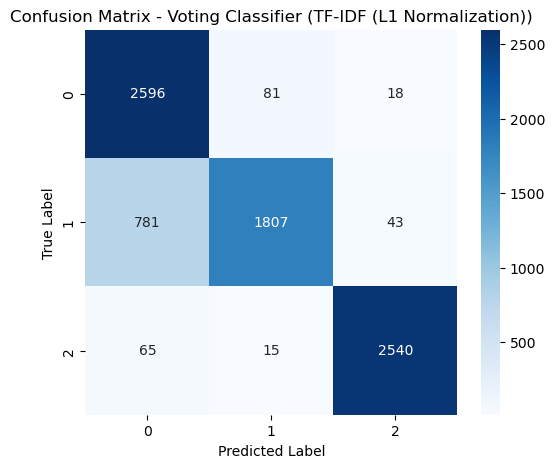


 Applying TF-IDF (Binary Term Presence) with Voting Classifier
 Accuracy (SMOTE applied - final_text - TF-IDF (Binary Term Presence) - Voting Classifier): 0.9202

 Classification Report:

              precision    recall  f1-score   support

           0       0.87      0.91      0.89      2695
           1       0.91      0.85      0.88      2631
           2       0.99      1.00      0.99      2620

    accuracy                           0.92      7946
   macro avg       0.92      0.92      0.92      7946
weighted avg       0.92      0.92      0.92      7946



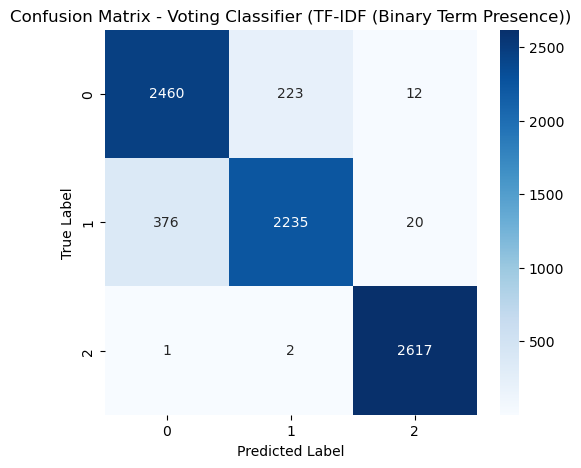


 Applying TF-IDF (N-gram 1-3) with Voting Classifier
 Accuracy (SMOTE applied - final_text - TF-IDF (N-gram 1-3) - Voting Classifier): 0.9246

 Classification Report:

              precision    recall  f1-score   support

           0       0.87      0.92      0.90      2695
           1       0.92      0.85      0.88      2631
           2       0.99      1.00      0.99      2620

    accuracy                           0.92      7946
   macro avg       0.93      0.92      0.92      7946
weighted avg       0.93      0.92      0.92      7946



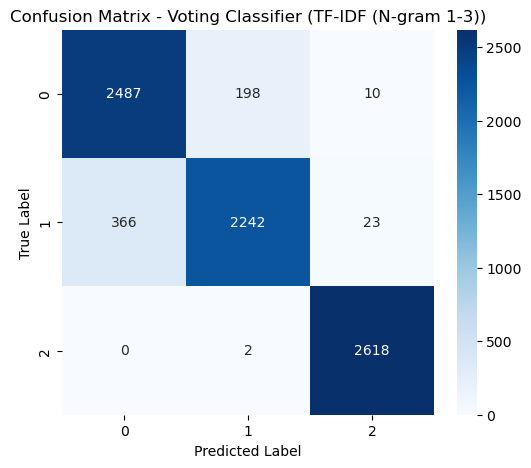

In [ ]:
# Voting Classifier
train_and_evaluate("TF-IDF (Sublinear TF Scaling)", "Voting Classifier")
train_and_evaluate("TF-IDF (Bigram)", "Voting Classifier")
train_and_evaluate("TF-IDF (Feature Limited)", "Voting Classifier")
train_and_evaluate("TF-IDF (Max Features=10000)", "Voting Classifier")
train_and_evaluate("TF-IDF (Min DF=3)", "Voting Classifier")
train_and_evaluate("TF-IDF (L1 Normalization)", "Voting Classifier")
train_and_evaluate("TF-IDF (Binary Term Presence)", "Voting Classifier")
train_and_evaluate("TF-IDF (N-gram 1-3)", "Voting Classifier")

**Evaluate Performance on Both Training and Validation Sets**

In [ ]:


# Function to Train and Evaluate Model
def train_and_evaluate(vectorizer_name, model_name):
    """
    Function to apply vectorization, train a selected model, and evaluate performance.

    Parameters:
    - vectorizer_name (str): The name of the vectorization technique.
    - model_name (str): The name of the model to train.
    """
    print(f"\n Applying {vectorizer_name} with {model_name}")

    # Get the selected vectorizer
    vectorizer = vectorization_techniques[vectorizer_name]

    # Apply Vectorization
    X_vectorized = vectorizer.fit_transform(df[text_version])

    # Encode Labels
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(df['label'])  # Convert labels ('NOT', 'TIN', 'UNT') into (0, 1, 2)

    # Apply SMOTE before splitting
    smote = SMOTE(random_state=100)
    X_resampled, y_resampled = smote.fit_resample(X_vectorized, y_encoded)

    # Split data
    X_train, X_val, y_train, y_val = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=100)

    # Select Model
    best_model = models[model_name]

    # Train Model
    best_model.fit(X_train, y_train)

    # Make Predictions
    y_train_pred = best_model.predict(X_train)
    y_val_pred = best_model.predict(X_val)

    # Compute Accuracies
    train_accuracy = accuracy_score(y_train, y_train_pred)
    val_accuracy = accuracy_score(y_val, y_val_pred)

    print(f" Training Accuracy: {train_accuracy:.4f}")
    print(f" Validation Accuracy: {val_accuracy:.4f}")

    # Check for overfitting or underfitting
    if train_accuracy > val_accuracy + 0.1:
        print(f" **Warning: {model_name} is Overfitting!**")
    elif train_accuracy < 0.7 and val_accuracy < 0.7:
        print(f" **Warning: {model_name} is Underfitting!**")
    else:
        print(f" {model_name} is performing well.")

    # Classification Report
    print("\n Classification Report:\n")
    print(classification_report(y_val, y_val_pred))

    # Generate and Plot Confusion Matrix
    conf_matrix = confusion_matrix(y_val, y_val_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues", xticklabels=np.unique(y_encoded), yticklabels=np.unique(y_encoded))
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"Confusion Matrix - {model_name} ({vectorizer_name})")
    plt.show()

In [ ]:
# Function Calls for All Models Across All Vectorization Techniques

# SVM (RBF Kernel)
train_and_evaluate("TF-IDF (Sublinear TF Scaling)", "SVM (RBF Kernel)")
train_and_evaluate("TF-IDF (Bigram)", "SVM (RBF Kernel)")
train_and_evaluate("TF-IDF (Feature Limited)", "SVM (RBF Kernel)")
train_and_evaluate("TF-IDF (Max Features=10000)", "SVM (RBF Kernel)")
train_and_evaluate("TF-IDF (Min DF=3)", "SVM (RBF Kernel)")
train_and_evaluate("TF-IDF (L1 Normalization)", "SVM (RBF Kernel)")
train_and_evaluate("TF-IDF (Binary Term Presence)", "SVM (RBF Kernel)")
train_and_evaluate("TF-IDF (N-gram 1-3)", "SVM (RBF Kernel)")

# Decision Tree
train_and_evaluate("TF-IDF (Sublinear TF Scaling)", "Decision Tree")
train_and_evaluate("TF-IDF (Bigram)", "Decision Tree")
train_and_evaluate("TF-IDF (Feature Limited)", "Decision Tree")
train_and_evaluate("TF-IDF (Max Features=10000)", "Decision Tree")
train_and_evaluate("TF-IDF (Min DF=3)", "Decision Tree")
train_and_evaluate("TF-IDF (L1 Normalization)", "Decision Tree")
train_and_evaluate("TF-IDF (Binary Term Presence)", "Decision Tree")
train_and_evaluate("TF-IDF (N-gram 1-3)", "Decision Tree")

# Naïve Bayes
train_and_evaluate("TF-IDF (Sublinear TF Scaling)", "Naïve Bayes")
train_and_evaluate("TF-IDF (Bigram)", "Naïve Bayes")
train_and_evaluate("TF-IDF (Feature Limited)", "Naïve Bayes")
train_and_evaluate("TF-IDF (Max Features=10000)", "Naïve Bayes")
train_and_evaluate("TF-IDF (Min DF=3)", "Naïve Bayes")
train_and_evaluate("TF-IDF (L1 Normalization)", "Naïve Bayes")
train_and_evaluate("TF-IDF (Binary Term Presence)", "Naïve Bayes")
train_and_evaluate("TF-IDF (N-gram 1-3)", "Naïve Bayes")

# Random Forest
train_and_evaluate("TF-IDF (Sublinear TF Scaling)", "Random Forest")
train_and_evaluate("TF-IDF (Bigram)", "Random Forest")
train_and_evaluate("TF-IDF (Feature Limited)", "Random Forest")
train_and_evaluate("TF-IDF (Max Features=10000)", "Random Forest")
train_and_evaluate("TF-IDF (Min DF=3)", "Random Forest")
train_and_evaluate("TF-IDF (L1 Normalization)", "Random Forest")
train_and_evaluate("TF-IDF (Binary Term Presence)", "Random Forest")
train_and_evaluate("TF-IDF (N-gram 1-3)", "Random Forest")

# XGBoost
train_and_evaluate("TF-IDF (Sublinear TF Scaling)", "XGBoost")
train_and_evaluate("TF-IDF (Bigram)", "XGBoost")
train_and_evaluate("TF-IDF (Feature Limited)", "XGBoost")
train_and_evaluate("TF-IDF (Max Features=10000)", "XGBoost")
train_and_evaluate("TF-IDF (Min DF=3)", "XGBoost")
train_and_evaluate("TF-IDF (L1 Normalization)", "XGBoost")
train_and_evaluate("TF-IDF (Binary Term Presence)", "XGBoost")
train_and_evaluate("TF-IDF (N-gram 1-3)", "XGBoost")

# Voting Classifier
train_and_evaluate("TF-IDF (Sublinear TF Scaling)", "Voting Classifier")
train_and_evaluate("TF-IDF (Bigram)", "Voting Classifier")
train_and_evaluate("TF-IDF (Feature Limited)", "Voting Classifier")
train_and_evaluate("TF-IDF (Max Features=10000)", "Voting Classifier")
train_and_evaluate("TF-IDF (Min DF=3)", "Voting Classifier")
train_and_evaluate("TF-IDF (L1 Normalization)", "Voting Classifier")
train_and_evaluate("TF-IDF (Binary Term Presence)", "Voting Classifier")
train_and_evaluate("TF-IDF (N-gram 1-3)", "Voting Classifier")


In [ ]:
train_and_evaluate("TF-IDF (Binary Term Presence)", "Random Forest")
train_and_evaluate("TF-IDF (N-gram 1-3)", "Decision Tree")
train_and_evaluate("TF-IDF (Min DF=3)", "Naïve Bayes")
train_and_evaluate("TF-IDF (Max Features=10000)", "XGBoost")
train_and_evaluate("TF-IDF (Feature Limited)", "Voting Classifier")
# Example Usage: Run with "TF-IDF (Max Features=10000)" and "SVM (RBF Kernel)"
train_and_evaluate("TF-IDF (Max Features=10000)", "SVM (RBF Kernel)")

**Evaluate Performance on Both Training and Validation Sets**

In [ ]:
# Function to Train and Evaluate Model
def train_and_evaluate(vectorizer_name, model_name):
    """
    Function to apply vectorization, train a selected model, and evaluate performance.

    Parameters:
    - vectorizer_name (str): The name of the vectorization technique.
    - model_name (str): The name of the model to train.
    """
    print(f"\n Applying {vectorizer_name} with {model_name}")

    # Get the selected vectorizer
    vectorizer = vectorization_techniques[vectorizer_name]

    # Apply Vectorization
    X_vectorized = vectorizer.fit_transform(df[text_version])

    # Encode Labels
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(df['label'])  # Convert labels ('NOT', 'TIN', 'UNT') into (0, 1, 2)

    # Apply SMOTE before splitting
    smote = SMOTE(random_state=100)
    X_resampled, y_resampled = smote.fit_resample(X_vectorized, y_encoded)

    # Split data
    X_train, X_val, y_train, y_val = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=100)

    # Select Model
    best_model = models[model_name]

    # Train Model
    best_model.fit(X_train, y_train)

    # Make Predictions
    y_train_pred = best_model.predict(X_train)
    y_val_pred = best_model.predict(X_val)

    # Compute Accuracies
    train_accuracy = accuracy_score(y_train, y_train_pred)
    val_accuracy = accuracy_score(y_val, y_val_pred)

    print(f" Training Accuracy: {train_accuracy:.4f}")
    print(f" Validation Accuracy: {val_accuracy:.4f}")

    # Check for overfitting or underfitting
    if train_accuracy > val_accuracy + 0.1:
        print(f" **Warning: {model_name} is Overfitting!**")
    elif train_accuracy < 0.7 and val_accuracy < 0.7:
        print(f" **Warning: {model_name} is Underfitting!**")
    else:
        print(f" {model_name} is performing well.")

    # Classification Report
    print("\n Classification Report:\n")
    print(classification_report(y_val, y_val_pred))

    # Generate and Plot Confusion Matrix
    conf_matrix = confusion_matrix(y_val, y_val_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues", xticklabels=np.unique(y_encoded), yticklabels=np.unique(y_encoded))
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"Confusion Matrix - {model_name} ({vectorizer_name})")
    plt.show()


 Applying TF-IDF (Unigram) with SVM (RBF Kernel)
 Training Accuracy: 0.9965
 Validation Accuracy: 0.9028
 SVM (RBF Kernel) is performing well.

 Classification Report:

              precision    recall  f1-score   support

           0       0.81      0.93      0.87      2695
           1       0.92      0.78      0.84      2631
           2       0.99      1.00      0.99      2620

    accuracy                           0.90      7946
   macro avg       0.91      0.90      0.90      7946
weighted avg       0.91      0.90      0.90      7946



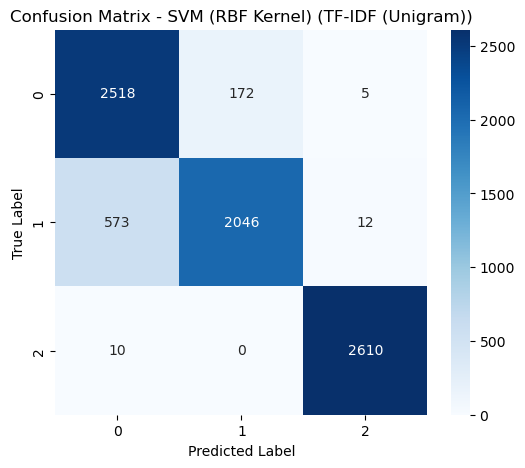


 Applying TF-IDF (Bigram) with SVM (RBF Kernel)
 Training Accuracy: 0.9696
 Validation Accuracy: 0.8570
 **Warning: SVM (RBF Kernel) is Overfitting!**

 Classification Report:

              precision    recall  f1-score   support

           0       0.79      0.97      0.87      2695
           1       0.98      0.61      0.75      2631
           2       0.86      1.00      0.92      2620

    accuracy                           0.86      7946
   macro avg       0.88      0.86      0.85      7946
weighted avg       0.88      0.86      0.85      7946



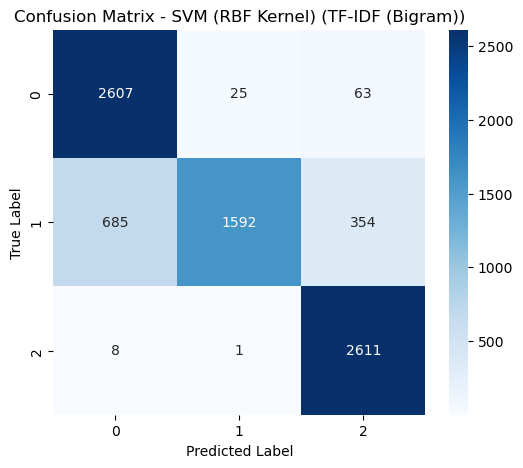


 Applying TF-IDF (Trigram) with SVM (RBF Kernel)
 Training Accuracy: 0.9356
 Validation Accuracy: 0.8243
 **Warning: SVM (RBF Kernel) is Overfitting!**

 Classification Report:

              precision    recall  f1-score   support

           0       0.80      0.91      0.85      2695
           1       1.00      0.56      0.72      2631
           2       0.77      1.00      0.87      2620

    accuracy                           0.82      7946
   macro avg       0.86      0.82      0.81      7946
weighted avg       0.86      0.82      0.81      7946



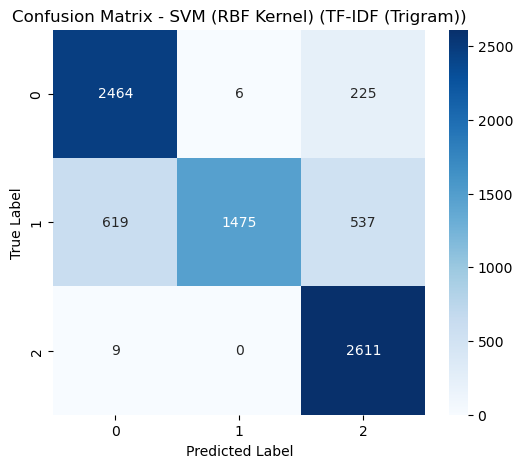


 Applying TF-IDF (N-gram 1-3) with SVM (RBF Kernel)
 Training Accuracy: 0.9962
 Validation Accuracy: 0.8889
 **Warning: SVM (RBF Kernel) is Overfitting!**

 Classification Report:

              precision    recall  f1-score   support

           0       0.76      0.99      0.86      2695
           1       0.98      0.69      0.81      2631
           2       0.99      0.99      0.99      2620

    accuracy                           0.89      7946
   macro avg       0.91      0.89      0.89      7946
weighted avg       0.91      0.89      0.89      7946



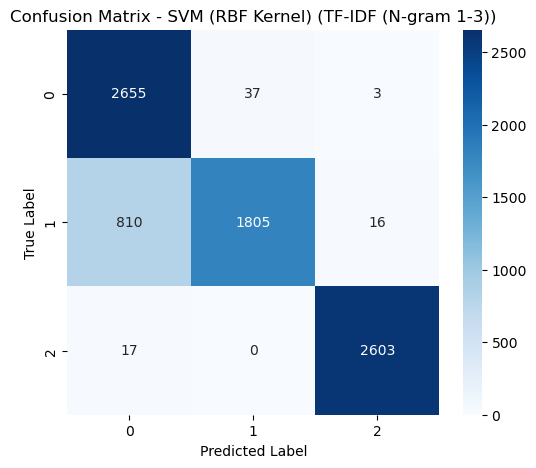


 Applying TF-IDF (Feature Limited) with SVM (RBF Kernel)
 Training Accuracy: 0.9785
 Validation Accuracy: 0.8738
 **Warning: SVM (RBF Kernel) is Overfitting!**

 Classification Report:

              precision    recall  f1-score   support

           0       0.83      0.90      0.86      2695
           1       0.90      0.73      0.81      2631
           2       0.90      0.99      0.95      2620

    accuracy                           0.87      7946
   macro avg       0.88      0.87      0.87      7946
weighted avg       0.88      0.87      0.87      7946



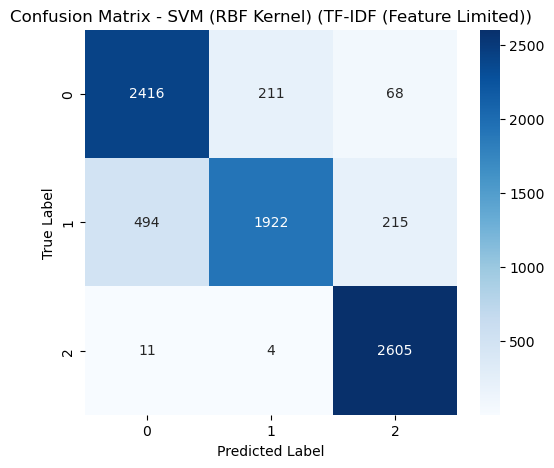


 Applying TF-IDF (Stopword Removed) with SVM (RBF Kernel)
 Training Accuracy: 0.9927
 Validation Accuracy: 0.9183
 SVM (RBF Kernel) is performing well.

 Classification Report:

              precision    recall  f1-score   support

           0       0.83      0.96      0.89      2695
           1       0.95      0.80      0.87      2631
           2       0.99      1.00      0.99      2620

    accuracy                           0.92      7946
   macro avg       0.93      0.92      0.92      7946
weighted avg       0.92      0.92      0.92      7946



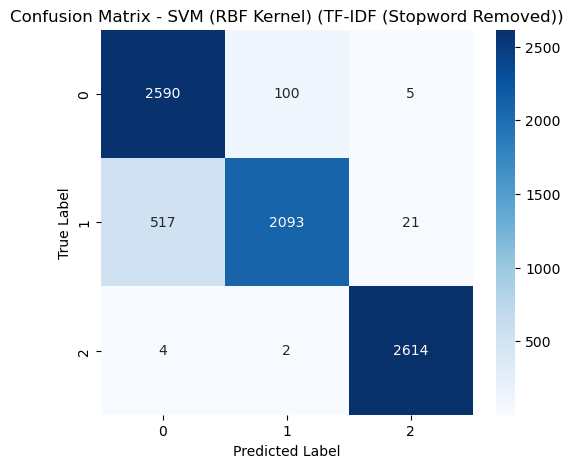


 Applying TF-IDF (Custom Stopwords) with SVM (RBF Kernel)
 Training Accuracy: 0.9958
 Validation Accuracy: 0.8987
 SVM (RBF Kernel) is performing well.

 Classification Report:

              precision    recall  f1-score   support

           0       0.79      0.97      0.87      2695
           1       0.96      0.73      0.83      2631
           2       0.99      1.00      1.00      2620

    accuracy                           0.90      7946
   macro avg       0.91      0.90      0.90      7946
weighted avg       0.91      0.90      0.90      7946



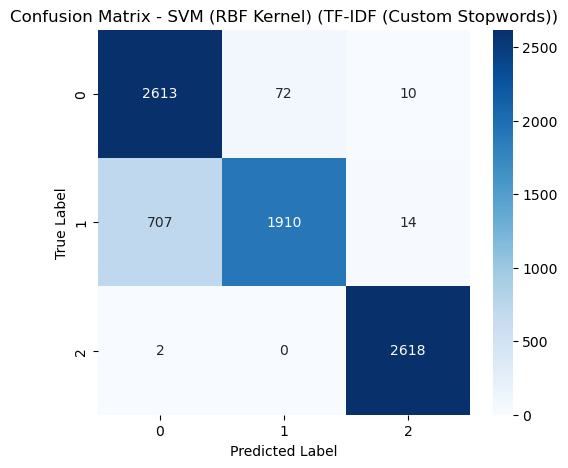


 Applying TF-IDF (Max Features=10000) with SVM (RBF Kernel)
 Training Accuracy: 0.9808
 Validation Accuracy: 0.8871
 SVM (RBF Kernel) is performing well.

 Classification Report:

              precision    recall  f1-score   support

           0       0.83      0.92      0.87      2695
           1       0.87      0.79      0.83      2631
           2       0.97      0.95      0.96      2620

    accuracy                           0.89      7946
   macro avg       0.89      0.89      0.89      7946
weighted avg       0.89      0.89      0.89      7946



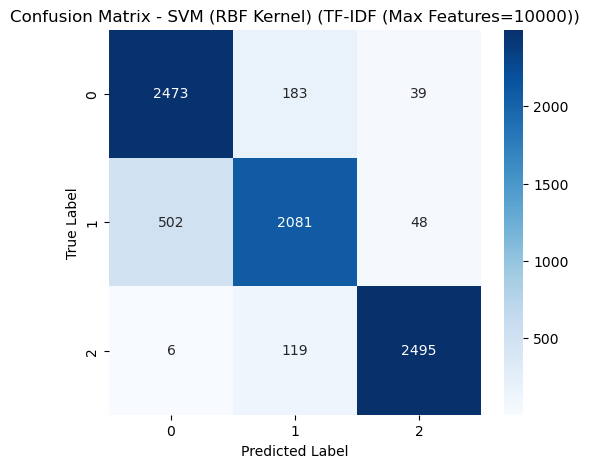


 Applying TF-IDF (Sublinear TF Scaling) with SVM (RBF Kernel)
 Training Accuracy: 0.9968
 Validation Accuracy: 0.9013
 SVM (RBF Kernel) is performing well.

 Classification Report:

              precision    recall  f1-score   support

           0       0.79      0.98      0.87      2695
           1       0.97      0.73      0.83      2631
           2       0.99      0.99      0.99      2620

    accuracy                           0.90      7946
   macro avg       0.92      0.90      0.90      7946
weighted avg       0.92      0.90      0.90      7946



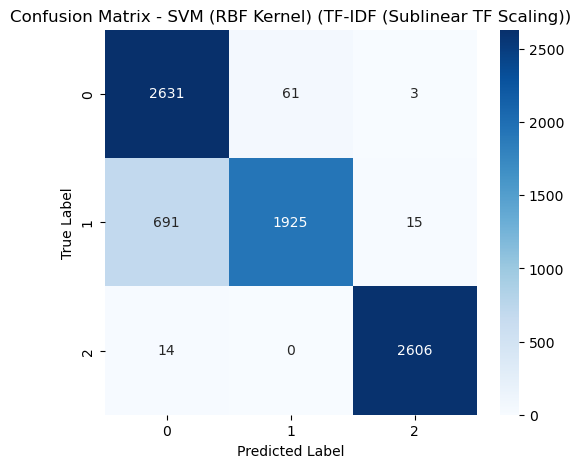


 Applying TF-IDF (Binary Term Presence) with SVM (RBF Kernel)
 Training Accuracy: 0.9969
 Validation Accuracy: 0.8988
 SVM (RBF Kernel) is performing well.

 Classification Report:

              precision    recall  f1-score   support

           0       0.79      0.97      0.87      2695
           1       0.97      0.73      0.83      2631
           2       0.99      0.99      0.99      2620

    accuracy                           0.90      7946
   macro avg       0.91      0.90      0.90      7946
weighted avg       0.91      0.90      0.90      7946



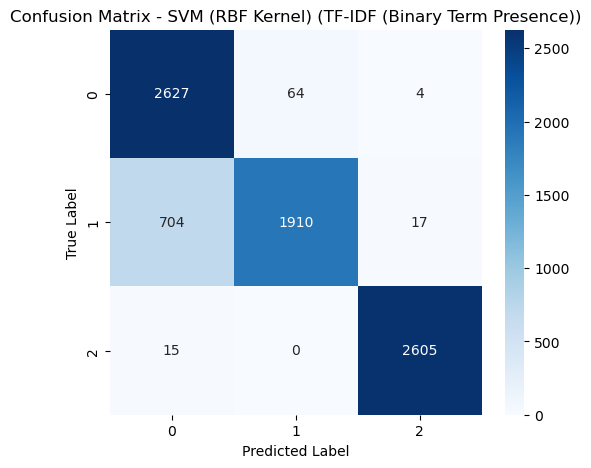


 Applying TF-IDF (L2 Normalization) with SVM (RBF Kernel)
 Training Accuracy: 0.9962
 Validation Accuracy: 0.8953
 **Warning: SVM (RBF Kernel) is Overfitting!**

 Classification Report:

              precision    recall  f1-score   support

           0       0.78      0.97      0.86      2695
           1       0.97      0.72      0.82      2631
           2       0.99      1.00      0.99      2620

    accuracy                           0.90      7946
   macro avg       0.91      0.89      0.89      7946
weighted avg       0.91      0.90      0.89      7946



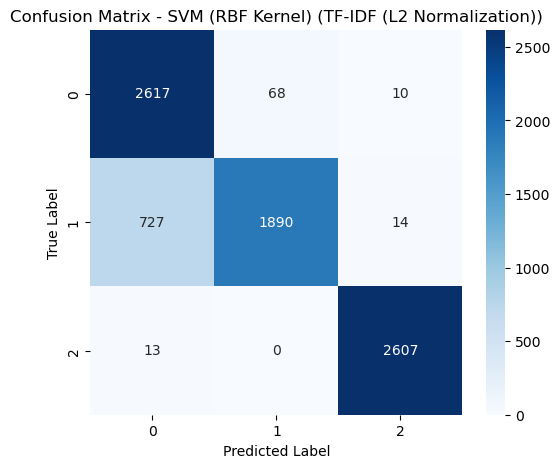


 Applying TF-IDF (L1 Normalization) with SVM (RBF Kernel)
 Training Accuracy: 0.9981
 Validation Accuracy: 0.9186
 SVM (RBF Kernel) is performing well.

 Classification Report:

              precision    recall  f1-score   support

           0       0.85      0.93      0.89      2695
           1       0.92      0.83      0.87      2631
           2       1.00      1.00      1.00      2620

    accuracy                           0.92      7946
   macro avg       0.92      0.92      0.92      7946
weighted avg       0.92      0.92      0.92      7946



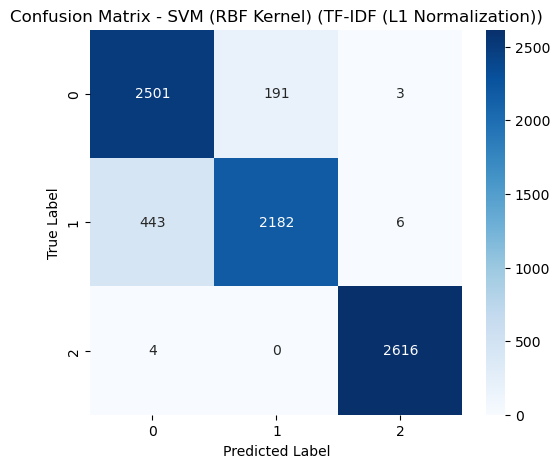


 Applying TF-IDF (No IDF Weighting) with SVM (RBF Kernel)
 Training Accuracy: 0.9960
 Validation Accuracy: 0.8989
 SVM (RBF Kernel) is performing well.

 Classification Report:

              precision    recall  f1-score   support

           0       0.80      0.94      0.87      2695
           1       0.93      0.76      0.83      2631
           2       0.99      1.00      0.99      2620

    accuracy                           0.90      7946
   macro avg       0.91      0.90      0.90      7946
weighted avg       0.91      0.90      0.90      7946



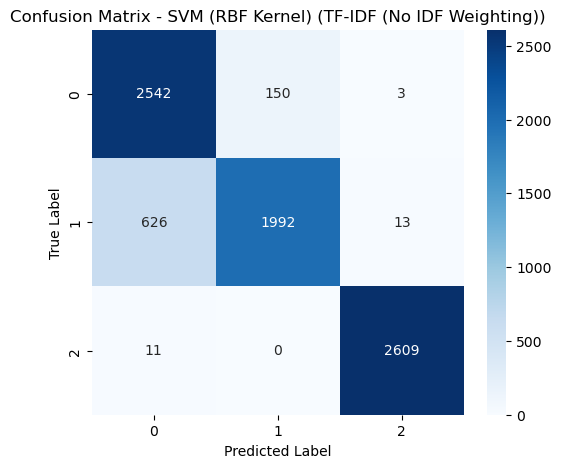


 Applying TF-IDF (Max DF=0.85) with SVM (RBF Kernel)
 Training Accuracy: 0.9962
 Validation Accuracy: 0.8953
 **Warning: SVM (RBF Kernel) is Overfitting!**

 Classification Report:

              precision    recall  f1-score   support

           0       0.78      0.97      0.86      2695
           1       0.97      0.72      0.82      2631
           2       0.99      1.00      0.99      2620

    accuracy                           0.90      7946
   macro avg       0.91      0.89      0.89      7946
weighted avg       0.91      0.90      0.89      7946



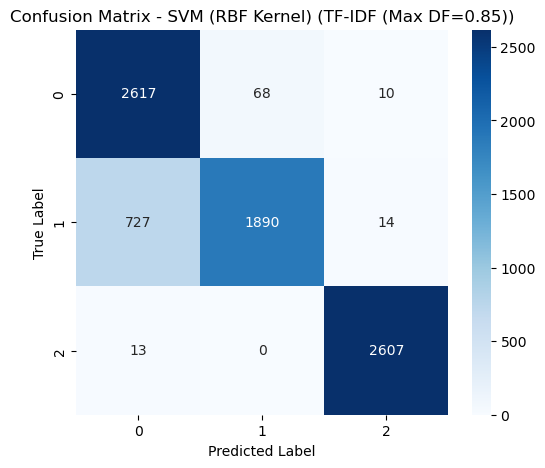


 Applying TF-IDF (Min DF=3) with SVM (RBF Kernel)
 Training Accuracy: 0.9812
 Validation Accuracy: 0.8877
 SVM (RBF Kernel) is performing well.

 Classification Report:

              precision    recall  f1-score   support

           0       0.83      0.92      0.87      2695
           1       0.87      0.79      0.83      2631
           2       0.97      0.95      0.96      2620

    accuracy                           0.89      7946
   macro avg       0.89      0.89      0.89      7946
weighted avg       0.89      0.89      0.89      7946



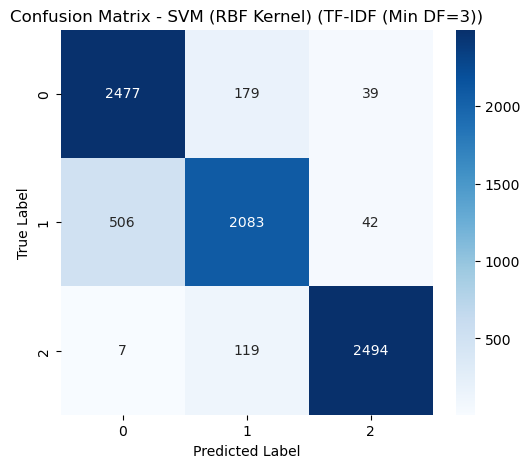


 Applying TF-IDF (Lowercase Disabled) with SVM (RBF Kernel)
 Training Accuracy: 0.9962
 Validation Accuracy: 0.8953
 **Warning: SVM (RBF Kernel) is Overfitting!**

 Classification Report:

              precision    recall  f1-score   support

           0       0.78      0.97      0.86      2695
           1       0.97      0.72      0.82      2631
           2       0.99      1.00      0.99      2620

    accuracy                           0.90      7946
   macro avg       0.91      0.89      0.89      7946
weighted avg       0.91      0.90      0.89      7946



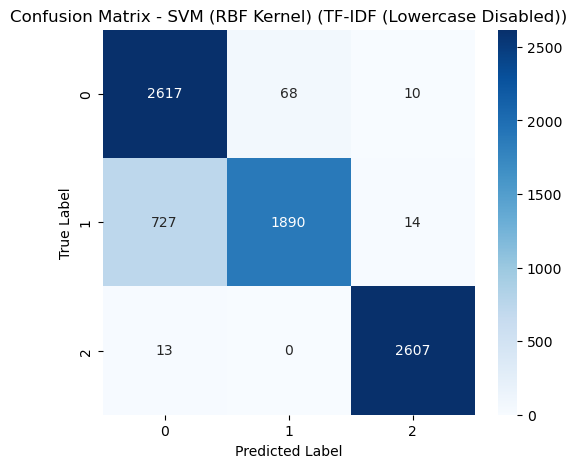

In [ ]:
# SVM (RBF Kernel)
train_and_evaluate("TF-IDF (Unigram)", "SVM (RBF Kernel)")
train_and_evaluate("TF-IDF (Bigram)", "SVM (RBF Kernel)")
train_and_evaluate("TF-IDF (Trigram)", "SVM (RBF Kernel)")
train_and_evaluate("TF-IDF (N-gram 1-3)", "SVM (RBF Kernel)")
train_and_evaluate("TF-IDF (Feature Limited)", "SVM (RBF Kernel)")
train_and_evaluate("TF-IDF (Stopword Removed)", "SVM (RBF Kernel)")
train_and_evaluate("TF-IDF (Custom Stopwords)", "SVM (RBF Kernel)")
train_and_evaluate("TF-IDF (Max Features=10000)", "SVM (RBF Kernel)")
train_and_evaluate("TF-IDF (Sublinear TF Scaling)", "SVM (RBF Kernel)")
train_and_evaluate("TF-IDF (Binary Term Presence)", "SVM (RBF Kernel)")
train_and_evaluate("TF-IDF (L2 Normalization)", "SVM (RBF Kernel)")
train_and_evaluate("TF-IDF (L1 Normalization)", "SVM (RBF Kernel)")
train_and_evaluate("TF-IDF (No IDF Weighting)", "SVM (RBF Kernel)")
train_and_evaluate("TF-IDF (Max DF=0.85)", "SVM (RBF Kernel)")
train_and_evaluate("TF-IDF (Min DF=3)", "SVM (RBF Kernel)")
train_and_evaluate("TF-IDF (Lowercase Disabled)", "SVM (RBF Kernel)")


 Applying TF-IDF (Unigram) with Decision Tree
 Training Accuracy: 0.6249
 Validation Accuracy: 0.6107
 **Warning: Decision Tree is Underfitting!**

 Classification Report:

              precision    recall  f1-score   support

           0       0.53      0.87      0.66      2695
           1       0.56      0.33      0.42      2631
           2       0.83      0.62      0.71      2620

    accuracy                           0.61      7946
   macro avg       0.64      0.61      0.60      7946
weighted avg       0.64      0.61      0.60      7946



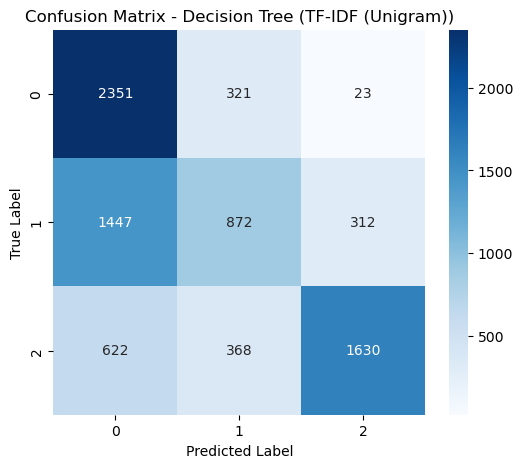


 Applying TF-IDF (Bigram) with Decision Tree
 Training Accuracy: 0.3977
 Validation Accuracy: 0.3998
 **Warning: Decision Tree is Underfitting!**

 Classification Report:

              precision    recall  f1-score   support

           0       0.37      0.99      0.53      2695
           1       0.70      0.04      0.07      2631
           2       0.78      0.16      0.26      2620

    accuracy                           0.40      7946
   macro avg       0.62      0.39      0.29      7946
weighted avg       0.61      0.40      0.29      7946



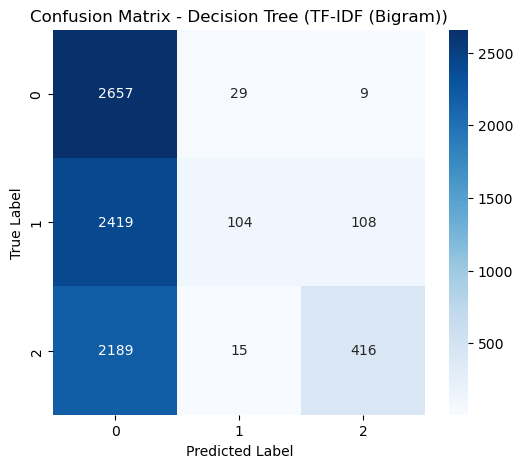


 Applying TF-IDF (Trigram) with Decision Tree
 Training Accuracy: 0.3471
 Validation Accuracy: 0.3384
 **Warning: Decision Tree is Underfitting!**

 Classification Report:

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2695
           1       0.33      1.00      0.50      2631
           2       0.97      0.02      0.04      2620

    accuracy                           0.34      7946
   macro avg       0.43      0.34      0.18      7946
weighted avg       0.43      0.34      0.18      7946



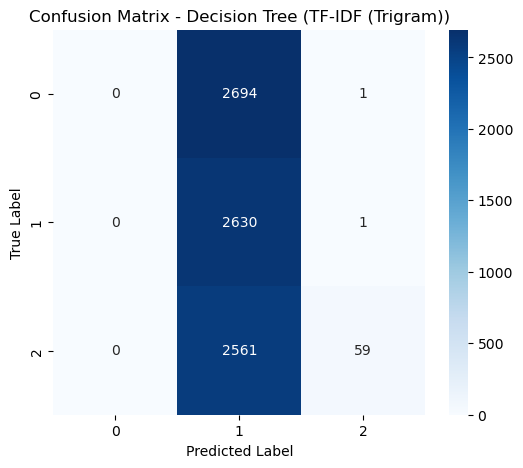


 Applying TF-IDF (N-gram 1-3) with Decision Tree
 Training Accuracy: 0.6182
 Validation Accuracy: 0.6014
 **Warning: Decision Tree is Underfitting!**

 Classification Report:

              precision    recall  f1-score   support

           0       0.52      0.87      0.65      2695
           1       0.55      0.33      0.41      2631
           2       0.82      0.61      0.70      2620

    accuracy                           0.60      7946
   macro avg       0.63      0.60      0.59      7946
weighted avg       0.63      0.60      0.59      7946



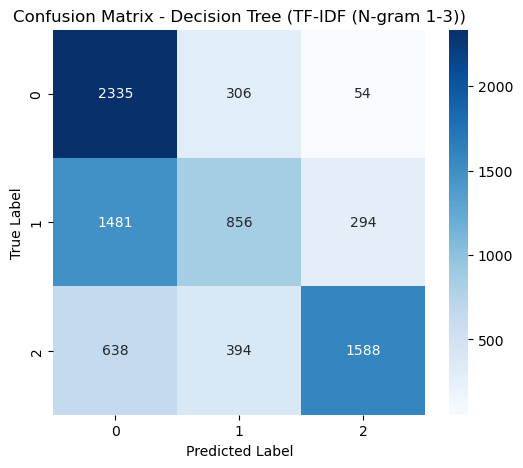


 Applying TF-IDF (Feature Limited) with Decision Tree
 Training Accuracy: 0.5815
 Validation Accuracy: 0.5690
 **Warning: Decision Tree is Underfitting!**

 Classification Report:

              precision    recall  f1-score   support

           0       0.50      0.92      0.65      2695
           1       0.56      0.31      0.40      2631
           2       0.78      0.47      0.59      2620

    accuracy                           0.57      7946
   macro avg       0.62      0.57      0.54      7946
weighted avg       0.62      0.57      0.55      7946



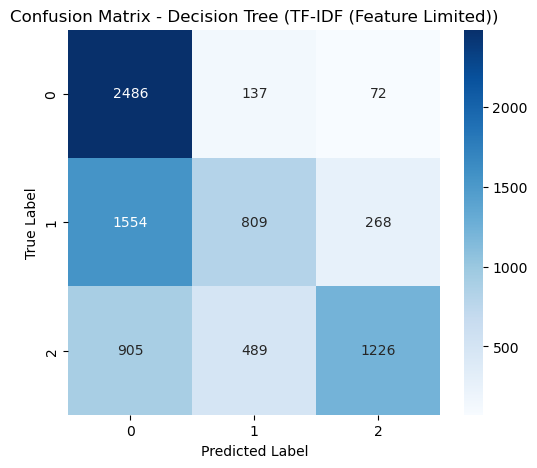


 Applying TF-IDF (Stopword Removed) with Decision Tree
 Training Accuracy: 0.5846
 Validation Accuracy: 0.5824
 **Warning: Decision Tree is Underfitting!**

 Classification Report:

              precision    recall  f1-score   support

           0       0.49      0.93      0.64      2695
           1       0.52      0.20      0.29      2631
           2       0.90      0.61      0.72      2620

    accuracy                           0.58      7946
   macro avg       0.64      0.58      0.55      7946
weighted avg       0.63      0.58      0.55      7946



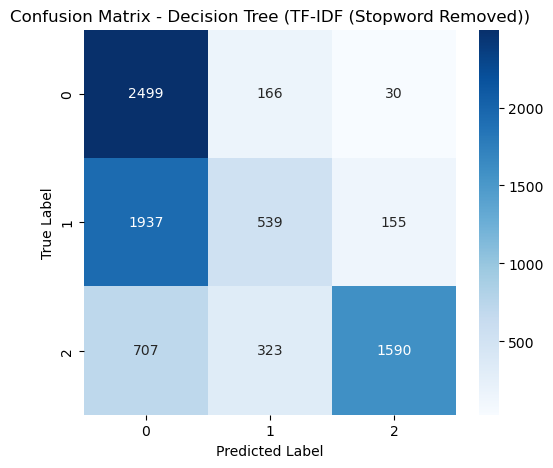


 Applying TF-IDF (Custom Stopwords) with Decision Tree
 Training Accuracy: 0.6047
 Validation Accuracy: 0.5919
 **Warning: Decision Tree is Underfitting!**

 Classification Report:

              precision    recall  f1-score   support

           0       0.50      0.94      0.65      2695
           1       0.58      0.20      0.30      2631
           2       0.82      0.63      0.71      2620

    accuracy                           0.59      7946
   macro avg       0.64      0.59      0.56      7946
weighted avg       0.63      0.59      0.56      7946



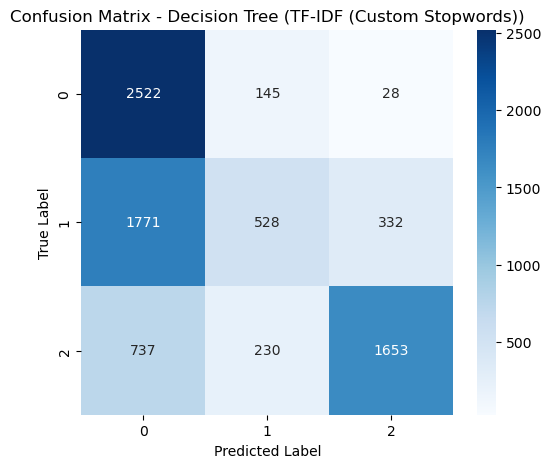


 Applying TF-IDF (Max Features=10000) with Decision Tree
 Training Accuracy: 0.6004
 Validation Accuracy: 0.5861
 **Warning: Decision Tree is Underfitting!**

 Classification Report:

              precision    recall  f1-score   support

           0       0.53      0.76      0.62      2695
           1       0.51      0.45      0.48      2631
           2       0.83      0.55      0.66      2620

    accuracy                           0.59      7946
   macro avg       0.62      0.58      0.59      7946
weighted avg       0.62      0.59      0.59      7946



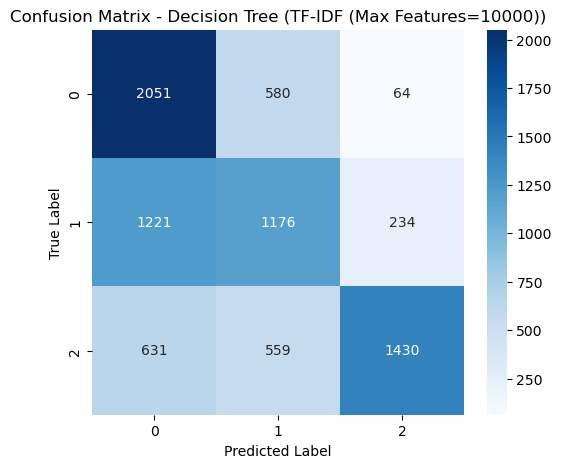


 Applying TF-IDF (Sublinear TF Scaling) with Decision Tree
 Training Accuracy: 0.6240
 Validation Accuracy: 0.6135
 **Warning: Decision Tree is Underfitting!**

 Classification Report:

              precision    recall  f1-score   support

           0       0.53      0.87      0.66      2695
           1       0.58      0.30      0.40      2631
           2       0.81      0.66      0.72      2620

    accuracy                           0.61      7946
   macro avg       0.64      0.61      0.59      7946
weighted avg       0.64      0.61      0.59      7946



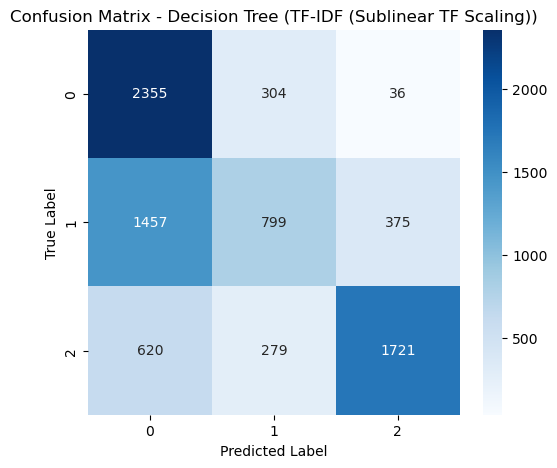


 Applying TF-IDF (Binary Term Presence) with Decision Tree
 Training Accuracy: 0.6340
 Validation Accuracy: 0.6168
 **Warning: Decision Tree is Underfitting!**

 Classification Report:

              precision    recall  f1-score   support

           0       0.54      0.88      0.67      2695
           1       0.58      0.34      0.43      2631
           2       0.82      0.63      0.71      2620

    accuracy                           0.62      7946
   macro avg       0.64      0.61      0.60      7946
weighted avg       0.64      0.62      0.60      7946



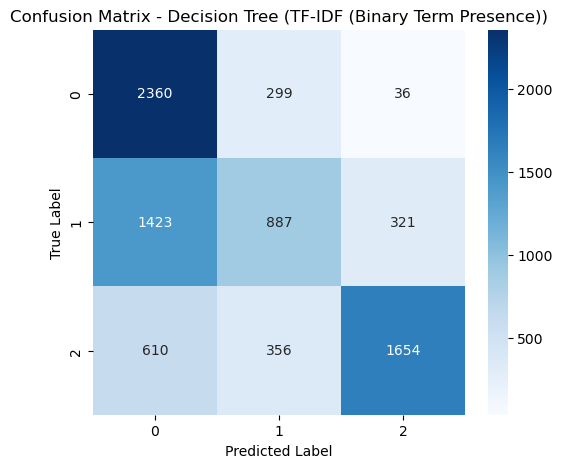


 Applying TF-IDF (L2 Normalization) with Decision Tree
 Training Accuracy: 0.6077
 Validation Accuracy: 0.5955
 **Warning: Decision Tree is Underfitting!**

 Classification Report:

              precision    recall  f1-score   support

           0       0.50      0.94      0.65      2695
           1       0.59      0.20      0.30      2631
           2       0.83      0.64      0.72      2620

    accuracy                           0.60      7946
   macro avg       0.64      0.59      0.56      7946
weighted avg       0.64      0.60      0.56      7946



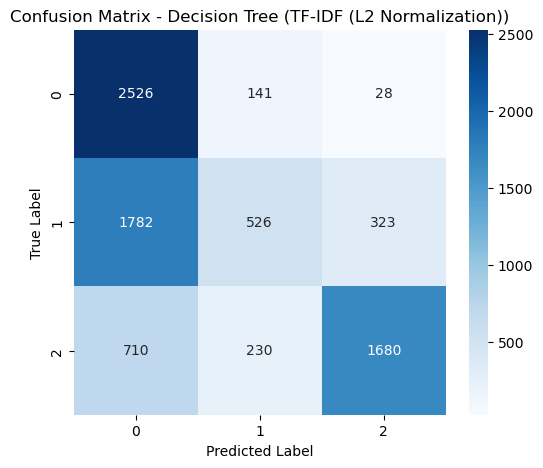


 Applying TF-IDF (L1 Normalization) with Decision Tree
 Training Accuracy: 0.7943
 Validation Accuracy: 0.7874
 Decision Tree is performing well.

 Classification Report:

              precision    recall  f1-score   support

           0       0.64      0.94      0.76      2695
           1       0.86      0.52      0.64      2631
           2       0.98      0.90      0.94      2620

    accuracy                           0.79      7946
   macro avg       0.83      0.79      0.78      7946
weighted avg       0.82      0.79      0.78      7946



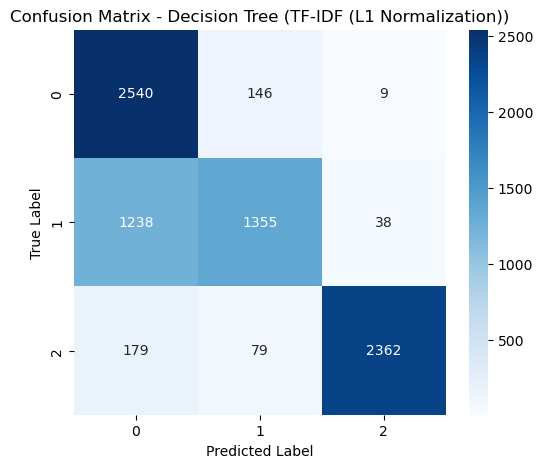


 Applying TF-IDF (No IDF Weighting) with Decision Tree
 Training Accuracy: 0.6369
 Validation Accuracy: 0.6314
 **Warning: Decision Tree is Underfitting!**

 Classification Report:

              precision    recall  f1-score   support

           0       0.51      0.94      0.66      2695
           1       0.72      0.29      0.41      2631
           2       0.91      0.66      0.76      2620

    accuracy                           0.63      7946
   macro avg       0.71      0.63      0.61      7946
weighted avg       0.71      0.63      0.61      7946



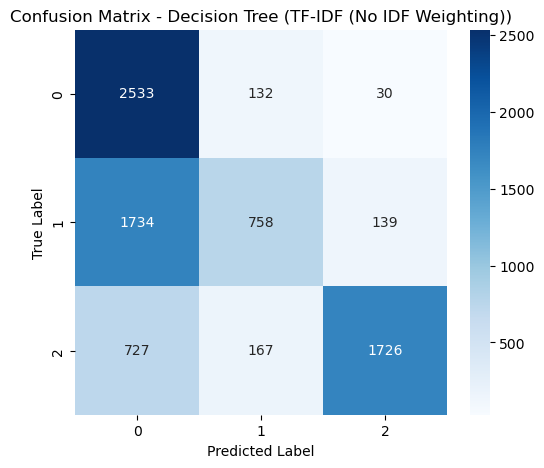


 Applying TF-IDF (Max DF=0.85) with Decision Tree
 Training Accuracy: 0.6077
 Validation Accuracy: 0.5955
 **Warning: Decision Tree is Underfitting!**

 Classification Report:

              precision    recall  f1-score   support

           0       0.50      0.94      0.65      2695
           1       0.59      0.20      0.30      2631
           2       0.83      0.64      0.72      2620

    accuracy                           0.60      7946
   macro avg       0.64      0.59      0.56      7946
weighted avg       0.64      0.60      0.56      7946



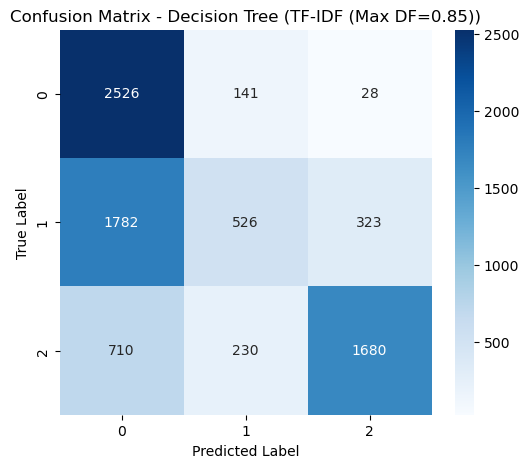


 Applying TF-IDF (Min DF=3) with Decision Tree
 Training Accuracy: 0.6041
 Validation Accuracy: 0.5848
 **Warning: Decision Tree is Underfitting!**

 Classification Report:

              precision    recall  f1-score   support

           0       0.52      0.76      0.62      2695
           1       0.50      0.48      0.49      2631
           2       0.88      0.51      0.65      2620

    accuracy                           0.58      7946
   macro avg       0.64      0.58      0.59      7946
weighted avg       0.63      0.58      0.59      7946



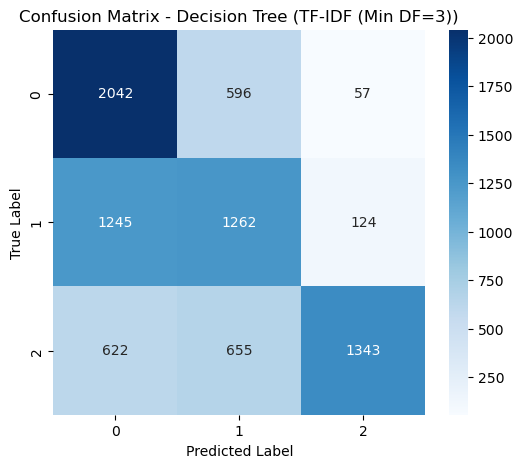


 Applying TF-IDF (Lowercase Disabled) with Decision Tree
 Training Accuracy: 0.6077
 Validation Accuracy: 0.5955
 **Warning: Decision Tree is Underfitting!**

 Classification Report:

              precision    recall  f1-score   support

           0       0.50      0.94      0.65      2695
           1       0.59      0.20      0.30      2631
           2       0.83      0.64      0.72      2620

    accuracy                           0.60      7946
   macro avg       0.64      0.59      0.56      7946
weighted avg       0.64      0.60      0.56      7946



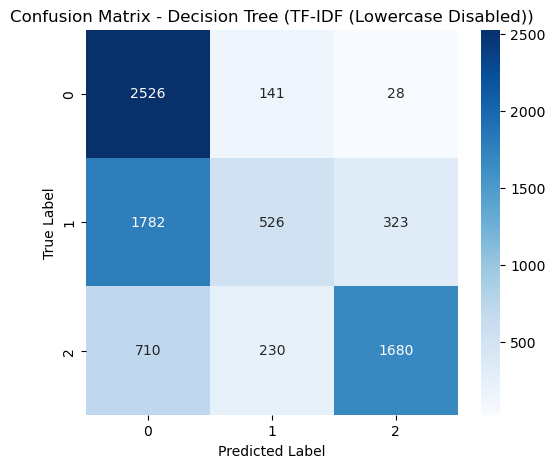

In [ ]:
# Decision Tree
train_and_evaluate("TF-IDF (Unigram)", "Decision Tree")
train_and_evaluate("TF-IDF (Bigram)", "Decision Tree")
train_and_evaluate("TF-IDF (Trigram)", "Decision Tree")
train_and_evaluate("TF-IDF (N-gram 1-3)", "Decision Tree")
train_and_evaluate("TF-IDF (Feature Limited)", "Decision Tree")
train_and_evaluate("TF-IDF (Stopword Removed)", "Decision Tree")
train_and_evaluate("TF-IDF (Custom Stopwords)", "Decision Tree")
train_and_evaluate("TF-IDF (Max Features=10000)", "Decision Tree")
train_and_evaluate("TF-IDF (Sublinear TF Scaling)", "Decision Tree")
train_and_evaluate("TF-IDF (Binary Term Presence)", "Decision Tree")
train_and_evaluate("TF-IDF (L2 Normalization)", "Decision Tree")
train_and_evaluate("TF-IDF (L1 Normalization)", "Decision Tree")
train_and_evaluate("TF-IDF (No IDF Weighting)", "Decision Tree")
train_and_evaluate("TF-IDF (Max DF=0.85)", "Decision Tree")
train_and_evaluate("TF-IDF (Min DF=3)", "Decision Tree")
train_and_evaluate("TF-IDF (Lowercase Disabled)", "Decision Tree")


 Applying TF-IDF (Unigram) with Naïve Bayes
 Training Accuracy: 0.8760
 Validation Accuracy: 0.7843
 Naïve Bayes is performing well.

 Classification Report:

              precision    recall  f1-score   support

           0       0.85      0.59      0.70      2695
           1       0.73      0.78      0.75      2631
           2       0.80      0.98      0.88      2620

    accuracy                           0.78      7946
   macro avg       0.79      0.79      0.78      7946
weighted avg       0.79      0.78      0.78      7946



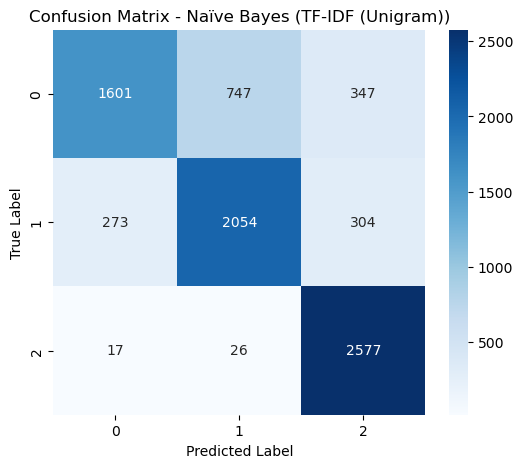


 Applying TF-IDF (Bigram) with Naïve Bayes
 Training Accuracy: 0.9742
 Validation Accuracy: 0.7564
 **Warning: Naïve Bayes is Overfitting!**

 Classification Report:

              precision    recall  f1-score   support

           0       0.82      0.49      0.62      2695
           1       0.77      0.79      0.78      2631
           2       0.71      0.99      0.83      2620

    accuracy                           0.76      7946
   macro avg       0.77      0.76      0.74      7946
weighted avg       0.77      0.76      0.74      7946



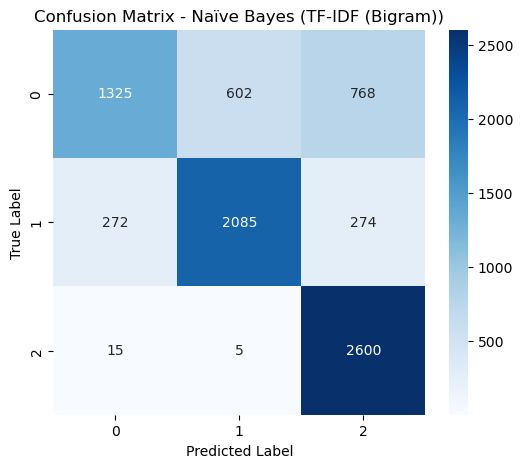


 Applying TF-IDF (Trigram) with Naïve Bayes
 Training Accuracy: 0.9529
 Validation Accuracy: 0.5917
 **Warning: Naïve Bayes is Overfitting!**

 Classification Report:

              precision    recall  f1-score   support

           0       0.83      0.09      0.16      2695
           1       0.92      0.70      0.80      2631
           2       0.46      1.00      0.63      2620

    accuracy                           0.59      7946
   macro avg       0.74      0.60      0.53      7946
weighted avg       0.74      0.59      0.53      7946



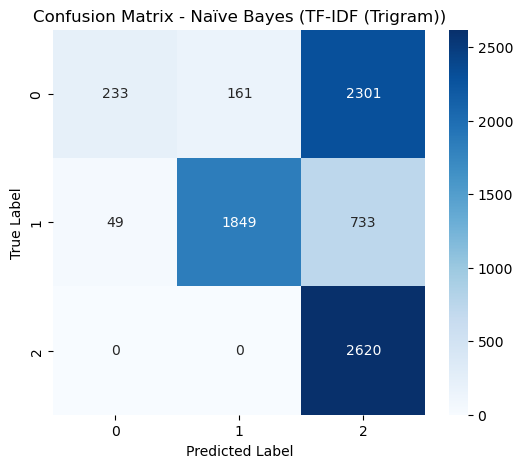


 Applying TF-IDF (N-gram 1-3) with Naïve Bayes
 Training Accuracy: 0.9756
 Validation Accuracy: 0.8334
 **Warning: Naïve Bayes is Overfitting!**

 Classification Report:

              precision    recall  f1-score   support

           0       0.92      0.61      0.74      2695
           1       0.76      0.89      0.82      2631
           2       0.86      1.00      0.93      2620

    accuracy                           0.83      7946
   macro avg       0.85      0.84      0.83      7946
weighted avg       0.85      0.83      0.83      7946



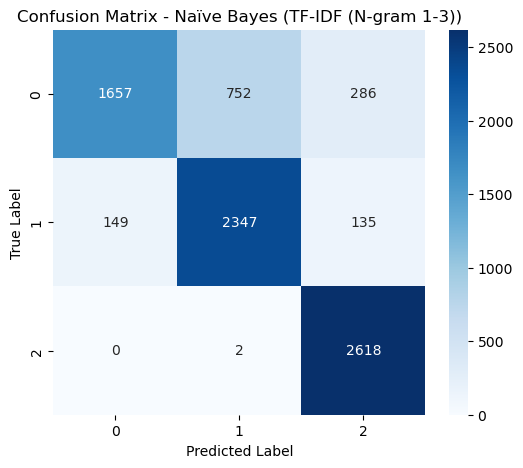


 Applying TF-IDF (Feature Limited) with Naïve Bayes
 Training Accuracy: 0.8073
 Validation Accuracy: 0.7426
 Naïve Bayes is performing well.

 Classification Report:

              precision    recall  f1-score   support

           0       0.73      0.64      0.69      2695
           1       0.72      0.65      0.68      2631
           2       0.77      0.94      0.85      2620

    accuracy                           0.74      7946
   macro avg       0.74      0.74      0.74      7946
weighted avg       0.74      0.74      0.74      7946



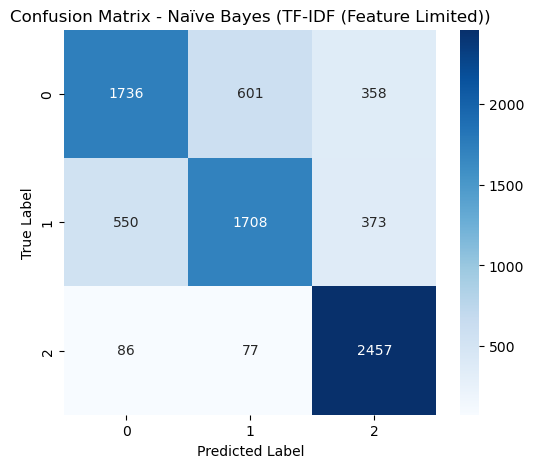


 Applying TF-IDF (Stopword Removed) with Naïve Bayes
 Training Accuracy: 0.9588
 Validation Accuracy: 0.8233
 **Warning: Naïve Bayes is Overfitting!**

 Classification Report:

              precision    recall  f1-score   support

           0       0.88      0.65      0.75      2695
           1       0.79      0.82      0.80      2631
           2       0.82      1.00      0.90      2620

    accuracy                           0.82      7946
   macro avg       0.83      0.82      0.82      7946
weighted avg       0.83      0.82      0.82      7946



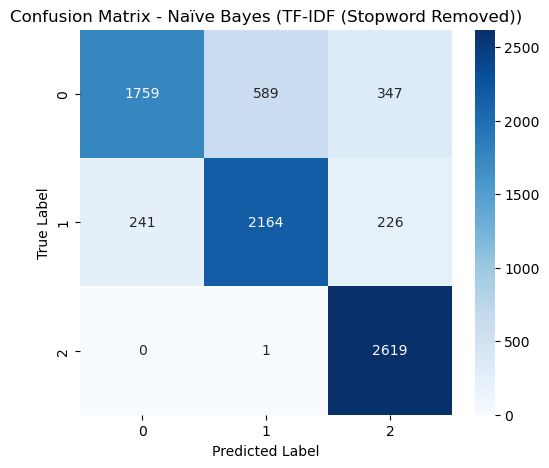


 Applying TF-IDF (Custom Stopwords) with Naïve Bayes
 Training Accuracy: 0.9599
 Validation Accuracy: 0.8241
 **Warning: Naïve Bayes is Overfitting!**

 Classification Report:

              precision    recall  f1-score   support

           0       0.90      0.61      0.73      2695
           1       0.75      0.87      0.80      2631
           2       0.86      1.00      0.92      2620

    accuracy                           0.82      7946
   macro avg       0.83      0.83      0.82      7946
weighted avg       0.84      0.82      0.82      7946



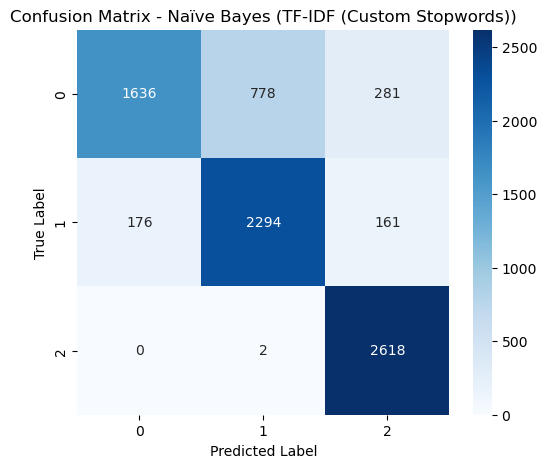


 Applying TF-IDF (Max Features=10000) with Naïve Bayes
 Training Accuracy: 0.8556
 Validation Accuracy: 0.7683
 Naïve Bayes is performing well.

 Classification Report:

              precision    recall  f1-score   support

           0       0.76      0.66      0.71      2695
           1       0.74      0.67      0.70      2631
           2       0.79      0.98      0.88      2620

    accuracy                           0.77      7946
   macro avg       0.77      0.77      0.76      7946
weighted avg       0.77      0.77      0.76      7946



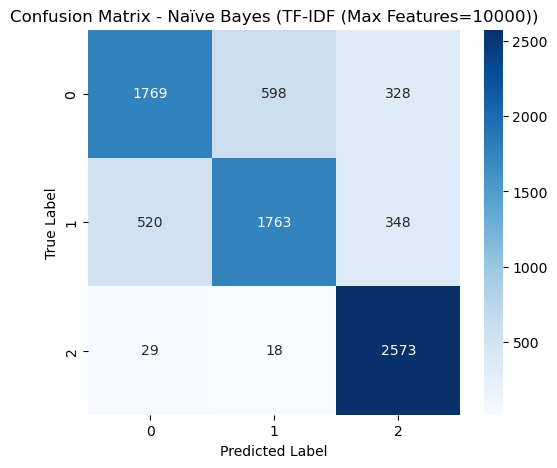


 Applying TF-IDF (Sublinear TF Scaling) with Naïve Bayes
 Training Accuracy: 0.9625
 Validation Accuracy: 0.8263
 **Warning: Naïve Bayes is Overfitting!**

 Classification Report:

              precision    recall  f1-score   support

           0       0.91      0.61      0.73      2695
           1       0.75      0.87      0.81      2631
           2       0.85      1.00      0.92      2620

    accuracy                           0.83      7946
   macro avg       0.84      0.83      0.82      7946
weighted avg       0.84      0.83      0.82      7946



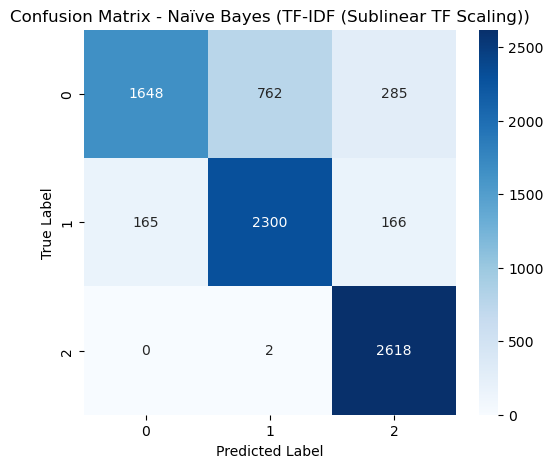


 Applying TF-IDF (Binary Term Presence) with Naïve Bayes
 Training Accuracy: 0.9648
 Validation Accuracy: 0.8319
 **Warning: Naïve Bayes is Overfitting!**

 Classification Report:

              precision    recall  f1-score   support

           0       0.91      0.62      0.74      2695
           1       0.76      0.88      0.81      2631
           2       0.86      1.00      0.92      2620

    accuracy                           0.83      7946
   macro avg       0.84      0.83      0.83      7946
weighted avg       0.84      0.83      0.82      7946



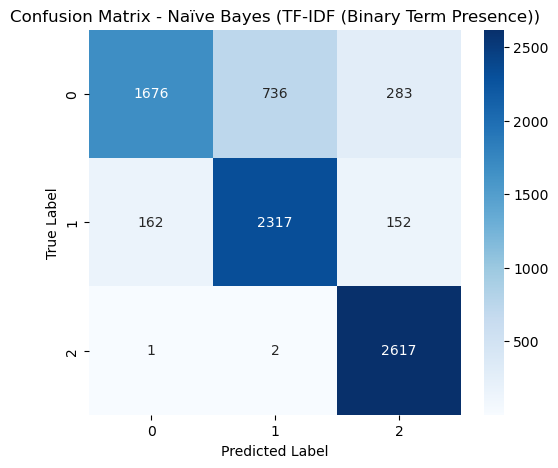


 Applying TF-IDF (L2 Normalization) with Naïve Bayes
 Training Accuracy: 0.9605
 Validation Accuracy: 0.8229
 **Warning: Naïve Bayes is Overfitting!**

 Classification Report:

              precision    recall  f1-score   support

           0       0.91      0.60      0.72      2695
           1       0.75      0.87      0.80      2631
           2       0.85      1.00      0.92      2620

    accuracy                           0.82      7946
   macro avg       0.84      0.82      0.82      7946
weighted avg       0.84      0.82      0.81      7946



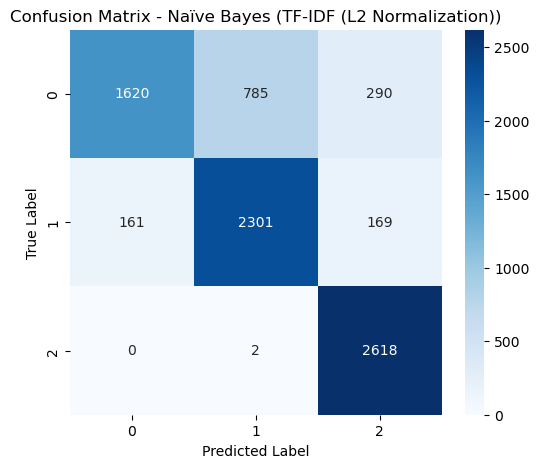


 Applying TF-IDF (L1 Normalization) with Naïve Bayes
 Training Accuracy: 0.9235
 Validation Accuracy: 0.8207
 **Warning: Naïve Bayes is Overfitting!**

 Classification Report:

              precision    recall  f1-score   support

           0       0.85      0.67      0.75      2695
           1       0.79      0.81      0.80      2631
           2       0.83      0.99      0.90      2620

    accuracy                           0.82      7946
   macro avg       0.82      0.82      0.82      7946
weighted avg       0.82      0.82      0.82      7946



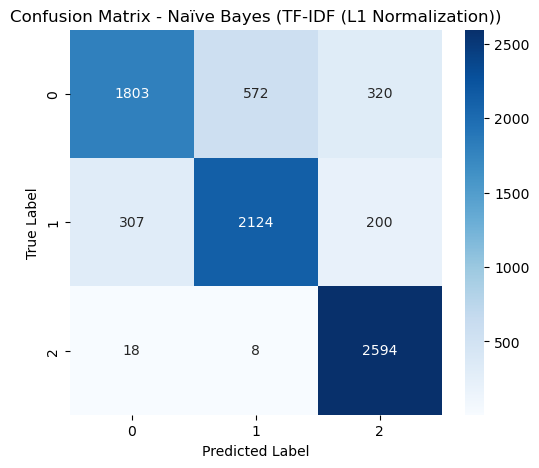


 Applying TF-IDF (No IDF Weighting) with Naïve Bayes
 Training Accuracy: 0.9338
 Validation Accuracy: 0.8090
 **Warning: Naïve Bayes is Overfitting!**

 Classification Report:

              precision    recall  f1-score   support

           0       0.88      0.59      0.70      2695
           1       0.72      0.85      0.78      2631
           2       0.85      0.99      0.92      2620

    accuracy                           0.81      7946
   macro avg       0.82      0.81      0.80      7946
weighted avg       0.82      0.81      0.80      7946



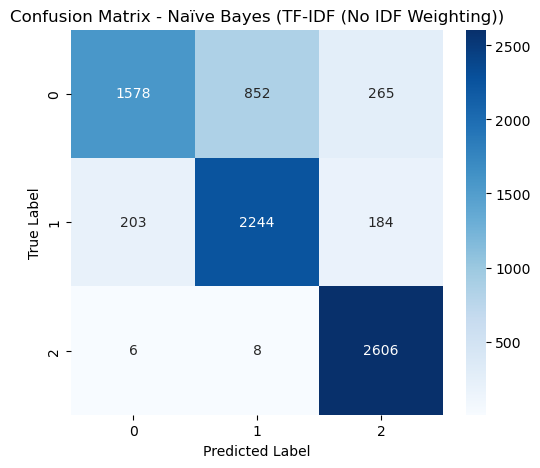


 Applying TF-IDF (Max DF=0.85) with Naïve Bayes
 Training Accuracy: 0.9605
 Validation Accuracy: 0.8229
 **Warning: Naïve Bayes is Overfitting!**

 Classification Report:

              precision    recall  f1-score   support

           0       0.91      0.60      0.72      2695
           1       0.75      0.87      0.80      2631
           2       0.85      1.00      0.92      2620

    accuracy                           0.82      7946
   macro avg       0.84      0.82      0.82      7946
weighted avg       0.84      0.82      0.81      7946



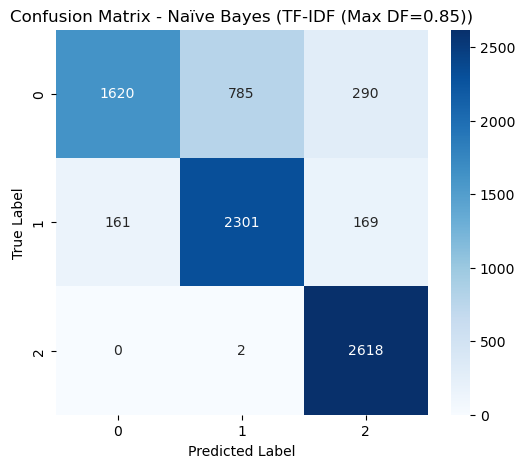


 Applying TF-IDF (Min DF=3) with Naïve Bayes
 Training Accuracy: 0.8618
 Validation Accuracy: 0.7678
 Naïve Bayes is performing well.

 Classification Report:

              precision    recall  f1-score   support

           0       0.76      0.65      0.70      2695
           1       0.74      0.67      0.70      2631
           2       0.79      0.98      0.88      2620

    accuracy                           0.77      7946
   macro avg       0.76      0.77      0.76      7946
weighted avg       0.76      0.77      0.76      7946



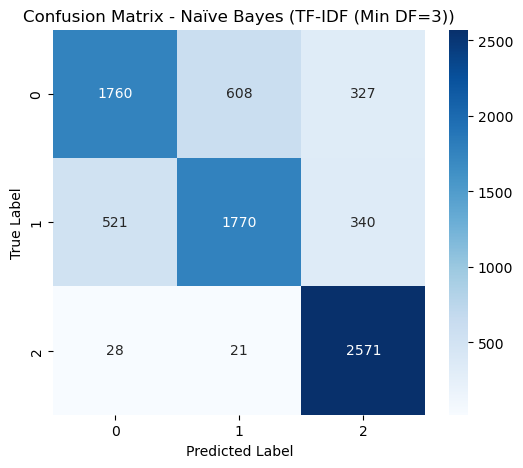


 Applying TF-IDF (Lowercase Disabled) with Naïve Bayes
 Training Accuracy: 0.9605
 Validation Accuracy: 0.8229
 **Warning: Naïve Bayes is Overfitting!**

 Classification Report:

              precision    recall  f1-score   support

           0       0.91      0.60      0.72      2695
           1       0.75      0.87      0.80      2631
           2       0.85      1.00      0.92      2620

    accuracy                           0.82      7946
   macro avg       0.84      0.82      0.82      7946
weighted avg       0.84      0.82      0.81      7946



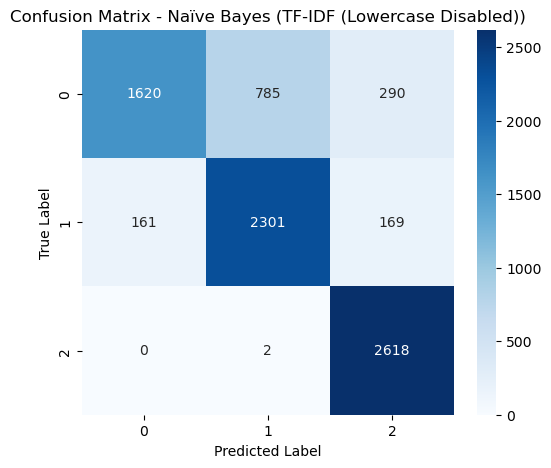

In [ ]:
# Naïve Bayes
train_and_evaluate("TF-IDF (Unigram)", "Naïve Bayes")
train_and_evaluate("TF-IDF (Bigram)", "Naïve Bayes")
train_and_evaluate("TF-IDF (Trigram)", "Naïve Bayes")
train_and_evaluate("TF-IDF (N-gram 1-3)", "Naïve Bayes")
train_and_evaluate("TF-IDF (Feature Limited)", "Naïve Bayes")
train_and_evaluate("TF-IDF (Stopword Removed)", "Naïve Bayes")
train_and_evaluate("TF-IDF (Custom Stopwords)", "Naïve Bayes")
train_and_evaluate("TF-IDF (Max Features=10000)", "Naïve Bayes")
train_and_evaluate("TF-IDF (Sublinear TF Scaling)", "Naïve Bayes")
train_and_evaluate("TF-IDF (Binary Term Presence)", "Naïve Bayes")
train_and_evaluate("TF-IDF (L2 Normalization)", "Naïve Bayes")
train_and_evaluate("TF-IDF (L1 Normalization)", "Naïve Bayes")
train_and_evaluate("TF-IDF (No IDF Weighting)", "Naïve Bayes")
train_and_evaluate("TF-IDF (Max DF=0.85)", "Naïve Bayes")
train_and_evaluate("TF-IDF (Min DF=3)", "Naïve Bayes")
train_and_evaluate("TF-IDF (Lowercase Disabled)", "Naïve Bayes")


 Applying TF-IDF (Unigram) with Random Forest
 Training Accuracy: 0.9987
 Validation Accuracy: 0.8955
 **Warning: Random Forest is Overfitting!**

 Classification Report:

              precision    recall  f1-score   support

           0       0.82      0.91      0.86      2695
           1       0.90      0.79      0.84      2631
           2       0.99      0.99      0.99      2620

    accuracy                           0.90      7946
   macro avg       0.90      0.90      0.90      7946
weighted avg       0.90      0.90      0.90      7946



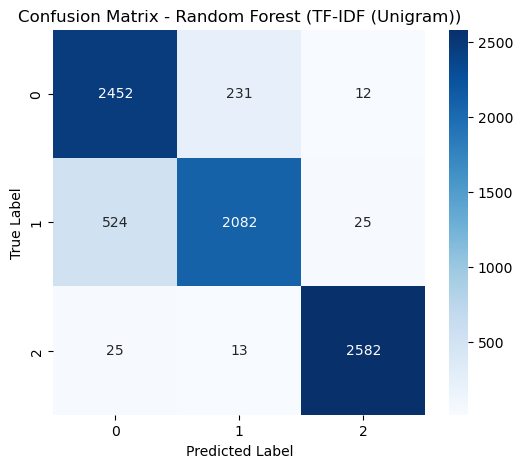


 Applying TF-IDF (Bigram) with Random Forest
 Training Accuracy: 0.9893
 Validation Accuracy: 0.7598
 **Warning: Random Forest is Overfitting!**

 Classification Report:

              precision    recall  f1-score   support

           0       0.81      0.59      0.68      2695
           1       0.85      0.71      0.77      2631
           2       0.68      0.99      0.81      2620

    accuracy                           0.76      7946
   macro avg       0.78      0.76      0.75      7946
weighted avg       0.78      0.76      0.75      7946



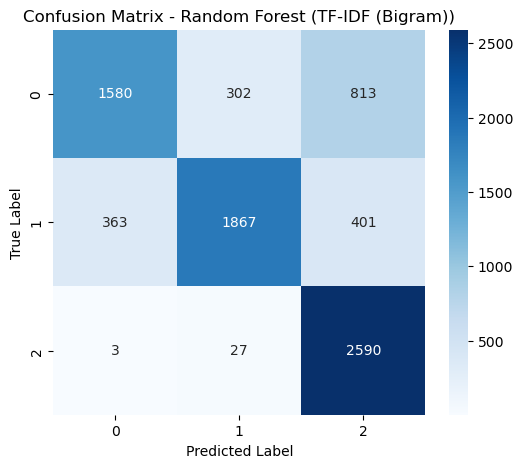


 Applying TF-IDF (Trigram) with Random Forest
 Training Accuracy: 0.9584
 Validation Accuracy: 0.5775
 **Warning: Random Forest is Overfitting!**

 Classification Report:

              precision    recall  f1-score   support

           0       0.76      0.16      0.26      2695
           1       0.95      0.59      0.73      2631
           2       0.45      1.00      0.62      2620

    accuracy                           0.58      7946
   macro avg       0.72      0.58      0.54      7946
weighted avg       0.72      0.58      0.53      7946



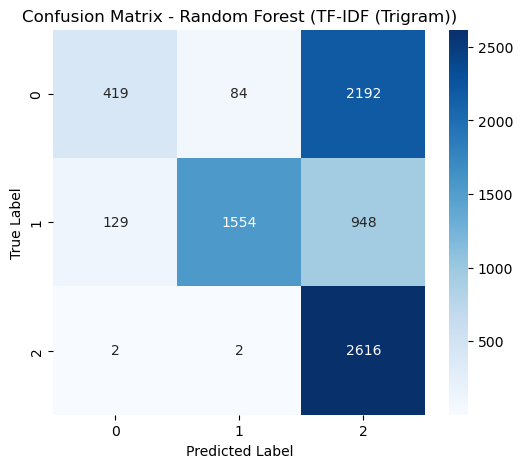


 Applying TF-IDF (N-gram 1-3) with Random Forest
 Training Accuracy: 0.9987
 Validation Accuracy: 0.8974
 **Warning: Random Forest is Overfitting!**

 Classification Report:

              precision    recall  f1-score   support

           0       0.80      0.95      0.87      2695
           1       0.94      0.75      0.84      2631
           2       0.99      0.98      0.99      2620

    accuracy                           0.90      7946
   macro avg       0.91      0.90      0.90      7946
weighted avg       0.91      0.90      0.90      7946



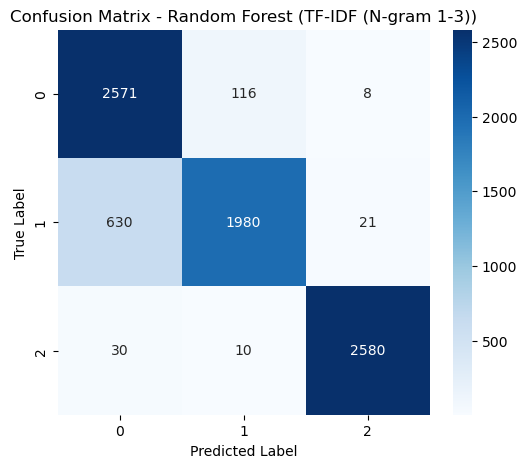


 Applying TF-IDF (Feature Limited) with Random Forest
 Training Accuracy: 0.9919
 Validation Accuracy: 0.8563
 **Warning: Random Forest is Overfitting!**

 Classification Report:

              precision    recall  f1-score   support

           0       0.80      0.86      0.83      2695
           1       0.85      0.74      0.79      2631
           2       0.93      0.97      0.95      2620

    accuracy                           0.86      7946
   macro avg       0.86      0.86      0.85      7946
weighted avg       0.86      0.86      0.85      7946



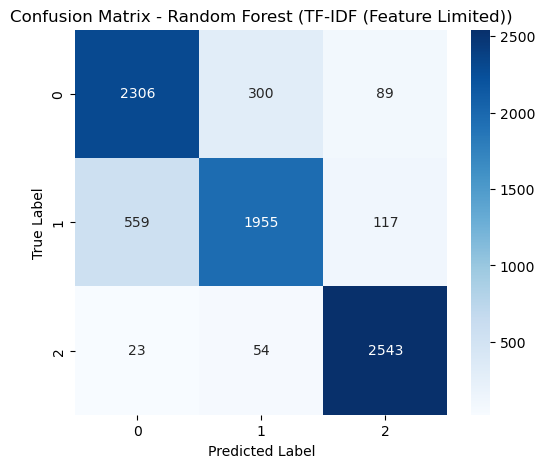


 Applying TF-IDF (Stopword Removed) with Random Forest
 Training Accuracy: 0.9970
 Validation Accuracy: 0.8920
 **Warning: Random Forest is Overfitting!**

 Classification Report:

              precision    recall  f1-score   support

           0       0.81      0.90      0.85      2695
           1       0.88      0.79      0.83      2631
           2       0.99      0.99      0.99      2620

    accuracy                           0.89      7946
   macro avg       0.90      0.89      0.89      7946
weighted avg       0.89      0.89      0.89      7946



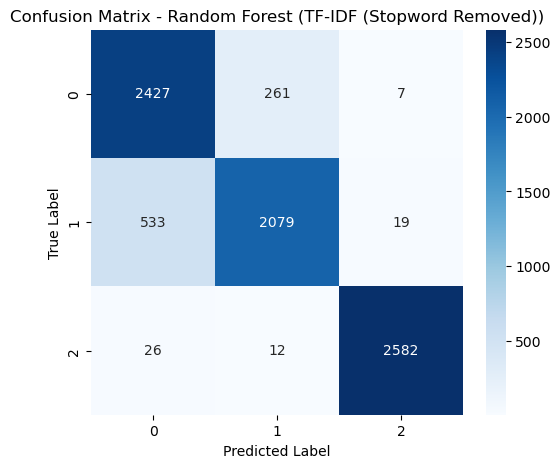


 Applying TF-IDF (Custom Stopwords) with Random Forest
 Training Accuracy: 0.9987
 Validation Accuracy: 0.8963
 **Warning: Random Forest is Overfitting!**

 Classification Report:

              precision    recall  f1-score   support

           0       0.80      0.94      0.86      2695
           1       0.93      0.76      0.84      2631
           2       0.99      0.98      0.99      2620

    accuracy                           0.90      7946
   macro avg       0.91      0.90      0.90      7946
weighted avg       0.90      0.90      0.90      7946



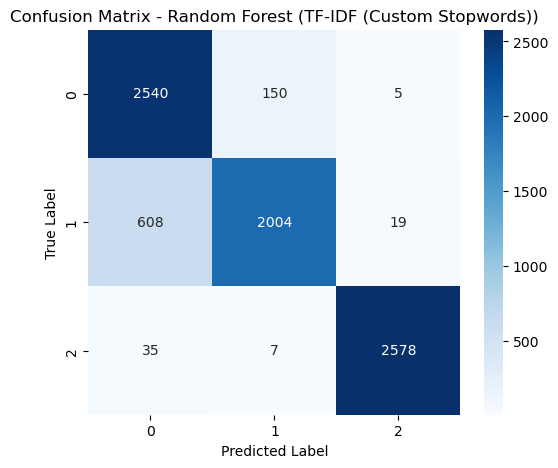


 Applying TF-IDF (Max Features=10000) with Random Forest
 Training Accuracy: 0.9942
 Validation Accuracy: 0.8696
 **Warning: Random Forest is Overfitting!**

 Classification Report:

              precision    recall  f1-score   support

           0       0.81      0.87      0.84      2695
           1       0.85      0.77      0.81      2631
           2       0.95      0.97      0.96      2620

    accuracy                           0.87      7946
   macro avg       0.87      0.87      0.87      7946
weighted avg       0.87      0.87      0.87      7946



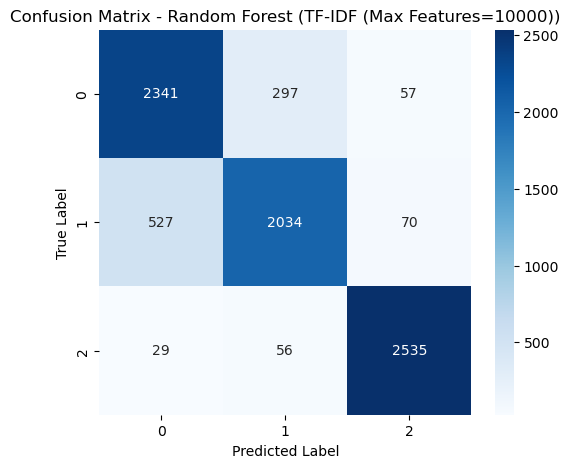


 Applying TF-IDF (Sublinear TF Scaling) with Random Forest
 Training Accuracy: 0.9987
 Validation Accuracy: 0.8972
 **Warning: Random Forest is Overfitting!**

 Classification Report:

              precision    recall  f1-score   support

           0       0.80      0.94      0.87      2695
           1       0.93      0.77      0.84      2631
           2       0.99      0.99      0.99      2620

    accuracy                           0.90      7946
   macro avg       0.91      0.90      0.90      7946
weighted avg       0.90      0.90      0.90      7946



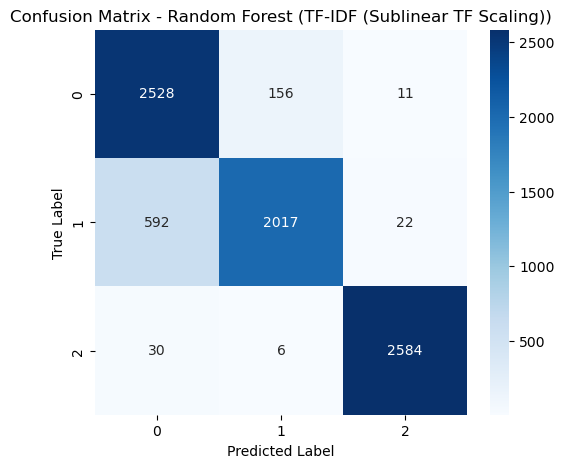


 Applying TF-IDF (Binary Term Presence) with Random Forest
 Training Accuracy: 0.9987
 Validation Accuracy: 0.8958
 **Warning: Random Forest is Overfitting!**

 Classification Report:

              precision    recall  f1-score   support

           0       0.80      0.94      0.86      2695
           1       0.93      0.76      0.83      2631
           2       0.99      0.99      0.99      2620

    accuracy                           0.90      7946
   macro avg       0.90      0.90      0.90      7946
weighted avg       0.90      0.90      0.89      7946



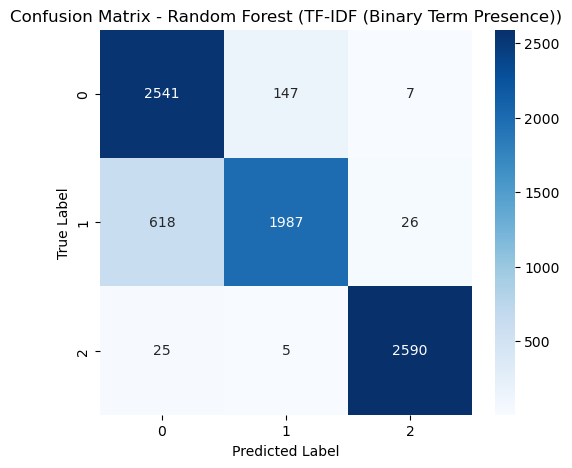


 Applying TF-IDF (L2 Normalization) with Random Forest
 Training Accuracy: 0.9987
 Validation Accuracy: 0.8973
 **Warning: Random Forest is Overfitting!**

 Classification Report:

              precision    recall  f1-score   support

           0       0.80      0.95      0.87      2695
           1       0.93      0.76      0.84      2631
           2       0.99      0.98      0.99      2620

    accuracy                           0.90      7946
   macro avg       0.91      0.90      0.90      7946
weighted avg       0.91      0.90      0.90      7946



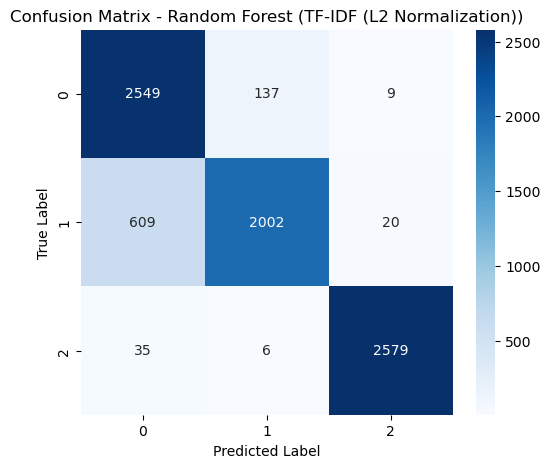


 Applying TF-IDF (L1 Normalization) with Random Forest
 Training Accuracy: 0.9987
 Validation Accuracy: 0.8748
 **Warning: Random Forest is Overfitting!**

 Classification Report:

              precision    recall  f1-score   support

           0       0.75      0.98      0.85      2695
           1       0.96      0.69      0.80      2631
           2       0.99      0.95      0.97      2620

    accuracy                           0.87      7946
   macro avg       0.90      0.87      0.87      7946
weighted avg       0.90      0.87      0.87      7946



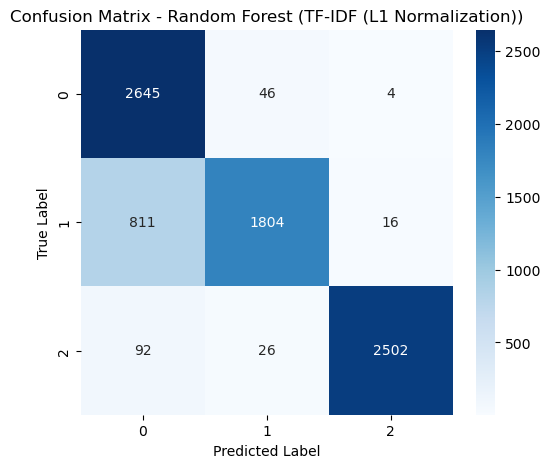


 Applying TF-IDF (No IDF Weighting) with Random Forest
 Training Accuracy: 0.9987
 Validation Accuracy: 0.8940
 **Warning: Random Forest is Overfitting!**

 Classification Report:

              precision    recall  f1-score   support

           0       0.79      0.95      0.86      2695
           1       0.94      0.75      0.83      2631
           2       0.99      0.98      0.99      2620

    accuracy                           0.89      7946
   macro avg       0.91      0.89      0.89      7946
weighted avg       0.90      0.89      0.89      7946



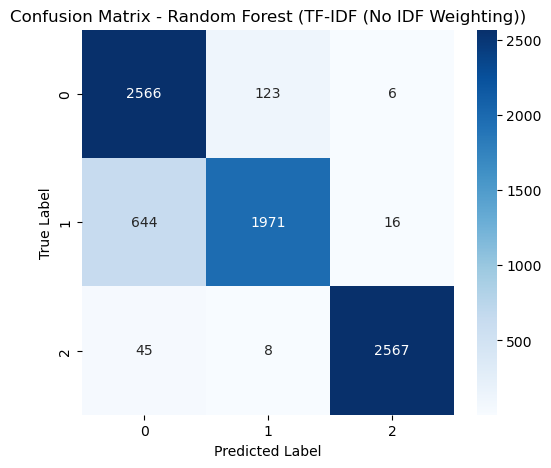


 Applying TF-IDF (Max DF=0.85) with Random Forest
 Training Accuracy: 0.9987
 Validation Accuracy: 0.8973
 **Warning: Random Forest is Overfitting!**

 Classification Report:

              precision    recall  f1-score   support

           0       0.80      0.95      0.87      2695
           1       0.93      0.76      0.84      2631
           2       0.99      0.98      0.99      2620

    accuracy                           0.90      7946
   macro avg       0.91      0.90      0.90      7946
weighted avg       0.91      0.90      0.90      7946



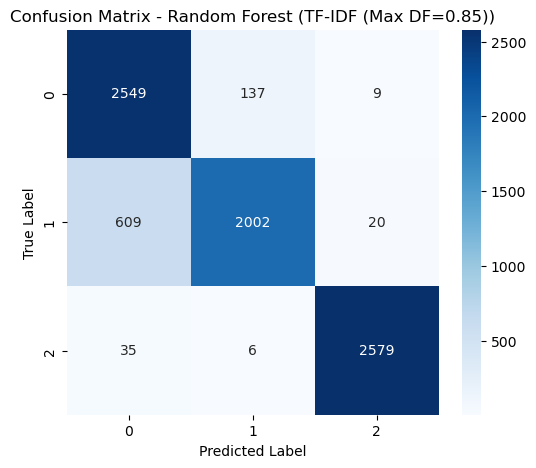


 Applying TF-IDF (Min DF=3) with Random Forest
 Training Accuracy: 0.9945
 Validation Accuracy: 0.8661
 **Warning: Random Forest is Overfitting!**

 Classification Report:

              precision    recall  f1-score   support

           0       0.81      0.86      0.83      2695
           1       0.85      0.77      0.81      2631
           2       0.94      0.96      0.95      2620

    accuracy                           0.87      7946
   macro avg       0.87      0.87      0.87      7946
weighted avg       0.87      0.87      0.87      7946



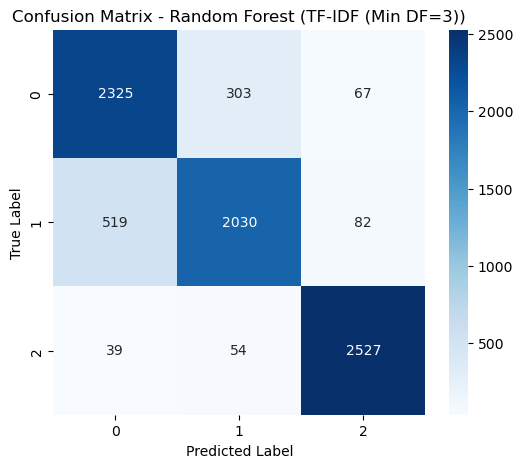


 Applying TF-IDF (Lowercase Disabled) with Random Forest
 Training Accuracy: 0.9987
 Validation Accuracy: 0.8973
 **Warning: Random Forest is Overfitting!**

 Classification Report:

              precision    recall  f1-score   support

           0       0.80      0.95      0.87      2695
           1       0.93      0.76      0.84      2631
           2       0.99      0.98      0.99      2620

    accuracy                           0.90      7946
   macro avg       0.91      0.90      0.90      7946
weighted avg       0.91      0.90      0.90      7946



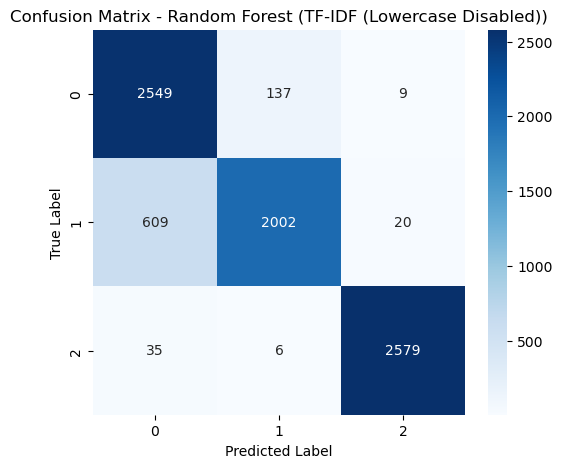

In [ ]:
# Random Forest
train_and_evaluate("TF-IDF (Unigram)", "Random Forest")
train_and_evaluate("TF-IDF (Bigram)", "Random Forest")
train_and_evaluate("TF-IDF (Trigram)", "Random Forest")
train_and_evaluate("TF-IDF (N-gram 1-3)", "Random Forest")
train_and_evaluate("TF-IDF (Feature Limited)", "Random Forest")
train_and_evaluate("TF-IDF (Stopword Removed)", "Random Forest")
train_and_evaluate("TF-IDF (Custom Stopwords)", "Random Forest")
train_and_evaluate("TF-IDF (Max Features=10000)", "Random Forest")
train_and_evaluate("TF-IDF (Sublinear TF Scaling)", "Random Forest")
train_and_evaluate("TF-IDF (Binary Term Presence)", "Random Forest")
train_and_evaluate("TF-IDF (L2 Normalization)", "Random Forest")
train_and_evaluate("TF-IDF (L1 Normalization)", "Random Forest")
train_and_evaluate("TF-IDF (No IDF Weighting)", "Random Forest")
train_and_evaluate("TF-IDF (Max DF=0.85)", "Random Forest")
train_and_evaluate("TF-IDF (Min DF=3)", "Random Forest")
train_and_evaluate("TF-IDF (Lowercase Disabled)", "Random Forest")


 Applying TF-IDF (Unigram) with XGBoost
 Training Accuracy: 0.8816
 Validation Accuracy: 0.8241
 XGBoost is performing well.

 Classification Report:

              precision    recall  f1-score   support

           0       0.73      0.91      0.81      2695
           1       0.86      0.63      0.73      2631
           2       0.92      0.92      0.92      2620

    accuracy                           0.82      7946
   macro avg       0.84      0.82      0.82      7946
weighted avg       0.84      0.82      0.82      7946



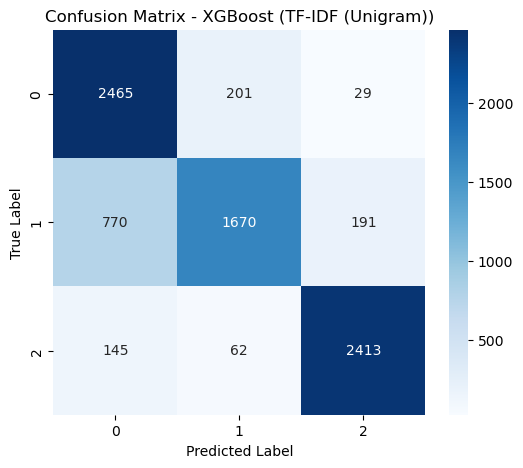


 Applying TF-IDF (Bigram) with XGBoost
 Training Accuracy: 0.7734
 Validation Accuracy: 0.7056
 XGBoost is performing well.

 Classification Report:

              precision    recall  f1-score   support

           0       0.57      0.90      0.70      2695
           1       0.75      0.42      0.54      2631
           2       0.92      0.80      0.86      2620

    accuracy                           0.71      7946
   macro avg       0.75      0.70      0.70      7946
weighted avg       0.75      0.71      0.70      7946



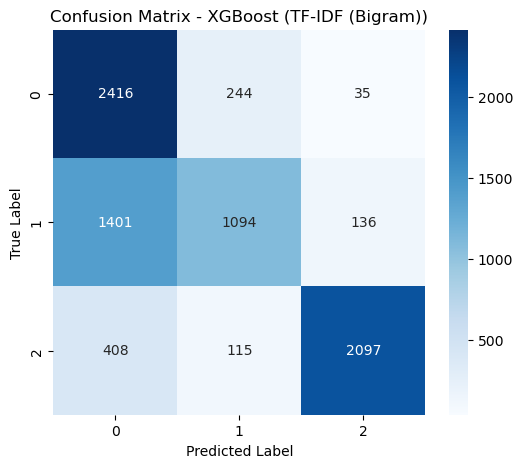


 Applying TF-IDF (Trigram) with XGBoost
 Training Accuracy: 0.6668
 Validation Accuracy: 0.6277
 **Warning: XGBoost is Underfitting!**

 Classification Report:

              precision    recall  f1-score   support

           0       0.48      0.97      0.64      2695
           1       0.75      0.10      0.18      2631
           2       0.99      0.80      0.88      2620

    accuracy                           0.63      7946
   macro avg       0.74      0.63      0.57      7946
weighted avg       0.74      0.63      0.57      7946



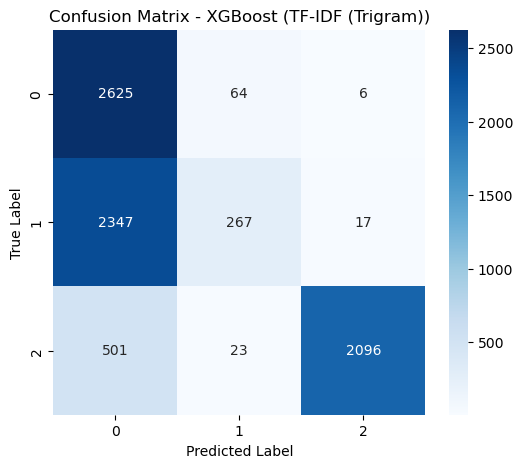


 Applying TF-IDF (N-gram 1-3) with XGBoost
 Training Accuracy: 0.8862
 Validation Accuracy: 0.8286
 XGBoost is performing well.

 Classification Report:

              precision    recall  f1-score   support

           0       0.73      0.92      0.81      2695
           1       0.87      0.65      0.74      2631
           2       0.93      0.92      0.92      2620

    accuracy                           0.83      7946
   macro avg       0.84      0.83      0.83      7946
weighted avg       0.84      0.83      0.83      7946



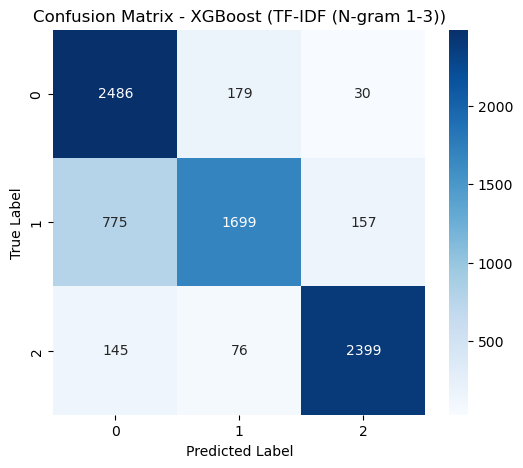


 Applying TF-IDF (Feature Limited) with XGBoost
 Training Accuracy: 0.8419
 Validation Accuracy: 0.7614
 XGBoost is performing well.

 Classification Report:

              precision    recall  f1-score   support

           0       0.68      0.87      0.77      2695
           1       0.80      0.56      0.66      2631
           2       0.84      0.85      0.84      2620

    accuracy                           0.76      7946
   macro avg       0.77      0.76      0.76      7946
weighted avg       0.77      0.76      0.76      7946



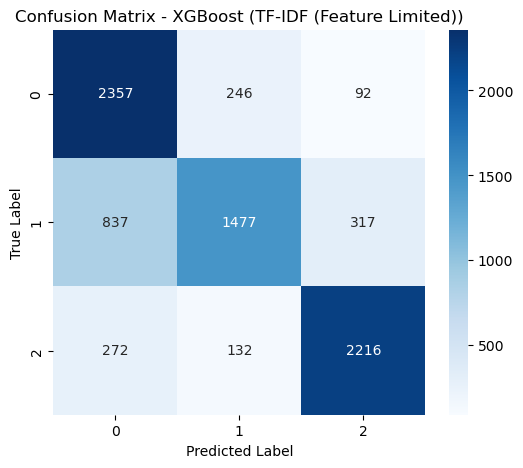


 Applying TF-IDF (Stopword Removed) with XGBoost
 Training Accuracy: 0.8561
 Validation Accuracy: 0.8058
 XGBoost is performing well.

 Classification Report:

              precision    recall  f1-score   support

           0       0.70      0.91      0.79      2695
           1       0.84      0.60      0.70      2631
           2       0.93      0.91      0.92      2620

    accuracy                           0.81      7946
   macro avg       0.82      0.81      0.80      7946
weighted avg       0.82      0.81      0.80      7946



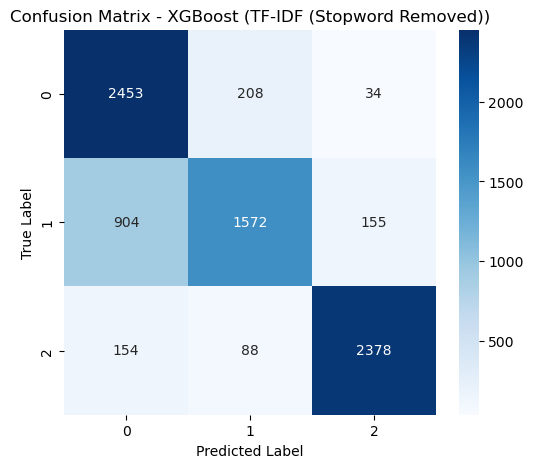


 Applying TF-IDF (Custom Stopwords) with XGBoost
 Training Accuracy: 0.8829
 Validation Accuracy: 0.8285
 XGBoost is performing well.

 Classification Report:

              precision    recall  f1-score   support

           0       0.73      0.92      0.81      2695
           1       0.87      0.64      0.74      2631
           2       0.93      0.92      0.92      2620

    accuracy                           0.83      7946
   macro avg       0.84      0.83      0.83      7946
weighted avg       0.84      0.83      0.83      7946



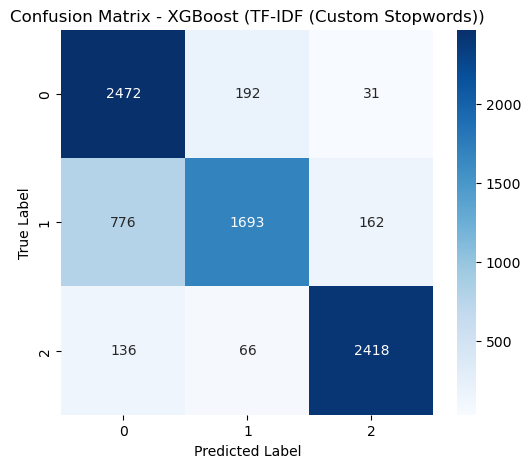


 Applying TF-IDF (Max Features=10000) with XGBoost
 Training Accuracy: 0.8524
 Validation Accuracy: 0.7793
 XGBoost is performing well.

 Classification Report:

              precision    recall  f1-score   support

           0       0.69      0.88      0.77      2695
           1       0.79      0.61      0.69      2631
           2       0.90      0.84      0.87      2620

    accuracy                           0.78      7946
   macro avg       0.79      0.78      0.78      7946
weighted avg       0.79      0.78      0.78      7946



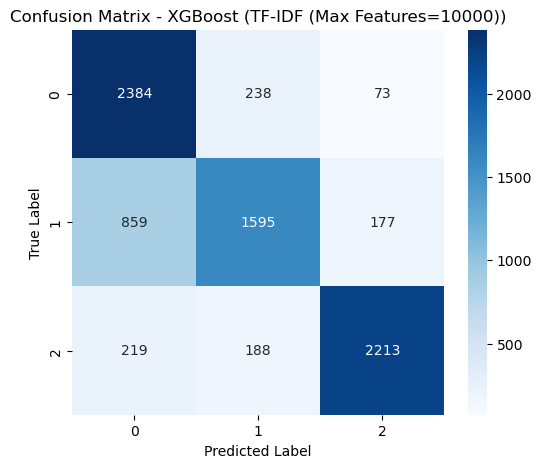


 Applying TF-IDF (Sublinear TF Scaling) with XGBoost
 Training Accuracy: 0.8824
 Validation Accuracy: 0.8248
 XGBoost is performing well.

 Classification Report:

              precision    recall  f1-score   support

           0       0.73      0.92      0.82      2695
           1       0.86      0.63      0.73      2631
           2       0.92      0.92      0.92      2620

    accuracy                           0.82      7946
   macro avg       0.84      0.82      0.82      7946
weighted avg       0.84      0.82      0.82      7946



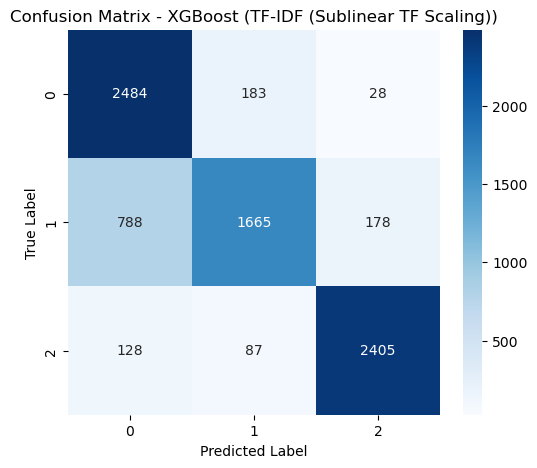


 Applying TF-IDF (Binary Term Presence) with XGBoost
 Training Accuracy: 0.8815
 Validation Accuracy: 0.8272
 XGBoost is performing well.

 Classification Report:

              precision    recall  f1-score   support

           0       0.73      0.92      0.82      2695
           1       0.86      0.64      0.73      2631
           2       0.93      0.92      0.92      2620

    accuracy                           0.83      7946
   macro avg       0.84      0.83      0.82      7946
weighted avg       0.84      0.83      0.82      7946



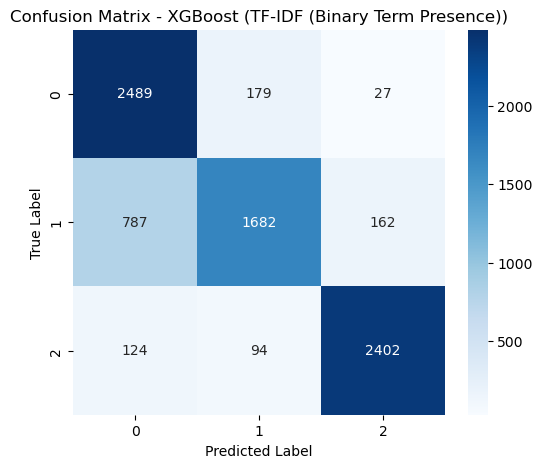


 Applying TF-IDF (L2 Normalization) with XGBoost
 Training Accuracy: 0.8838
 Validation Accuracy: 0.8296
 XGBoost is performing well.

 Classification Report:

              precision    recall  f1-score   support

           0       0.73      0.92      0.81      2695
           1       0.87      0.65      0.74      2631
           2       0.93      0.92      0.93      2620

    accuracy                           0.83      7946
   macro avg       0.84      0.83      0.83      7946
weighted avg       0.84      0.83      0.83      7946



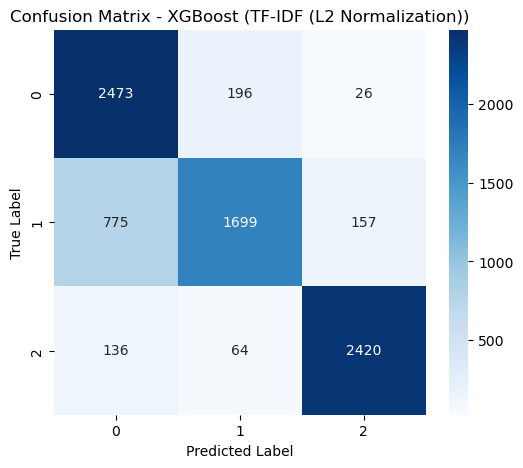


 Applying TF-IDF (L1 Normalization) with XGBoost
 Training Accuracy: 0.9123
 Validation Accuracy: 0.8696
 XGBoost is performing well.

 Classification Report:

              precision    recall  f1-score   support

           0       0.76      0.94      0.84      2695
           1       0.90      0.73      0.80      2631
           2       0.98      0.95      0.96      2620

    accuracy                           0.87      7946
   macro avg       0.88      0.87      0.87      7946
weighted avg       0.88      0.87      0.87      7946



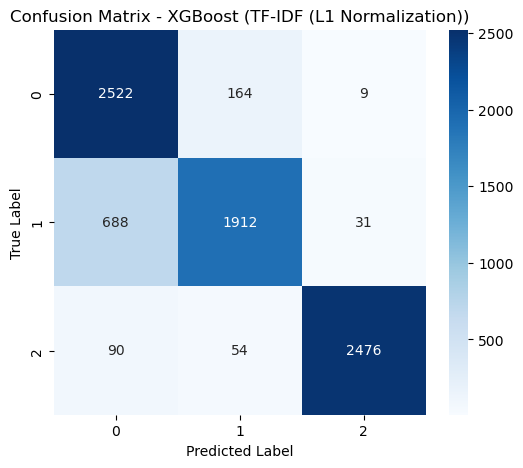


 Applying TF-IDF (No IDF Weighting) with XGBoost
 Training Accuracy: 0.8879
 Validation Accuracy: 0.8314
 XGBoost is performing well.

 Classification Report:

              precision    recall  f1-score   support

           0       0.74      0.91      0.81      2695
           1       0.85      0.67      0.75      2631
           2       0.94      0.92      0.93      2620

    accuracy                           0.83      7946
   macro avg       0.84      0.83      0.83      7946
weighted avg       0.84      0.83      0.83      7946



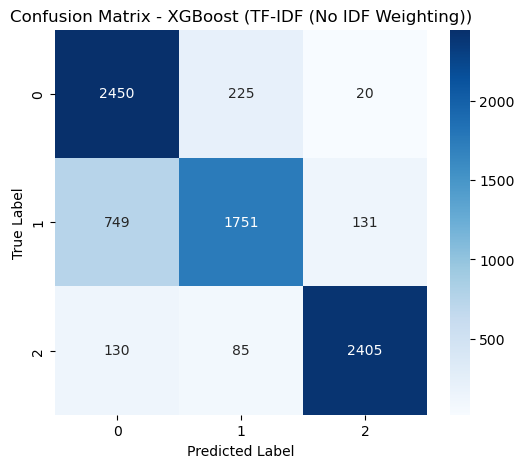


 Applying TF-IDF (Max DF=0.85) with XGBoost
 Training Accuracy: 0.8838
 Validation Accuracy: 0.8296
 XGBoost is performing well.

 Classification Report:

              precision    recall  f1-score   support

           0       0.73      0.92      0.81      2695
           1       0.87      0.65      0.74      2631
           2       0.93      0.92      0.93      2620

    accuracy                           0.83      7946
   macro avg       0.84      0.83      0.83      7946
weighted avg       0.84      0.83      0.83      7946



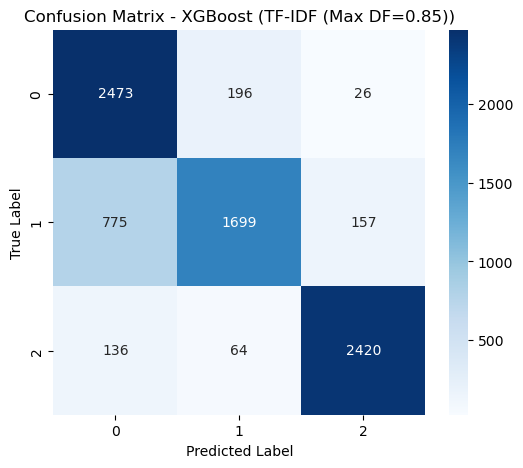


 Applying TF-IDF (Min DF=3) with XGBoost
 Training Accuracy: 0.8527
 Validation Accuracy: 0.7791
 XGBoost is performing well.

 Classification Report:

              precision    recall  f1-score   support

           0       0.69      0.88      0.77      2695
           1       0.79      0.61      0.69      2631
           2       0.90      0.85      0.87      2620

    accuracy                           0.78      7946
   macro avg       0.79      0.78      0.78      7946
weighted avg       0.79      0.78      0.78      7946



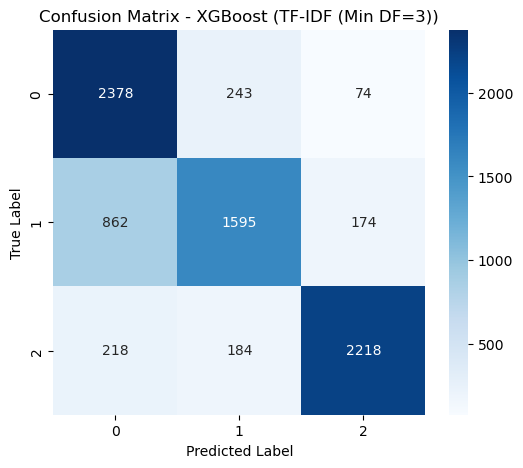


 Applying TF-IDF (Lowercase Disabled) with XGBoost
 Training Accuracy: 0.8838
 Validation Accuracy: 0.8296
 XGBoost is performing well.

 Classification Report:

              precision    recall  f1-score   support

           0       0.73      0.92      0.81      2695
           1       0.87      0.65      0.74      2631
           2       0.93      0.92      0.93      2620

    accuracy                           0.83      7946
   macro avg       0.84      0.83      0.83      7946
weighted avg       0.84      0.83      0.83      7946



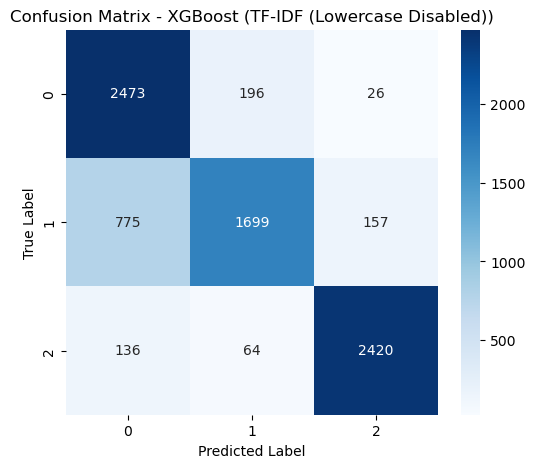

In [ ]:
# XGBoost
train_and_evaluate("TF-IDF (Unigram)", "XGBoost")
train_and_evaluate("TF-IDF (Bigram)", "XGBoost")
train_and_evaluate("TF-IDF (Trigram)", "XGBoost")
train_and_evaluate("TF-IDF (N-gram 1-3)", "XGBoost")
train_and_evaluate("TF-IDF (Feature Limited)", "XGBoost")
train_and_evaluate("TF-IDF (Stopword Removed)", "XGBoost")
train_and_evaluate("TF-IDF (Custom Stopwords)", "XGBoost")
train_and_evaluate("TF-IDF (Max Features=10000)", "XGBoost")
train_and_evaluate("TF-IDF (Sublinear TF Scaling)", "XGBoost")
train_and_evaluate("TF-IDF (Binary Term Presence)", "XGBoost")
train_and_evaluate("TF-IDF (L2 Normalization)", "XGBoost")
train_and_evaluate("TF-IDF (L1 Normalization)", "XGBoost")
train_and_evaluate("TF-IDF (No IDF Weighting)", "XGBoost")
train_and_evaluate("TF-IDF (Max DF=0.85)", "XGBoost")
train_and_evaluate("TF-IDF (Min DF=3)", "XGBoost")
train_and_evaluate("TF-IDF (Lowercase Disabled)", "XGBoost")


 Applying TF-IDF (Unigram) with Voting Classifier
 Training Accuracy: 0.9645
 Validation Accuracy: 0.8826
 Voting Classifier is performing well.

 Classification Report:

              precision    recall  f1-score   support

           0       0.83      0.85      0.84      2695
           1       0.85      0.80      0.83      2631
           2       0.96      0.99      0.98      2620

    accuracy                           0.88      7946
   macro avg       0.88      0.88      0.88      7946
weighted avg       0.88      0.88      0.88      7946



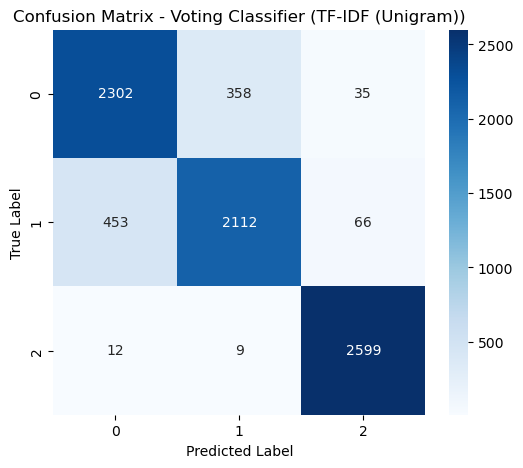


 Applying TF-IDF (Bigram) with Voting Classifier
 Training Accuracy: 0.9854
 Validation Accuracy: 0.8223
 **Warning: Voting Classifier is Overfitting!**

 Classification Report:

              precision    recall  f1-score   support

           0       0.81      0.72      0.76      2695
           1       0.84      0.77      0.80      2631
           2       0.82      0.99      0.90      2620

    accuracy                           0.82      7946
   macro avg       0.82      0.82      0.82      7946
weighted avg       0.82      0.82      0.82      7946



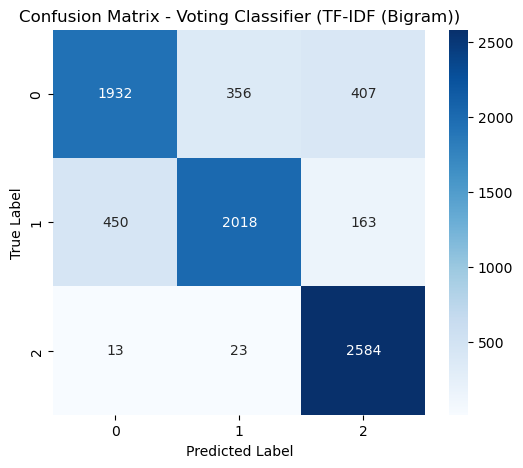


 Applying TF-IDF (Trigram) with Voting Classifier
 Training Accuracy: 0.9447
 Validation Accuracy: 0.8325
 **Warning: Voting Classifier is Overfitting!**

 Classification Report:

              precision    recall  f1-score   support

           0       0.69      0.94      0.79      2695
           1       0.93      0.68      0.79      2631
           2       0.98      0.87      0.93      2620

    accuracy                           0.83      7946
   macro avg       0.87      0.83      0.83      7946
weighted avg       0.86      0.83      0.83      7946



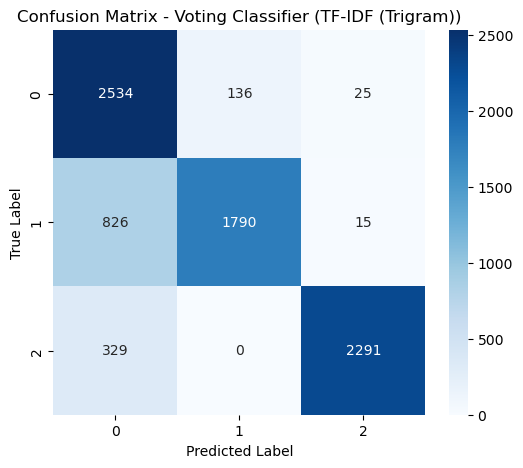


 Applying TF-IDF (N-gram 1-3) with Voting Classifier
 Training Accuracy: 0.9916
 Validation Accuracy: 0.9246
 Voting Classifier is performing well.

 Classification Report:

              precision    recall  f1-score   support

           0       0.87      0.92      0.90      2695
           1       0.92      0.85      0.88      2631
           2       0.99      1.00      0.99      2620

    accuracy                           0.92      7946
   macro avg       0.93      0.92      0.92      7946
weighted avg       0.93      0.92      0.92      7946



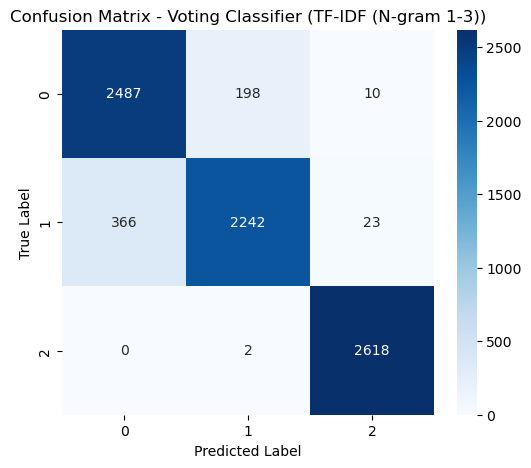


 Applying TF-IDF (Feature Limited) with Voting Classifier
 Training Accuracy: 0.9385
 Validation Accuracy: 0.8366
 **Warning: Voting Classifier is Overfitting!**

 Classification Report:

              precision    recall  f1-score   support

           0       0.81      0.79      0.80      2695
           1       0.80      0.76      0.78      2631
           2       0.89      0.96      0.93      2620

    accuracy                           0.84      7946
   macro avg       0.83      0.84      0.84      7946
weighted avg       0.83      0.84      0.84      7946



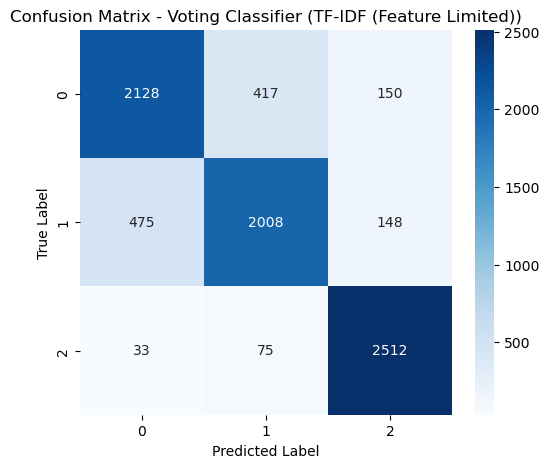


 Applying TF-IDF (Stopword Removed) with Voting Classifier


Exception ignored in: 'zmq.backend.cython.message.Frame.__dealloc__'
Traceback (most recent call last):
  File "zmq\\backend\\cython\\checkrc.pxd", line 13, in zmq.backend.cython.checkrc._check_rc
KeyboardInterrupt: 


KeyboardInterrupt: 

In [ ]:
# Voting Classifier
train_and_evaluate("TF-IDF (Unigram)", "Voting Classifier")
train_and_evaluate("TF-IDF (Bigram)", "Voting Classifier")
train_and_evaluate("TF-IDF (Trigram)", "Voting Classifier")
train_and_evaluate("TF-IDF (N-gram 1-3)", "Voting Classifier")
train_and_evaluate("TF-IDF (Feature Limited)", "Voting Classifier")
train_and_evaluate("TF-IDF (Stopword Removed)", "Voting Classifier")
train_and_evaluate("TF-IDF (Custom Stopwords)", "Voting Classifier")
train_and_evaluate("TF-IDF (Max Features=10000)", "Voting Classifier")
train_and_evaluate("TF-IDF (Sublinear TF Scaling)", "Voting Classifier")
train_and_evaluate("TF-IDF (Binary Term Presence)", "Voting Classifier")
train_and_evaluate("TF-IDF (L2 Normalization)", "Voting Classifier")
train_and_evaluate("TF-IDF (L1 Normalization)", "Voting Classifier")
train_and_evaluate("TF-IDF (No IDF Weighting)", "Voting Classifier")
train_and_evaluate("TF-IDF (Max DF=0.85)", "Voting Classifier")
train_and_evaluate("TF-IDF (Min DF=3)", "Voting Classifier")
train_and_evaluate("TF-IDF (Lowercase Disabled)", "Voting Classifier")

**Use the Best Model and Use It for Prediction**

**Apply Similar Preprocessing technique for test data**

In [ ]:
# Load test data
#test_data = pd.read_csv('https://drive.google.com/uc?id=1SI0rdFqOSDAkMS-ULv6POCqYUhYL602p&export=download')
#df_test = pd.read_csv('https://drive.google.com/uc?id=1SI0rdFqOSDAkMS-ULv6POCqYUhYL602p&export=download')
df_test = pd.read_csv(r'test.csv')

In [ ]:
df_test.head()

id                                              tweet
0  15923  #WhoIsQ #WheresTheServer #DumpNike #DECLASFISA...
1  27014  #ConstitutionDay is revered by Conservatives, ...
2  30530  #FOXNews #NRA #MAGA #POTUS #TRUMP #2ndAmendmen...
3  13876  #Watching #Boomer getting the news that she is...
4  60133  #NoPasaran: Unity demo to oppose the far-right...

In [ ]:
# check for empty strings and NaN values in the processed columns at each stage of your preprocessing pipeline:
# After loading the initial data:
print("Missing values in 'tweet' column initially:", df['tweet'].isnull().sum())
print("Empty strings in 'tweet' column initially:", df[df['tweet'] == ''].shape[0])

Missing values in 'tweet' column initially: 0
Empty strings in 'tweet' column initially: 0


In [ ]:
df_test.isnull().sum()

id       0
tweet    0
dtype: int64

In [ ]:
df_test .columns

Index(['id', 'tweet'], dtype='object')

***II. Clean Text***

In [ ]:
# Define a text cleaning function
def clean_text_text(tweet):
    """Cleans text by removing hashtags, mentions, URLs, and special characters while preserving meaningful text."""

  # Decode HTML entities
    text = html.unescape(tweet)

   # Expand contractions (e.g., "can't" -> "cannot")
    text = contractions.fix(text)

    # Convert emojis to text descriptions (e.g., 😊 -> ":smiling_face_with_smiling_eyes:")
    text = emoji.demojize(text, delimiters=(" ", " "))

    # Remove URLs and domains
    text = re.sub(r'(https?://|www\.)\S+|[a-zA-Z0-9.-]+\.(com|org|net|edu|gov|uk|io|co)\S*', '', text)

    # Remove mentions (@username)
    text = re.sub(r'@\w+', '', text)

    # Remove hashtags but keep the words (e.g., "#HelloWorld" → "HelloWorld")
    text = re.sub(r'#', '', text)

    # Remove non-alphanumeric characters except spaces
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)

    # Normalize repeated characters (e.g., "heyyy" -> "hey")
    text = re.sub(r'(.)\1{2,}', r'\1', text)

    # Convert text to lowercase
    text = text.lower()

    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()

    return text

# Apply cleaning function to the test dataset
df_test['cleaned_text_test'] = df_test['tweet'].apply(clean_text_text)

# Display the cleaned test data
df_test.head()

id                                              tweet  \
0  15923  #WhoIsQ #WheresTheServer #DumpNike #DECLASFISA...   
1  27014  #ConstitutionDay is revered by Conservatives, ...   
2  30530  #FOXNews #NRA #MAGA #POTUS #TRUMP #2ndAmendmen...   
3  13876  #Watching #Boomer getting the news that she is...   
4  60133  #NoPasaran: Unity demo to oppose the far-right...   

                                   cleaned_text_test  
0  whoisq wherestheserver dumpnike declasfisa dem...  
1  constitutionday is revered by conservatives ha...  
2  foxnews nra maga potus trump 2ndamendment rnc ...  
3  watching boomer getting the news that she is s...  
4  nopasaran unity demo to oppose the farright in...

In [ ]:
# After applying clean_text:
print("Missing values in 'cleaned_text' column:", df_test['cleaned_text_test'].isnull().sum())
print("Empty strings in 'cleaned_text' column:", df_test[df_test['cleaned_text_test'] == ''].shape[0])

Missing values in 'cleaned_text' column: 0
Empty strings in 'cleaned_text' column: 0


**Tokenization with Handle Negations**

In [ ]:
import spacy
import pandas as pd

# Load spaCy English model
nlp = spacy.load("en_core_web_sm")

def handle_negations_and_tokenize(text):
    doc = nlp(text)
    tokens = []
    negate_next = False

    for token in doc:
        if token.text.lower() in {"no", "not", "never", "n't"}:
            negate_next = True
            tokens.append(token.text)
        elif negate_next:
            tokens.append(f"not_{token.text}")
            negate_next = False
        else:
            tokens.append(token.text)

    return ' '.join(tokens)

# Apply the updated function to handle negations and tokenize text
df_test['tokened_text_test'] = df_test['cleaned_text_test'].apply(handle_negations_and_tokenize)

# Display the processed data
df_test.head()


id                                              tweet  \
0  15923  #WhoIsQ #WheresTheServer #DumpNike #DECLASFISA...   
1  27014  #ConstitutionDay is revered by Conservatives, ...   
2  30530  #FOXNews #NRA #MAGA #POTUS #TRUMP #2ndAmendmen...   
3  13876  #Watching #Boomer getting the news that she is...   
4  60133  #NoPasaran: Unity demo to oppose the far-right...   

                                   cleaned_text_test  \
0  whoisq wherestheserver dumpnike declasfisa dem...   
1  constitutionday is revered by conservatives ha...   
2  foxnews nra maga potus trump 2ndamendment rnc ...   
3  watching boomer getting the news that she is s...   
4  nopasaran unity demo to oppose the farright in...   

                                   tokened_text_test  
0  whoisq wherestheserver dumpnike declasfisa dem...  
1  constitutionday is revered by conservatives ha...  
2  foxnews nra maga potus trump 2ndamendment rnc ...  
3  watching boomer getting the news that she is s...  
4  nopasaran unity demo to oppose the farright in...

In [ ]:
# After applying clean_text:
print("Missing values in 'cleaned_text' column:", df_test['tokened_text_test'].isnull().sum())
print("Empty strings in 'cleaned_text' column:", df_test[df_test['tokened_text_test'] == ''].shape[0])

Missing values in 'cleaned_text' column: 0
Empty strings in 'cleaned_text' column: 0


**Lemmatization (using SpaCy)**

In [ ]:
# Load spaCy English model
nlp = spacy.load("en_core_web_sm")

# Lemmatization function using spaCy
def lemmatize_text_spacy(text):
    """Lemmatizes text using spaCy's NLP pipeline."""
    doc = nlp(text)
    # Extract lemmatized tokens and join them with a space
    lemmatized_tokens = [token.lemma_ for token in doc if not token.is_punct]
    return ' '.join(lemmatized_tokens)

# Apply the spaCy lemmatization function
df_test['lemmatized_text_test'] = df_test['tokened_text_test'].apply(lemmatize_text_spacy) # Changed df to test_data

# Display data after lemmatization
df_test.head() # Changed df to test_data

id                                              tweet  \
0  15923  #WhoIsQ #WheresTheServer #DumpNike #DECLASFISA...   
1  27014  #ConstitutionDay is revered by Conservatives, ...   
2  30530  #FOXNews #NRA #MAGA #POTUS #TRUMP #2ndAmendmen...   
3  13876  #Watching #Boomer getting the news that she is...   
4  60133  #NoPasaran: Unity demo to oppose the far-right...   

                                   cleaned_text_test  \
0  whoisq wherestheserver dumpnike declasfisa dem...   
1  constitutionday is revered by conservatives ha...   
2  foxnews nra maga potus trump 2ndamendment rnc ...   
3  watching boomer getting the news that she is s...   
4  nopasaran unity demo to oppose the farright in...   

                                   tokened_text_test  \
0  whoisq wherestheserver dumpnike declasfisa dem...   
1  constitutionday is revered by conservatives ha...   
2  foxnews nra maga potus trump 2ndamendment rnc ...   
3  watching boomer getting the news that she is s...   
4  nopasaran unity demo to oppose the farright in...   

                                lemmatized_text_test  
0  whoisq wherestheserver dumpnike declasfisa dem...  
1  constitutionday be revere by conservative hate...  
2  foxnew nra maga potus trump 2ndamendment rnc u...  
3  watch boomer get the news that she be still up...  
4  nopasaran unity demo to oppose the farright in...

In [ ]:
# After applying clean_text:
print("Missing values in 'cleaned_text' column:", df_test['lemmatized_text_test'].isnull().sum())
print("Empty strings in 'cleaned_text' column:", df_test[df_test['lemmatized_text_test'] == ''].shape[0])

Missing values in 'cleaned_text' column: 0
Empty strings in 'cleaned_text' column: 0


In [ ]:
df_test

**Remove Stopwords**

In [ ]:
def remove_stopwords(text):
    """Remove common stopwords while keeping key nouns and verbs for context."""
    stop_words = set(stopwords.words('english'))

    # Tokenize and get POS tags
    tokens = word_tokenize(text)
    pos_tags = nltk.pos_tag(tokens)

    # Filter tokens: keep tokens that are either not in stopwords or are nouns/verbs
    filtered_tokens = [
        token for token, pos in pos_tags
        if token not in stop_words or pos.startswith(('NN', 'VB'))
    ]

    return ' '.join(filtered_tokens)

# Apply the function to the 'test_data' dataframe instead of 'df'
df_test['final_text_test'] = df_test['lemmatized_text_test'].apply(remove_stopwords) # Changed 'df' to 'test_data'

# Display data after lemmatization
df_test.head() # Changed 'df' to 'test_data'

id                                              tweet  \
0  15923  #WhoIsQ #WheresTheServer #DumpNike #DECLASFISA...   
1  27014  #ConstitutionDay is revered by Conservatives, ...   
2  30530  #FOXNews #NRA #MAGA #POTUS #TRUMP #2ndAmendmen...   
3  13876  #Watching #Boomer getting the news that she is...   
4  60133  #NoPasaran: Unity demo to oppose the far-right...   

                                   cleaned_text_test  \
0  whoisq wherestheserver dumpnike declasfisa dem...   
1  constitutionday is revered by conservatives ha...   
2  foxnews nra maga potus trump 2ndamendment rnc ...   
3  watching boomer getting the news that she is s...   
4  nopasaran unity demo to oppose the farright in...   

                                   tokened_text_test  \
0  whoisq wherestheserver dumpnike declasfisa dem...   
1  constitutionday is revered by conservatives ha...   
2  foxnews nra maga potus trump 2ndamendment rnc ...   
3  watching boomer getting the news that she is s...   
4  nopasaran unity demo to oppose the farright in...   

                                lemmatized_text_test  \
0  whoisq wherestheserver dumpnike declasfisa dem...   
1  constitutionday be revere by conservative hate...   
2  foxnew nra maga potus trump 2ndamendment rnc u...   
3  watch boomer get the news that she be still up...   
4  nopasaran unity demo to oppose the farright in...   

                                     final_text_test  
0  whoisq wherestheserver dumpnike declasfisa dem...  
1  constitutionday be revere conservative hate pr...  
2  foxnew nra maga potus trump 2ndamendment rnc u...  
3  watch boomer get news be still parole always m...  
4  nopasaran unity demo oppose farright london an...

In [ ]:
# After applying clean_text:
print("Missing values in 'cleaned_text' column:", df_test['final_text_test'].isnull().sum())
print("Empty strings in 'cleaned_text' column:", df_test[df_test['final_text_test'] == ''].shape[0])

Missing values in 'cleaned_text' column: 0
Empty strings in 'cleaned_text' column: 0


In [ ]:
df_test.columns

Index(['id', 'tweet', 'cleaned_text_test', 'tokened_text_test',
       'lemmatized_text_test', 'final_text_test'],
      dtype='object')

**Train and the Best Model**

In [ ]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Sklearn modules
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

# Metrics and Evaluation
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Handling Imbalanced Data
from imblearn.over_sampling import SMOTE

# Warnings (Optional - To suppress unnecessary warnings)
import warnings
warnings.filterwarnings("ignore")


In [ ]:
df.columns

Index(['id', 'tweet', 'label', 'cleaned_text', 'tokenized_text',
       'lemmatized_text', 'final_text'],
      dtype='object')

 Accuracy (SMOTE applied - final_text - TF-IDF (***)): 0.8688648376541657

 Classification Report:

              precision    recall  f1-score   support

         NOT       0.81      0.87      0.84      2695
         TIN       0.86      0.77      0.81      2631
         UNT       0.95      0.97      0.96      2620

    accuracy                           0.87      7946
   macro avg       0.87      0.87      0.87      7946
weighted avg       0.87      0.87      0.87      7946



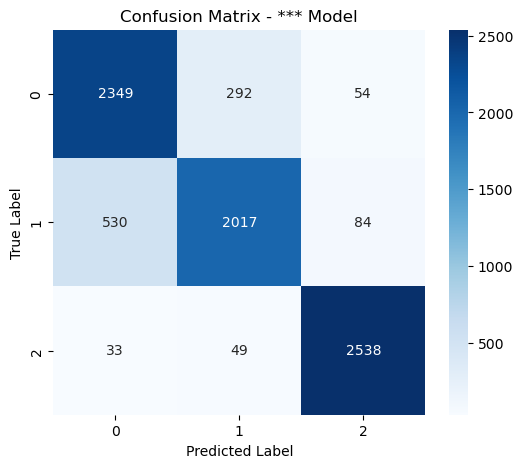

In [ ]:
# Define the best text version and vectorization technique
text_version = 'final_text'

#vectorizer =  TfidfVectorizer(ngram_range=(1, 2), min_df=3)
#vectorizer =  TfidfVectorizer(ngram_range=(1, 2), binary=True)
#vectorizer = TfidfVectorizer(ngram_range=(1, 2), norm='l1')
#vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=10000)  # TF-IDF (Feature Limited)
#vectorizer = TfidfVectorizer(ngram_range=(1, 2), sublinear_tf=True)
#vectorizer =  TfidfVectorizer(ngram_range=(2, 2))
#vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=5000)
#vectorizer = TfidfVectorizer(ngram_range=(1, 3), max_features=5000)
vectorizer = TfidfVectorizer(ngram_range=(1, 3), max_features=10000)
#vectorizer =  TfidfVectorizer(ngram_range=(1, 3))


'''
    "TF-IDF (Min DF=3)": TfidfVectorizer(ngram_range=(1, 2), min_df=3),
    "TF-IDF (Binary Term Presence)": TfidfVectorizer(ngram_range=(1, 2), binary=True),
    "TF-IDF (L1 Normalization)": TfidfVectorizer(ngram_range=(1, 2), norm='l1'),
    "TF-IDF (Max Features=10000)": TfidfVectorizer(ngram_range=(1, 2), max_features=10000),
    "TF-IDF (Sublinear TF Scaling)": TfidfVectorizer(ngram_range=(1, 2), sublinear_tf=True),
    TF-IDF (Bigram)": TfidfVectorizer(ngram_range=(2, 2)),
    "TF-IDF (Feature Limited)": TfidfVectorizer(ngram_range=(1, 2), max_features=5000),
    "TF-IDF (N-gram 1-3)": TfidfVectorizer(ngram_range=(1, 3)),
'''

# Apply vectorization
X_vectorized = vectorizer.fit_transform(df[text_version])


# Encode Labels (Required for XGBoost)**
#label_encoder = LabelEncoder()
#y_encoded = label_encoder.fit_transform(df['label'])  # Encode categorical labels ('NOT', 'TIN', 'UNT') into (0, 1, 2)
y = df['label']

# Apply SMOTE before splitting
smote = SMOTE(random_state=100)
#X_resampled, y_resampled = smote.fit_resample(X_vectorized, y_encoded)
X_resampled, y_resampled = smote.fit_resample(X_vectorized, y)

# Split data after applying SMOTE
X_train, X_val, y_train, y_val = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=100)


# Initialize and train the Random Forest model
#best_model = SVC(kernel='rbf', C=10, random_state=100)

# Initialize & Train Decision Tree Model
#best_model = DecisionTreeClassifier(criterion='gini', max_depth=10, random_state=100)

# Initialize & Train Naïve Bayes Model
#best_model = MultinomialNB(alpha=1.0)  # Laplace smoothing

'''
best_model = xgb.XGBClassifier(
        objective='multi:softmax',  # Multiclass classification
        num_class=3,                # Number of classes
        eval_metric='mlogloss',     # Evaluation metric
        use_label_encoder=False,    # Avoids warnings
        random_state=100
    )
'''

'''
#  Initialize Base Models
model1 = SVC(probability=True, kernel='linear', random_state=100)
model2 = RandomForestClassifier(n_estimators=200, random_state=100)
model3 = MultinomialNB()
model4 = LogisticRegression(max_iter=1000, random_state=100)

    #  Create Ensemble Model (Soft Voting)
best_model = VotingClassifier(estimators=[
    ('svm', model1),
    ('rf', model2),
    ('nb', model3),
    ('lr', model4)], voting='soft')  # Use 'hard' for majority voting

'''


#Initialize and train the Random Forest model
best_model = RandomForestClassifier(n_estimators=100, random_state=100)



best_model.fit(X_train, y_train)

# Make predictions
#y_pred = model.predict(X_val)
y_pred = best_model.predict(X_val)

# Compute accuracy
accuracy = accuracy_score(y_val, y_pred)
print(f" Accuracy (SMOTE applied - {text_version} - TF-IDF (***)): {accuracy}")

# Classification Report
print("\n Classification Report:\n")
print(classification_report(y_val, y_pred))

# Generate Confusion Matrix
conf_matrix = confusion_matrix(y_val, y_pred)

# Plot the Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues", xticklabels=np.unique(y_encoded), yticklabels=np.unique(y_encoded))
#sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues", xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - *** Model")
plt.show()

**Load the Best Model and Use It for Prediction**

In [ ]:
# X_train and X_val contain text data before vectorization
X_train = df['final_text']  # Raw text for training
X_val = df_test['final_text_test']  # Raw text for validation

#vectorizer =  TfidfVectorizer(ngram_range=(1, 2), min_df=3)
#vectorizer =  TfidfVectorizer(ngram_range=(1, 2), binary=True)
#vectorizer = TfidfVectorizer(ngram_range=(1, 2), norm='l1')
#vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=10000)  # TF-IDF (Feature Limited)
#vectorizer = TfidfVectorizer(ngram_range=(1, 2), sublinear_tf=True)
#vectorizer =  TfidfVectorizer(ngram_range=(2, 2))
#vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=5000)
#vectorizer = TfidfVectorizer(ngram_range=(1, 3), max_features=5000)
vectorizer = TfidfVectorizer(ngram_range=(1, 3), max_features=10000)
#vectorizer =  TfidfVectorizer(ngram_range=(1, 3))




# Apply TF-IDF Vectorization
X_train_tfidf = vectorizer.fit_transform(X_train)  # Fit and transform training data
X_val_tfidf = vectorizer.transform(X_val)  # Transform validation data

# Apply TF-IDF to Test Set
X_test_tfidf = vectorizer.transform(df_test['final_text_test'])  # Transform test data

# Make predictions using the trained best SVM model
predictions = best_model.predict(X_test_tfidf)

# Convert numerical predictions back to original labels
#predictions_labels = label_encoder.inverse_transform(predictions)

# Add predictions to the test dataset
df_test['predictions'] = predictions
#df_test['prediction'] = predictions

# Save test predictions to CSV file
df_test.to_csv(r'predictions.csv', index=False)

print("\n Predictions saved successfully to predictions.csv")



 Predictions saved successfully to predictions.csv


In [ ]:
df_prediction = pd.read_csv(r'predictions.csv')

In [ ]:
df_prediction.head()

id                                              tweet  \
0  15923  #WhoIsQ #WheresTheServer #DumpNike #DECLASFISA...   
1  27014  #ConstitutionDay is revered by Conservatives, ...   
2  30530  #FOXNews #NRA #MAGA #POTUS #TRUMP #2ndAmendmen...   
3  13876  #Watching #Boomer getting the news that she is...   
4  60133  #NoPasaran: Unity demo to oppose the far-right...   

                                   cleaned_text_test  \
0  whoisq wherestheserver dumpnike declasfisa dem...   
1  constitutionday is revered by conservatives ha...   
2  foxnews nra maga potus trump 2ndamendment rnc ...   
3  watching boomer getting the news that she is s...   
4  nopasaran unity demo to oppose the farright in...   

                                   tokened_text_test  \
0  whoisq wherestheserver dumpnike declasfisa dem...   
1  constitutionday is revered by conservatives ha...   
2  foxnews nra maga potus trump 2ndamendment rnc ...   
3  watching boomer getting the news that she is s...   
4  nopasaran unity demo to oppose the farright in...   

                                lemmatized_text_test  \
0  whoisq wherestheserver dumpnike declasfisa dem...   
1  constitutionday be revere by conservative hate...   
2  foxnew nra maga potus trump 2ndamendment rnc u...   
3  watch boomer get the news that she be still up...   
4  nopasaran unity demo to oppose the farright in...   

                                     final_text_test predictions  
0  whoisq wherestheserver dumpnike declasfisa dem...         NOT  
1  constitutionday be revere conservative hate pr...         NOT  
2  foxnew nra maga potus trump 2ndamendment rnc u...         NOT  
3  watch boomer get news be still parole always m...         NOT  
4  nopasaran unity demo oppose farright london an...         NOT

In [ ]:
df_prediction['predictions'].value_counts()

predictions
NOT    340
TIN    103
UNT     17
Name: count, dtype: int64

**Save Required Fields**

In [ ]:
# Select only the `id` and `prediction` columns
df_final = df_test[['id', 'predictions']]

# Set `id` as the index
df_final.set_index('id', inplace=True)

# Save the DataFrame to CSV
df_final.to_csv('predictions_TfidfVectorizer_ngram_range_1_3max_features_5000.csv', header=['label'])

print("\n Predictions saved successfully with `id` as index and `prediction` as label in predictions_formatted.csv")

# Read the saved CSV file to verify content
df_loaded = pd.read_csv('predictions_TfidfVectorizer_ngram_range_1_3max_features_5000.csv', index_col='id')


df_loaded.head(10)


 Predictions saved successfully with `id` as index and `prediction` as label in predictions_formatted.csv


label
id         
15923   NOT
27014   NOT
30530   NOT
13876   NOT
60133   NOT
83681   UNT
96874   TIN
65507   NOT
78910   UNT
46363   TIN

**Conclusion**

This structured approach ensures that the text data is thoroughly preprocessed, and multiple models are evaluated to achieve the best performance. By following these steps, you can build an effective SVM model for offensive language classification and generate accurate predictions for the test dataset.